In [3]:
library(rdmc)
library(magick)
library(tidyverse)
library(ape)

library(patchwork)
options(repr.plot.width = 10, repr.plot.height = 7, repr.plot.res = 200)

tts <- 20
tts_small <- 16
theme_set(theme_classic(tts))

source("../color_df.R")

color_df <-
    color_df %>% 
    mutate(
        ssp_pop = pop,
        pop = str_remove_all(ssp_pop, "(LR_|Teo_|random1_|random2_)")
    ) %>% 
    dplyr::select(-ssp_pop) %>% 
    distinct()
color_df

Loading required package: MASS

Loading required package: dplyr


Attaching package: ‘dplyr’


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: tidyr

Loading required package: purrr

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: rlang


Attaching package: ‘rlang’


The following object is masked from ‘package:magrittr’:

    set_names


The following objects are masked from ‘package:purrr’:

    %@%, as_function, flatten, flatten_chr, flatten_dbl, flatten_int,
    flatten_lgl, flatten_raw, invoke, list_along, modify, prepend,
    splice


Linking to ImageMagick 7.0.10.28
Enabled features: ca

pop               color           
1 Los_Guajes        mediumaquamarine
2 Crucero_Lagunitas gold            
3 El_Rodeo          darkorange      
4 Amatlan_de_Canas  cornflowerblue  
5 San_Lorenzo       purple          
6 Palmar_Chico      violetred       
7 random            grey

In [4]:

integer_breaks <- function(n = 5, ...) {
  fxn <- function(x) {
    breaks <- floor(pretty(x, n, ...))
    names(breaks) <- attr(breaks, "labels")
    breaks
  }
  return(fxn)
}

plot_rdmc <- function(file, cle_low = -10, pos = NULL, title = "", subtitle = "", base_size = 15){
    
    
    FREQ_POPS = c(
        "LR.A.Ca.",
        "LR.C.La.",
        "LR.L.Gu.",
        "LR.P.Ch.",
        "LR.S.Lo.",
        "Teo.A.Ca.",
        "Teo.C.La.",
        "Teo.E.Ro.",
        "Teo.L.Gu.",
        "Teo.P.Ch.",
        "Teo.S.Lo."
    )

    id_df <- tibble(sources = 1:length(FREQ_POPS), pop_id = FREQ_POPS) 

    sweep_file <- vroom::vroom(file, delim = "\t")
    
    stopifnot(nrow(sweep_file) > 0)
    all_mods <- 
        sweep_file  %>%  
        filter(!is.na(cle), !is.na(neut_cle)) %>%  
        group_by(model) %>% 
        mutate(mcle = max(cle, na.rm = T) - neut_cle)
  
    best_mcle <- all_mods %>%
      group_by(model) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      ungroup()  %>%
      arrange(desc(mcle))

    (best_mod <- best_mcle %>% slice(1) %>% pull(model))

    

    if (best_mod == "standing"){
        

    if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set1") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set1") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set1") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 


        #visualize likelihood surface wrt age
        a  <- all_mods %>%
          group_by(times, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(times), mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("log10 Age") +
          scale_color_brewer(palette = "Set1") +  
          theme_classic(base_size) +
          theme(legend.position = "n") +
          scale_x_log10() 


        #visualize likelihood surface wrt age
        b <- all_mods %>%
          group_by(gs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(gs, mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("Initial allele frequency") +
          scale_color_brewer(palette = "Set1") +      
          theme_classic(base_size) +
          scale_x_continuous(breaks= scales::breaks_pretty(2)) +
          theme(legend.position = "n")  
        

        plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + a + b + plot_layout(nrow = 4)

    } else if(best_mod == "migration"){
        
     if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set2") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set2") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set2") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 

        
         a  <- all_mods %>%
          group_by(migs, model) %>%
          filter(model == best_mod) %>%
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          ggplot(aes(log10(migs), mcle, colour = model)) +
          geom_line(lwd = 1.2) +
          geom_point() +
          ylab(expression(Delta[cle])) +
          xlab("log10 Migration rate") +
          scale_color_brewer(palette = "Set2") +
          theme_classic(base_size) +
          theme(legend.position = "n")

        b  <- all_mods %>%
          group_by(sources, model) %>%
          filter(model == best_mod) %>%  
          summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
          filter(mcle > cle_low) %>%
          left_join(., id_df, by = "sources") %>% 
          ggplot() +
          geom_segment(aes(x = pop_id, xend = pop_id, y =0, yend = mcle, colour = model), lwd = 1.2) +
          ylab(expression(Delta[cle])) +
          xlab("Source") +
          scale_color_brewer(palette = "Set2") +
          theme_classic(base_size) +
          scale_x_discrete(guide = guide_axis(n.dodge = 2)) +
          theme(legend.position = "n") 

        plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + a + b + plot_layout(nrow = 4)

    } else {
        
        
        if(!missing(pos)){
      
      pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd=1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +  
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      scale_color_brewer(palette = "Set1") +    
      geom_vline(xintercept = pos) +
      theme_classic(base_size) +
      scale_x_continuous(breaks = scales::breaks_pretty(3)) +
      theme(legend.position = "n") 

    } else {
        
    pos_plot <- all_mods %>%
      group_by(selected_sites, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>% 
      mutate(selected_sites = (selected_sites/1e5)) %>% 
      ggplot(aes(selected_sites, mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      geom_hline(yintercept = 0, lty = 2) +
      scale_color_brewer(palette = "Set1") +    
      xlab("Position (Mb)") +
      ylab(expression(Delta[cle])) +
      theme_classic(base_size) +      
      scale_x_continuous(breaks= scales::breaks_pretty(2)) +
      theme(legend.position = "n") 
        
    }

    #visualize likelihood surface wrt selection coefficients
    sel_plot <- all_mods %>%
      group_by(sels, model) %>%
      filter(model == best_mod) %>%
      summarise(mcle = max(cle, na.rm = T) - neut_cle) %>%
      filter(mcle > cle_low) %>%   
      ggplot(aes(log10(sels), mcle, colour = model)) +
      geom_line(lwd = 1.2) +
      geom_point() +
      ylab(expression(Delta[cle])) +
      xlab("Selection coefficient") +
      scale_color_brewer(palette = "Set1") +  
      theme_classic(base_size) +
      theme(legend.position = "n") 
        
        
    plot_full <- (pos_plot + ggtitle(label = title, subtitle = subtitle)) + sel_plot + plot_layout(nrow = 2)
        
    }
    
        return(plot_full)

}

Rows: 6,900
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'migs', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sources', 'model'. You can override using the `.groups` argument.

Rows: 7,500
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

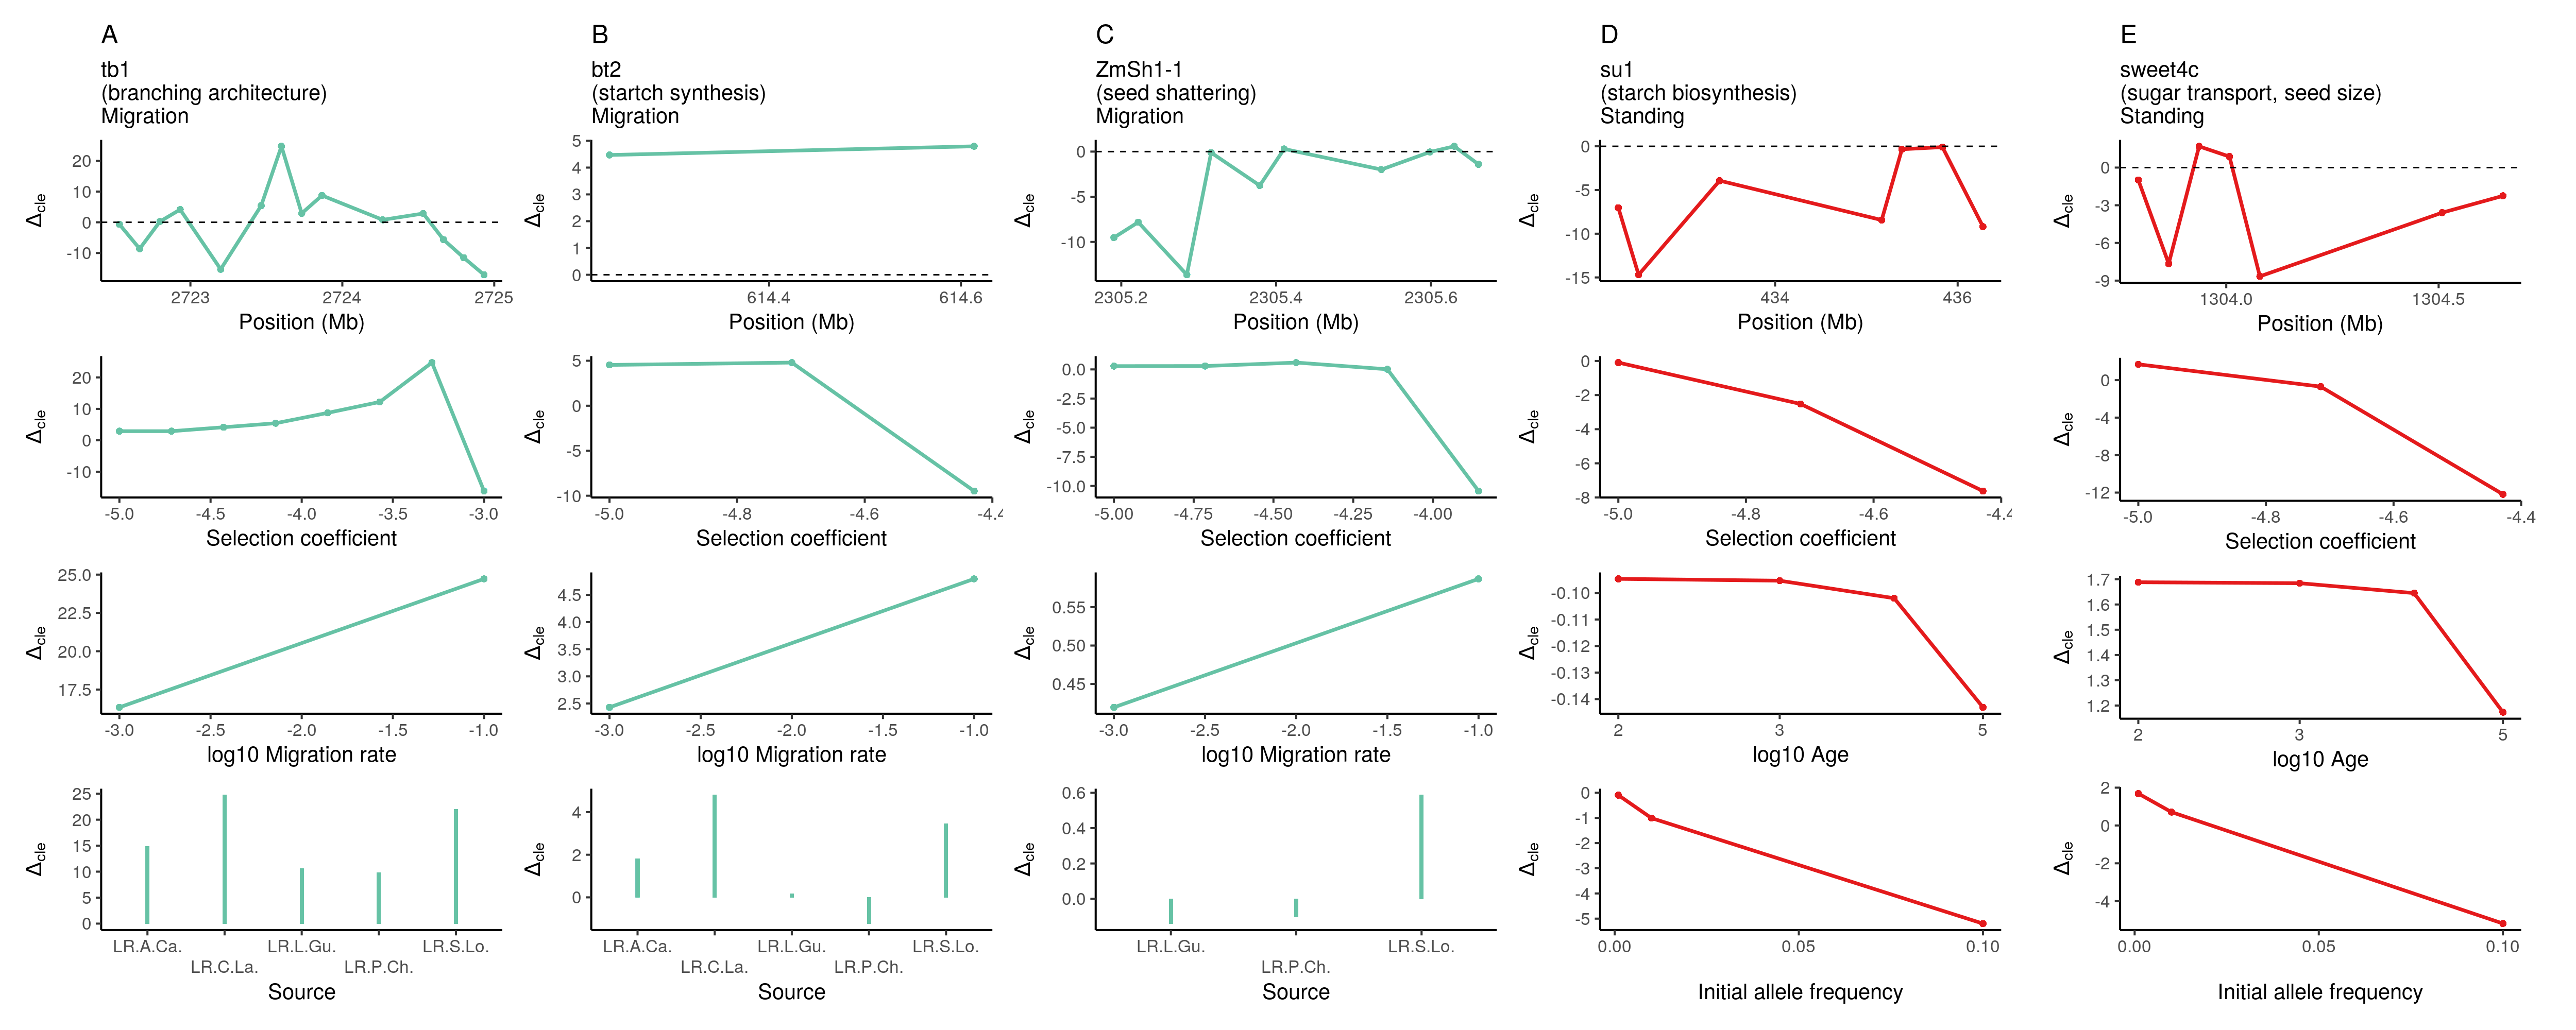

In [5]:
options(repr.plot.width = 25, repr.plot.height = 10, repr.plot.res = 200)

tb1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start272261071_end272472669_pops1-2-3-4-5.txt", 
    cle_low = -20, 
    title = "A", 
    subtitle = "tb1\n(branching architecture)\nMigration"
)

bt2 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start60951507_end61558027_pops1-2-3-4-5-10.txt", 
    cle_low = -20,
    title = "B", 
    subtitle = "bt2\n(startch synthesis)\nMigration"
)


ZmSh1_1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start230510870_end230574345_pops3-4-5.txt",  
    cle_low = -20,
    title = "C",
    subtitle = "ZmSh1-1\n(seed shattering)\nMigration"
)

su1 <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start43263146_end43615149_pops2-3-4.txt",
    cle_low = -20,
    title = "D",
    subtitle = "su1\n(starch biosynthesis)\nStanding"
)

sweet <- plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start130340943_end130464598_pops1-2-4-5.txt",
    cle_low = -20,
    title = "E",
    subtitle = "sweet4c\n(sugar transport, seed size)\nStanding"
)



(tb1 | bt2 | ZmSh1_1) |  su1 |  sweet + theme(plot.margin = unit(c(0.1,1,0.1,1), "cm")) 
ggsave("../figures/supplement_domestication_sweeps.pdf", height = 10, width = 25)


Rows: 7,500
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

`summarise()` has grouped output by 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'selected_sites', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sels', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'migs', 'model'. You can override using the `.groups` argument.

`summarise()` has grouped output by 'sources', 'model'. You can override using the `.groups` argument.



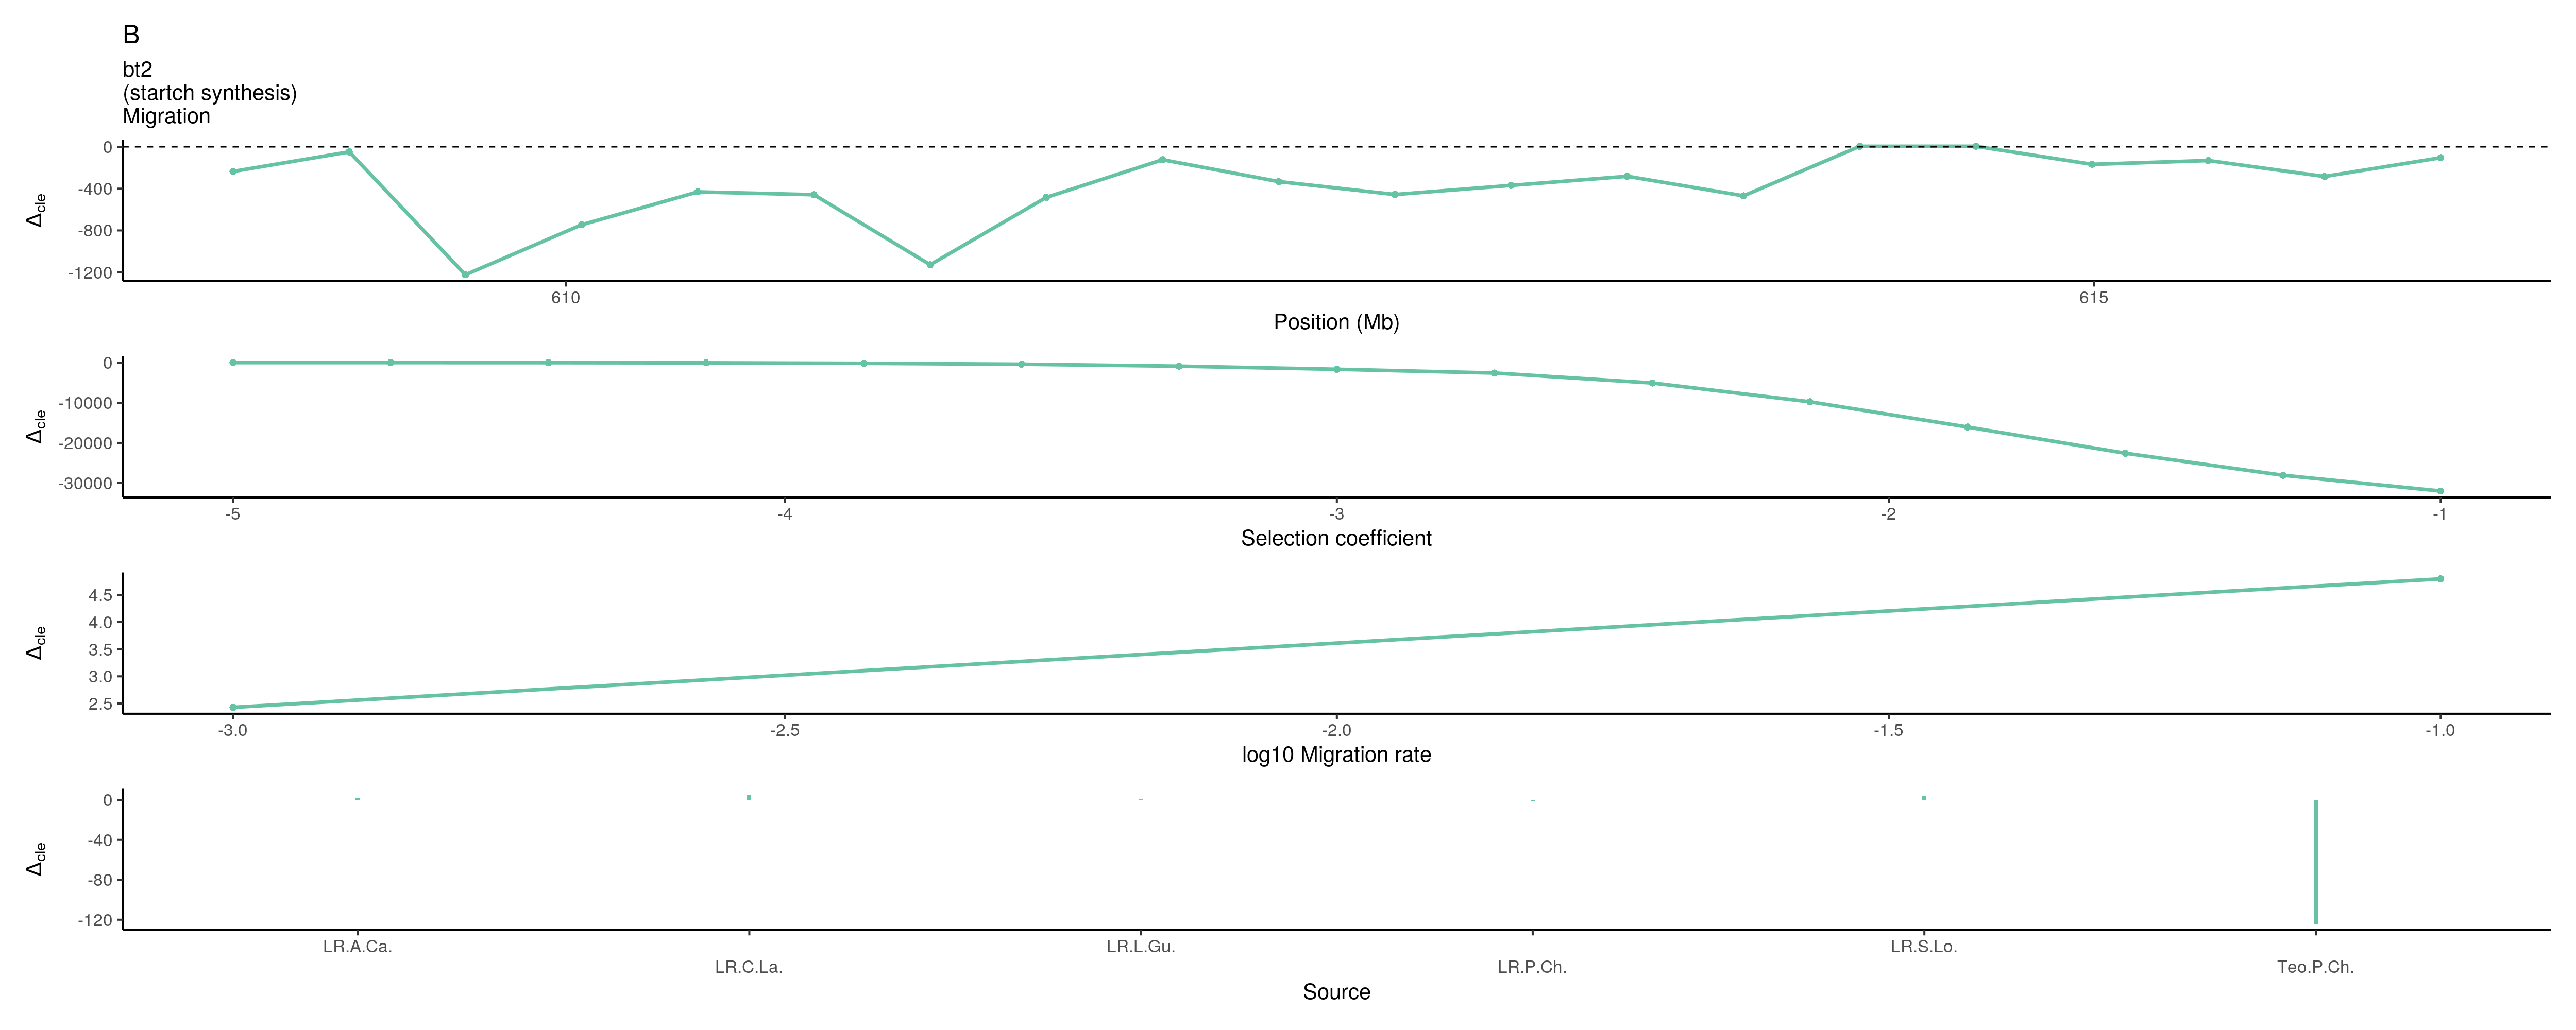

In [6]:
plot_rdmc(
    "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start60951507_end61558027_pops1-2-3-4-5-10.txt", 
    cle_low = -Inf,
    title = "B", 
    subtitle = "bt2\n(startch synthesis)\nMigration"
)


In [7]:
all_mods <- vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")

range(vroom::vroom("../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt", delim = "\t")$cle, na.rm = T)

all_mods %>%
    filter(is.na(cle))

Rows: 7,500
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message

Rows: 7,500
Columns: 18
Delimiter: "\t"
chr [ 4]: locus, sel_pops, model, sel_pop_ids
dbl [14]: selected_sites, sels, cle, gs, times, migs, sources, neut_cle, n_snps, sweepsize...

Use `spec()` to retrieve the guessed column specification
Pass a specification to the `col_types` argument to quiet this message



[1] -260839.9  376290.7

selected_sites sels         cle
1    95855838       1.000000e-05 NA 
2    95855838       1.000000e-05 NA 
3    95855838       1.000000e-05 NA 
4    95855838       1.000000e-05 NA 
5    95855838       1.000000e-05 NA 
6    95855838       1.000000e-05 NA 
7    95855838       1.000000e-05 NA 
8    95855838       1.000000e-05 NA 
9    95855838       1.000000e-05 NA 
10   95855838       1.000000e-05 NA 
11   95855838       1.000000e-05 NA 
12   95855838       1.000000e-05 NA 
13   95855838       1.930698e-05 NA 
14   95855838       1.930698e-05 NA 
15   95855838       1.930698e-05 NA 
16   95855838       1.930698e-05 NA 
17   95855838       1.930698e-05 NA 
18   95855838       1.930698e-05 NA 
19   95855838       1.930698e-05 NA 
20   95855838       1.930698e-05 NA 
21   95855838       1.930698e-05 NA 
22   95855838       1.930698e-05 NA 
23   95855838       1.930698e-05 NA 
24   95855838       1.930698e-05 NA 
25   95855838       3.727594e-05 NA 
26   95855838       3.727594e-05 NA 
27   95855838       3.727594e-05 NA 
28   95855838       3.727594e-05 NA 
29   95855838       3.727594e-05 NA 
30   95855838       3.727594e-05 NA 
⋮    ⋮              ⋮            ⋮  
5767 96775455       0.01389495   NA 
5768 96775455       0.01389495   NA 
5769 96775455       0.01389495   NA 
5770 96775455       0.02682696   NA 
5771 96775455       0.02682696   NA 
5772 96775455       0.02682696   NA 
5773 96775455       0.02682696   NA 
5774 96775455       0.02682696   NA 
5775 96775455       0.02682696   NA 
5776 96775455       0.02682696   NA 
5777 96775455       0.02682696   NA 
5778 96775455       0.02682696   NA 
5779 96775455       0.05179475   NA 
5780 96775455       0.05179475   NA 
5781 96775455       0.05179475   NA 
5782 96775455       0.05179475   NA 
5783 96775455       0.05179475   NA 
5784 96775455       0.05179475   NA 
5785 96775455       0.05179475   NA 
5786 96775455       0.05179475   NA 
5787 96775455       0.05179475   NA 
5788 96775455       0.10000000   NA 
5789 96775455       0.10000000   NA 
5790 96775455       0.10000000   NA 
5791 96775455       0.10000000   NA 
5792 96775455       0.10000000   NA 
5793 96775455       0.10000000   NA 
5794 96775455       0.10000000   NA 
5795 96775455       0.10000000   NA 
5796 96775455       0.10000000   NA 
     locus                                                                                            
1    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
2    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
3    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
4    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
5    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
6    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
7    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
8    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
9    data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
10   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
11   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
12   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
13   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
14   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
15   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95932363_end96702958_pops1-2-4-5-9-10.txt
16   data/rdmc/sweep_freq/v5--sweep--chr3--0--238017767_start95

In [8]:
make_rdmc_file <- function(file_name){
    
    if(file.exists(file_name)){
        read_csv(file_name)
    } else {    
        suppressWarnings(
        suppressMessages(
            
        top_models_df <- fs::dir_ls(path = "../data/rdmc/fitted/") %>% 
            map_df(~{
                    sweep_file <- vroom::vroom(.x, delim = "\t")
                    if(nrow(sweep_file) > 0){
                        sweep_file %>% 
                        #filter(!is.na(cle), !is.na(neut_cle), !neut_cle %in% c(-Inf, Inf), !cle %in% c(-Inf, Inf)) %>%  
                        group_by(model) %>%
                        filter(cle == max(cle, na.rm=T)) %>%
                        mutate(mcle = cle - neut_cle) %>%
                        ungroup() %>%
                        mutate(mcle_delta = mcle - max(mcle, na.rm=T)) %>%
                        arrange(desc(mcle)) %>%  
                        slice(1:2) %>%
                        mutate(mcle_nextbest_diff = -diff(mcle)) %>% 
                        slice(1) %>%
                        mutate(file_name = .x)
                    } else{
                        tibble()
                    }

            }) %>% 
            mutate(populations = sel_pop_ids) %>% 
            mutate(populations = str_remove_all(populations, "data/raisd/"),
                   populations = str_remove_all(populations, ".corrected_block_outliers_merged.txt"),
                   populations = str_replace_all(populations, "random1", "RANDOM1"),
                   populations = str_replace_all(populations, "random2", "RANDOM2"),
                   type = case_when(
                       grepl("LR", populations) & grepl("Teo", populations) ~ "both",
                       grepl("LR", populations) & !grepl("Teo", populations) ~ "Maize",
                       !grepl("LR", populations) & grepl("Teo", populations) ~ "Teosinte",
                       TRUE ~ "nan"
                   ),
                pop_count = str_count(populations, ";")+1,
                Landraces_count = str_count(populations, "LR"),
                Teosinte_count =  str_count(populations, "Teo"),
                model2 = ifelse(mcle < 0, "neutral", model)
                ) 
        ))
        
            write_csv(x = top_models_df, file = file_name)
            top_models_df
    }
}


In [9]:
top_models_df <- make_rdmc_file("rdmc_topmodels.csv")


── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  locus = col_character(),
  sel_pops = col_character(),
  model = col_character(),
  sel_pop_ids = col_character(),
  file_name = col_character(),
  populations = col_character(),
  type = col_character(),
  model2 = col_character()
)
ℹ Use `spec()` for the full column specifications.




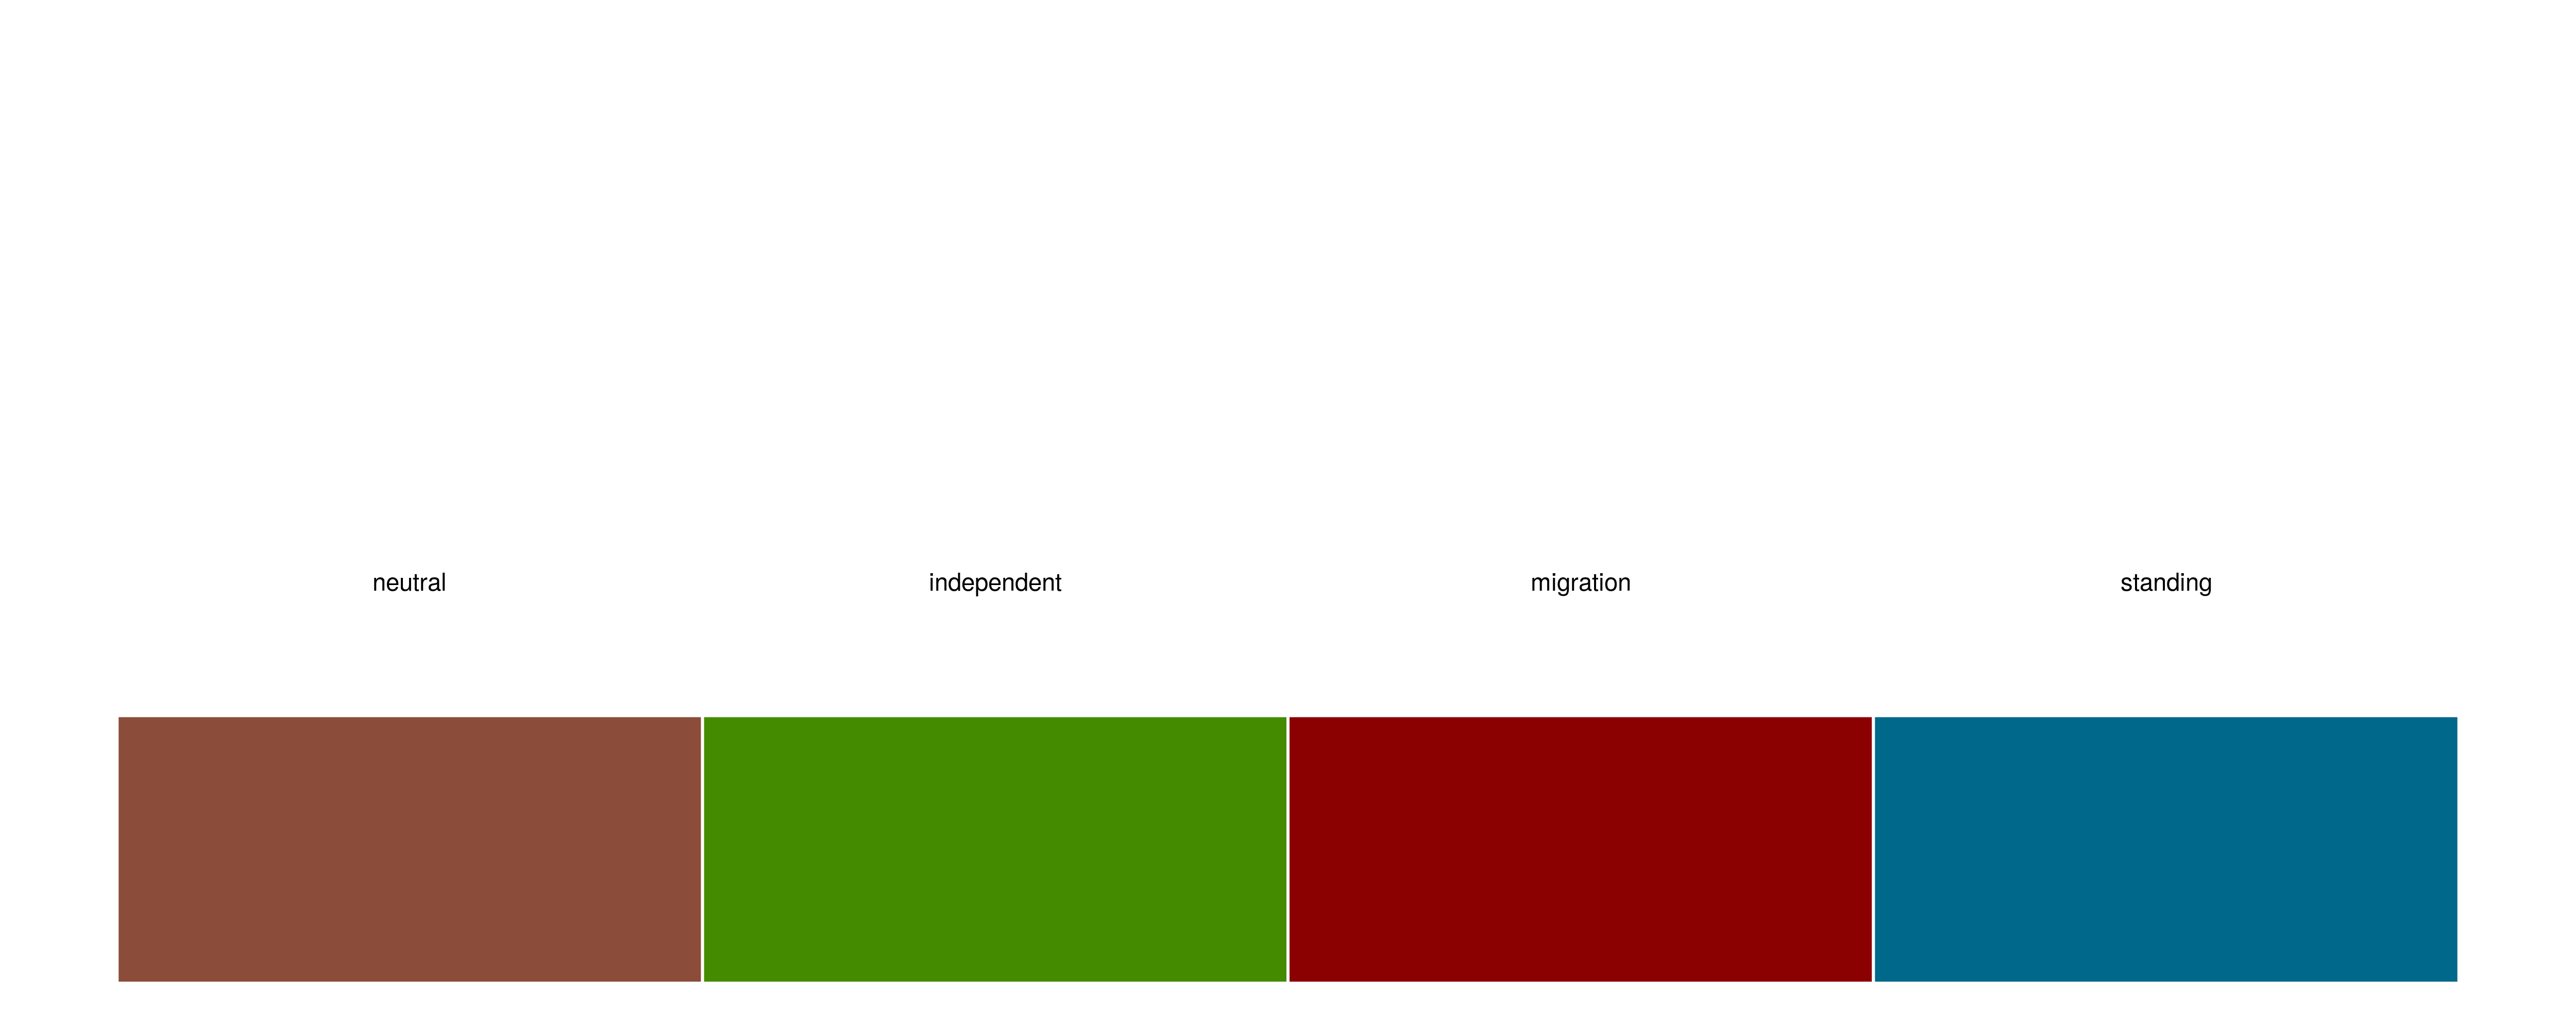

In [10]:
mode_leg <- function(size = 6, nud = 0.5){
tibble(mode = c("neutral", "independent", "migration", "standing"),
      color = c("salmon4", "chartreuse4", "darkred", "deepskyblue4"),
      position_x = 1:4,
      position_y = rep(0, 4),
      ) %>% 
ggplot(aes(position_x, position_y, fill = color)) +
    geom_tile(colour = "white", lwd = 1) +
    geom_text(aes(position_x, position_y + nud, label = mode), inherit.aes = F, size = size) +
    xlim(0.5, 4.5) +
    ylim(-0.5, 2+nud) +
    scale_fill_identity() +
    theme_void()
}

mode_leg(nud = 1)

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


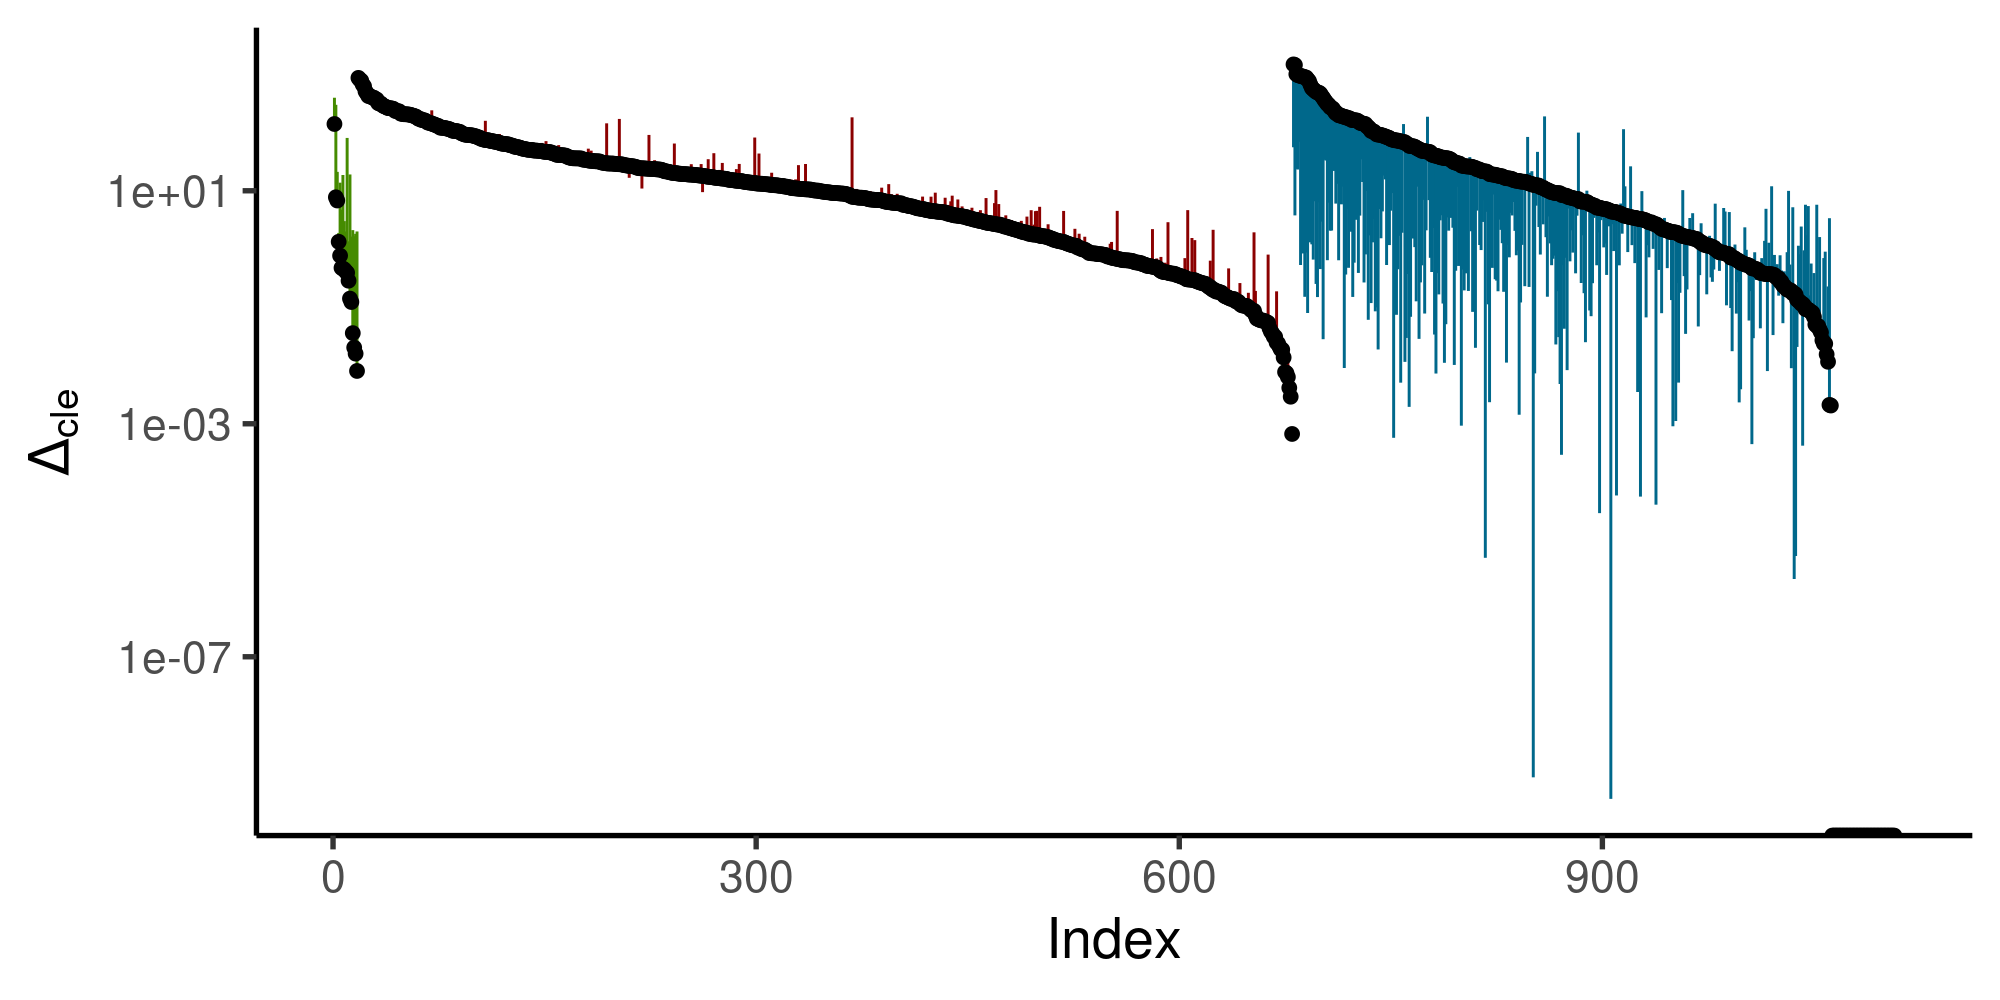

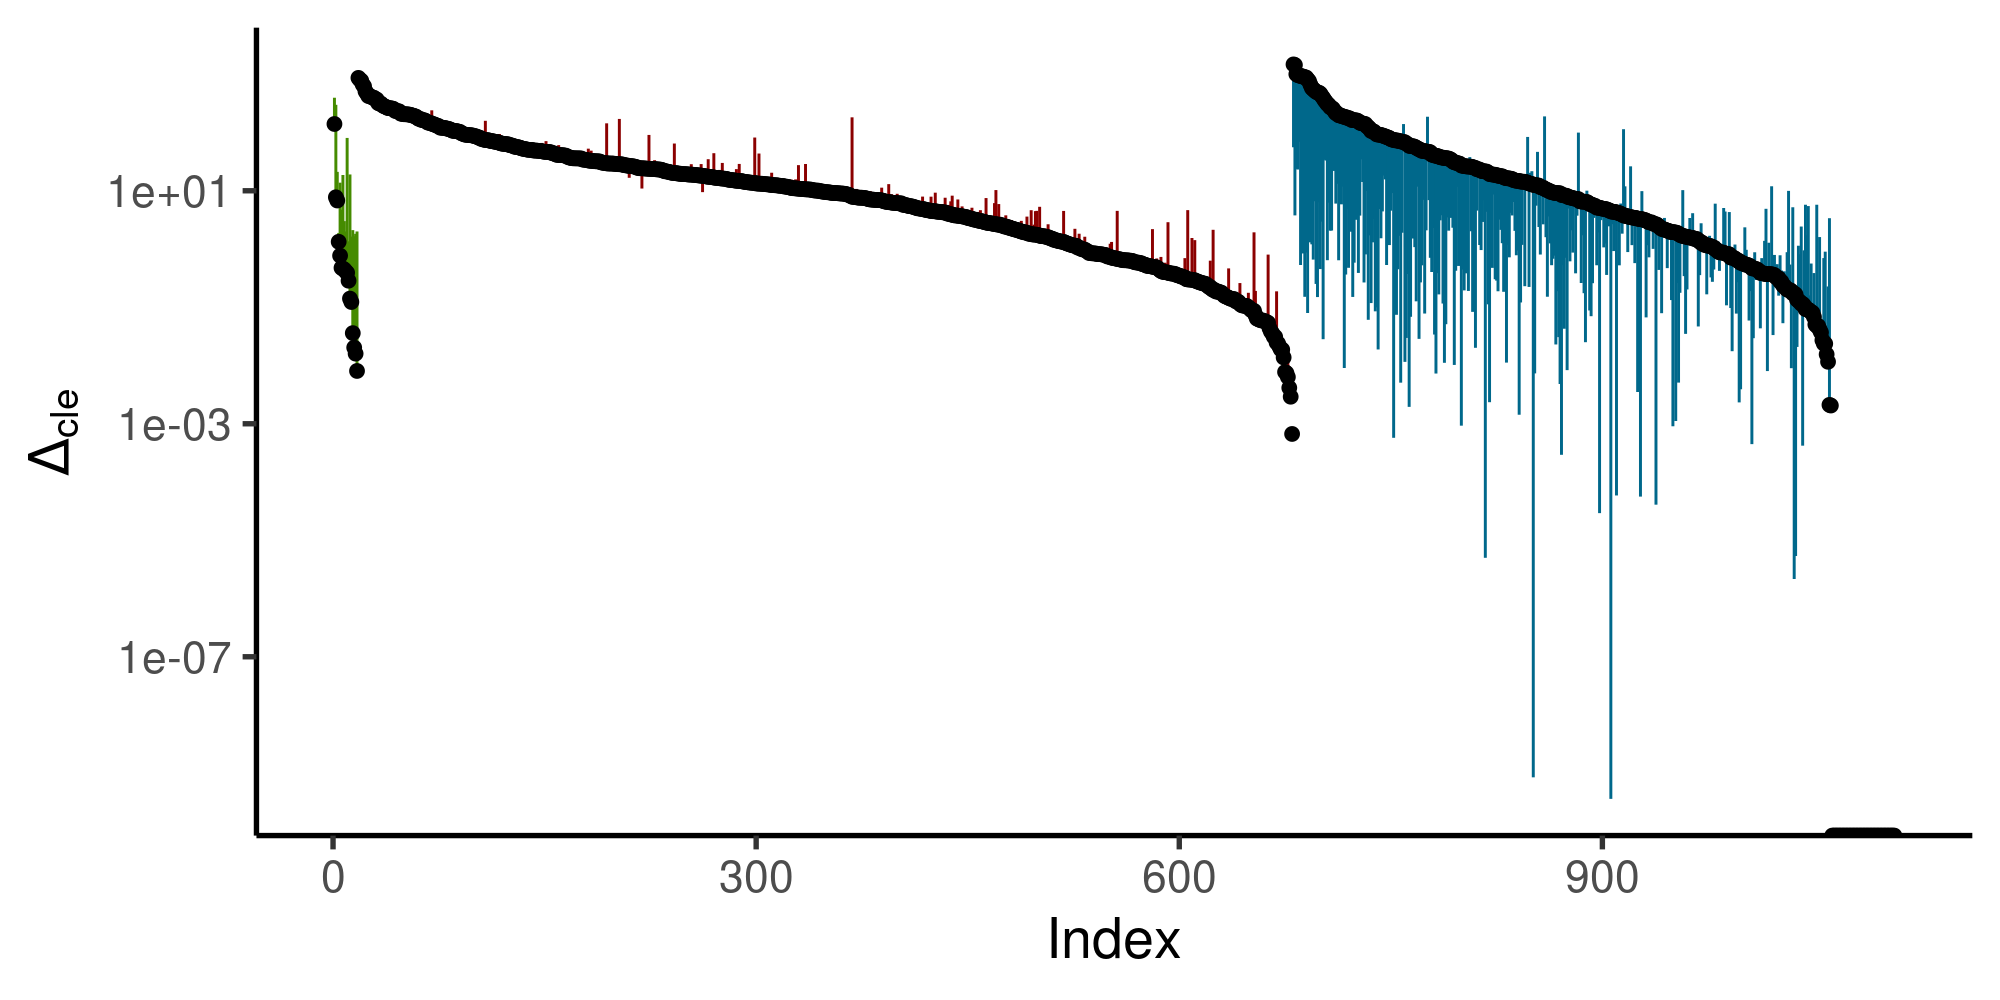

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


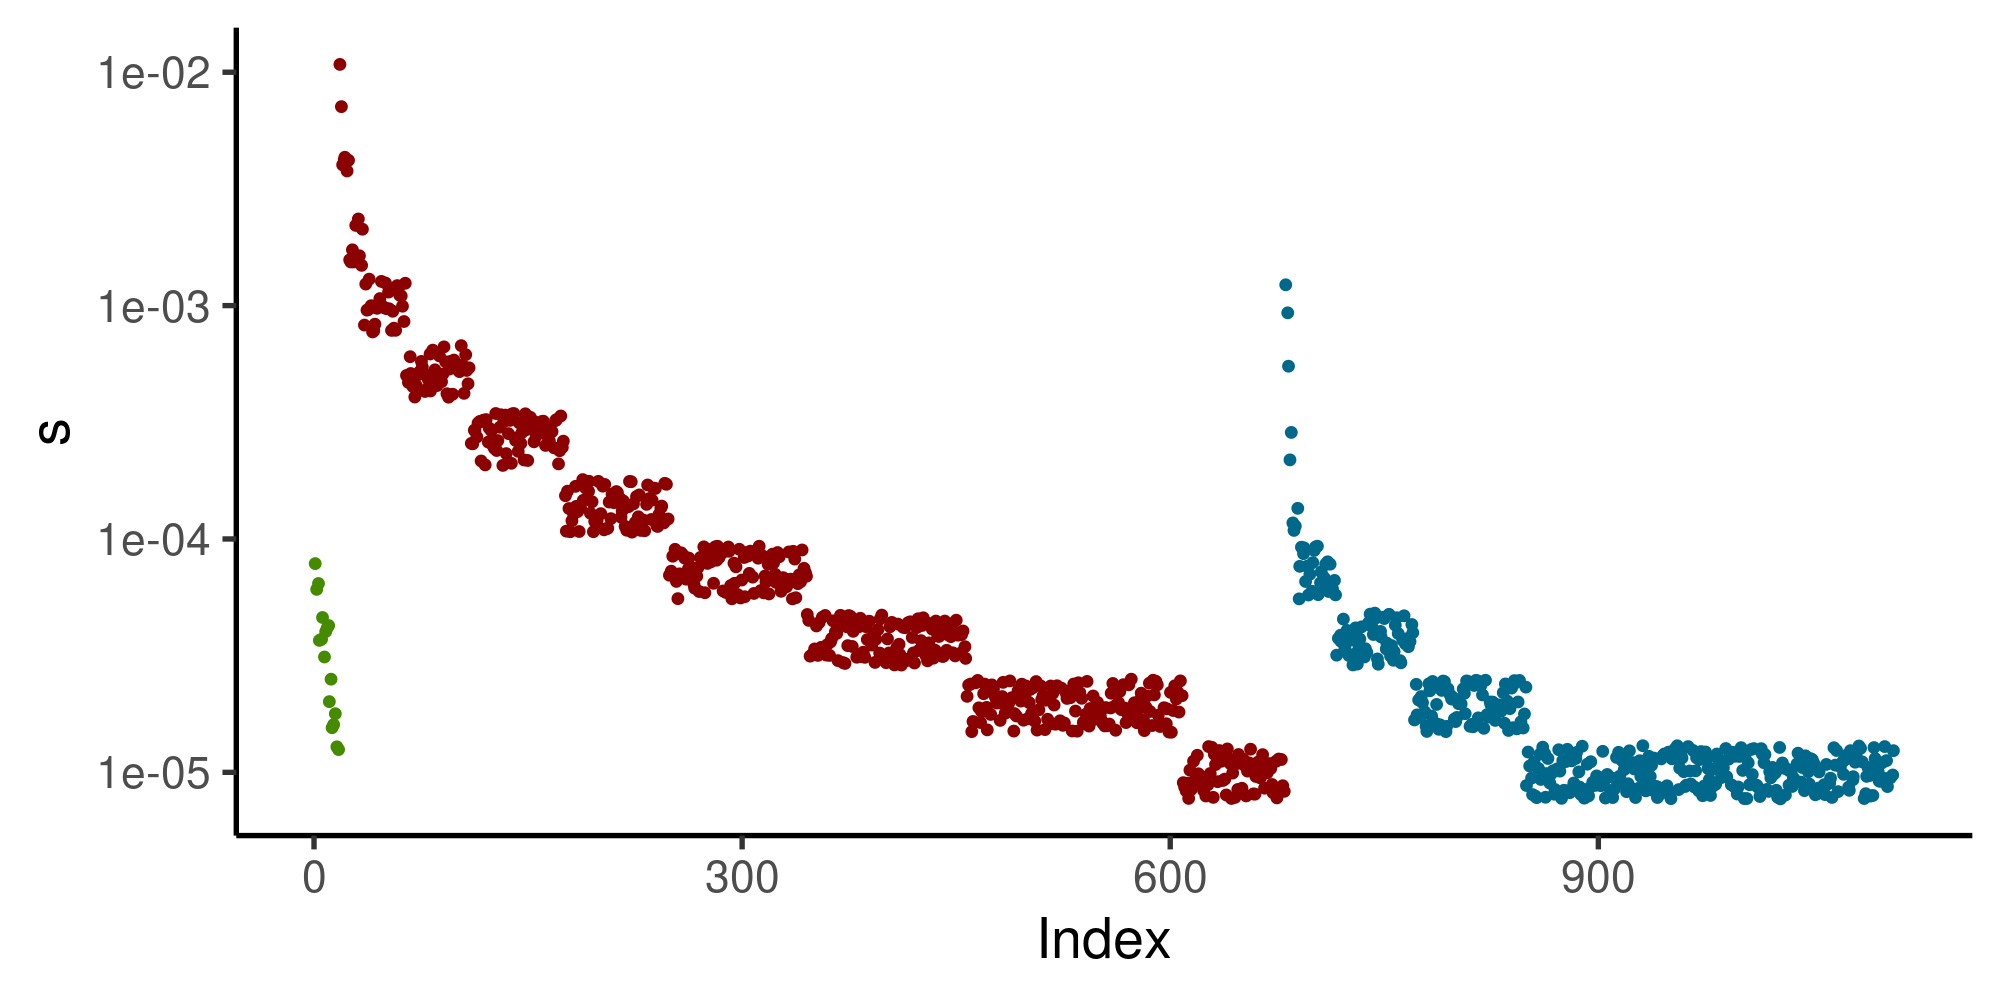

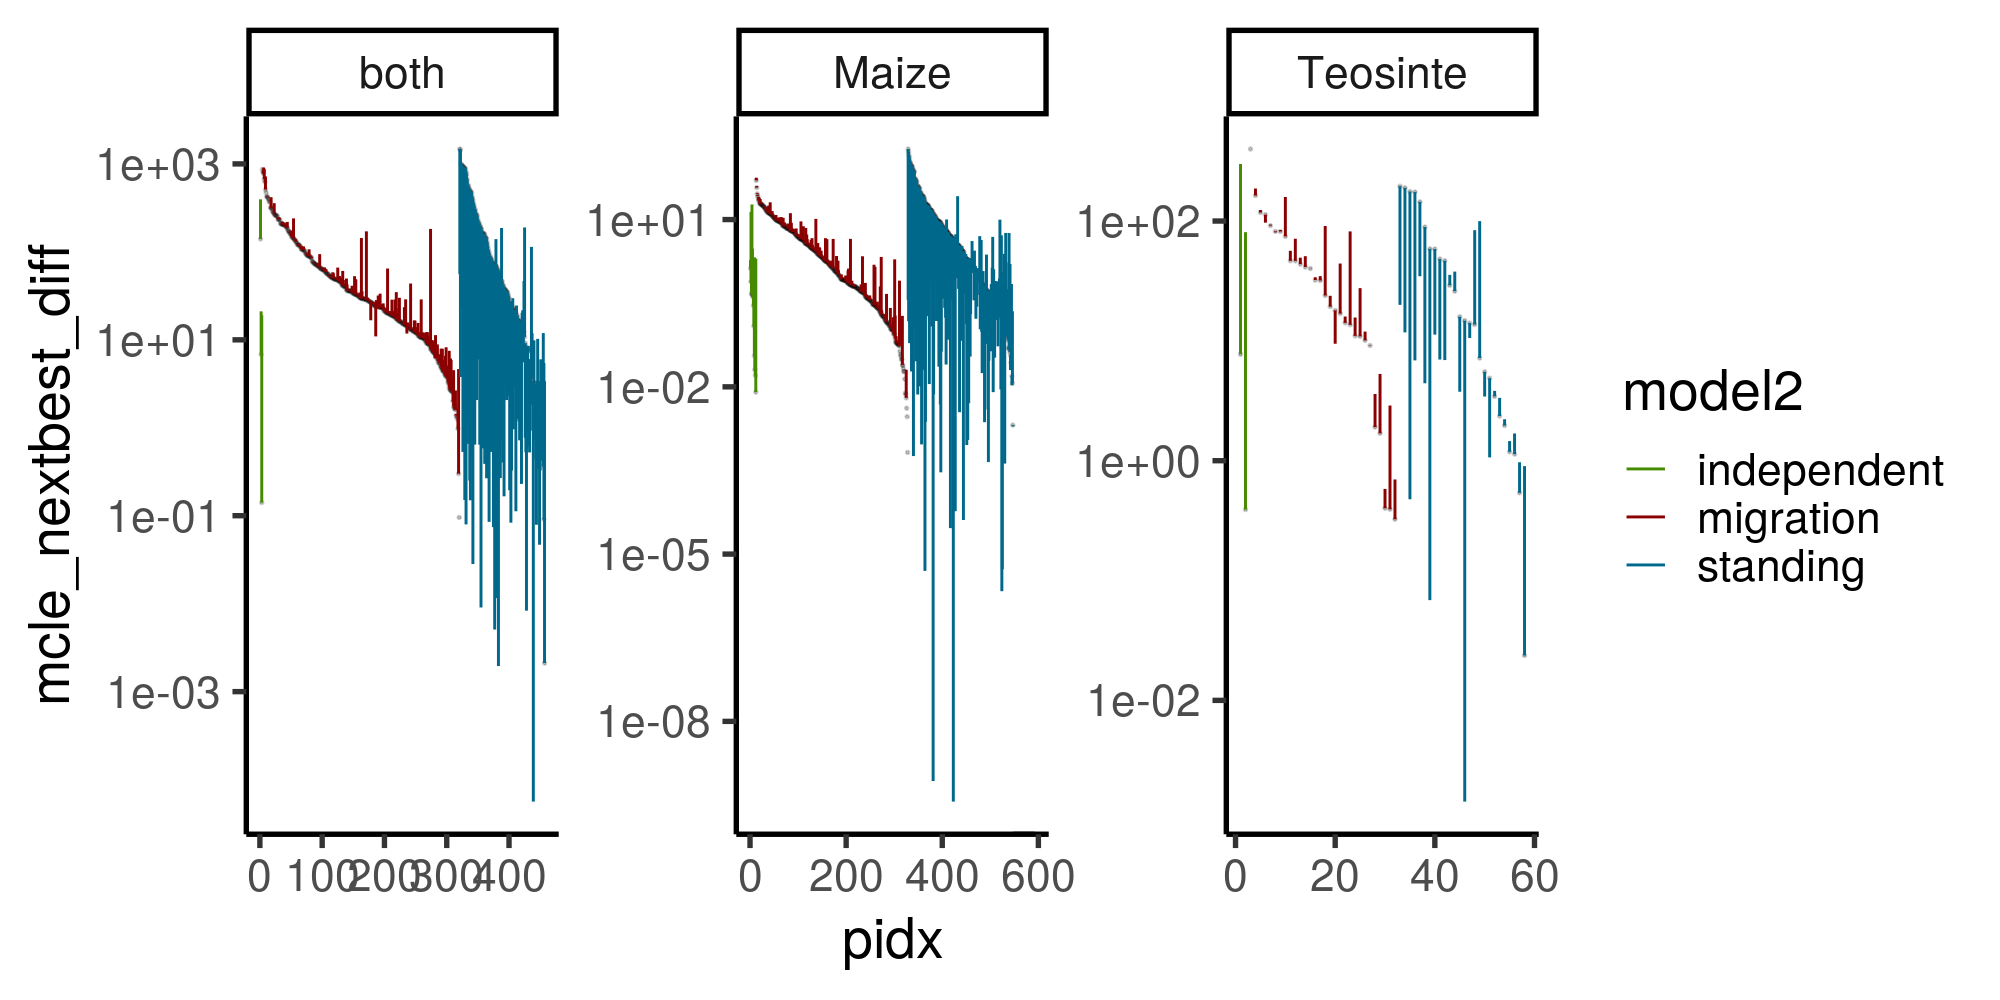

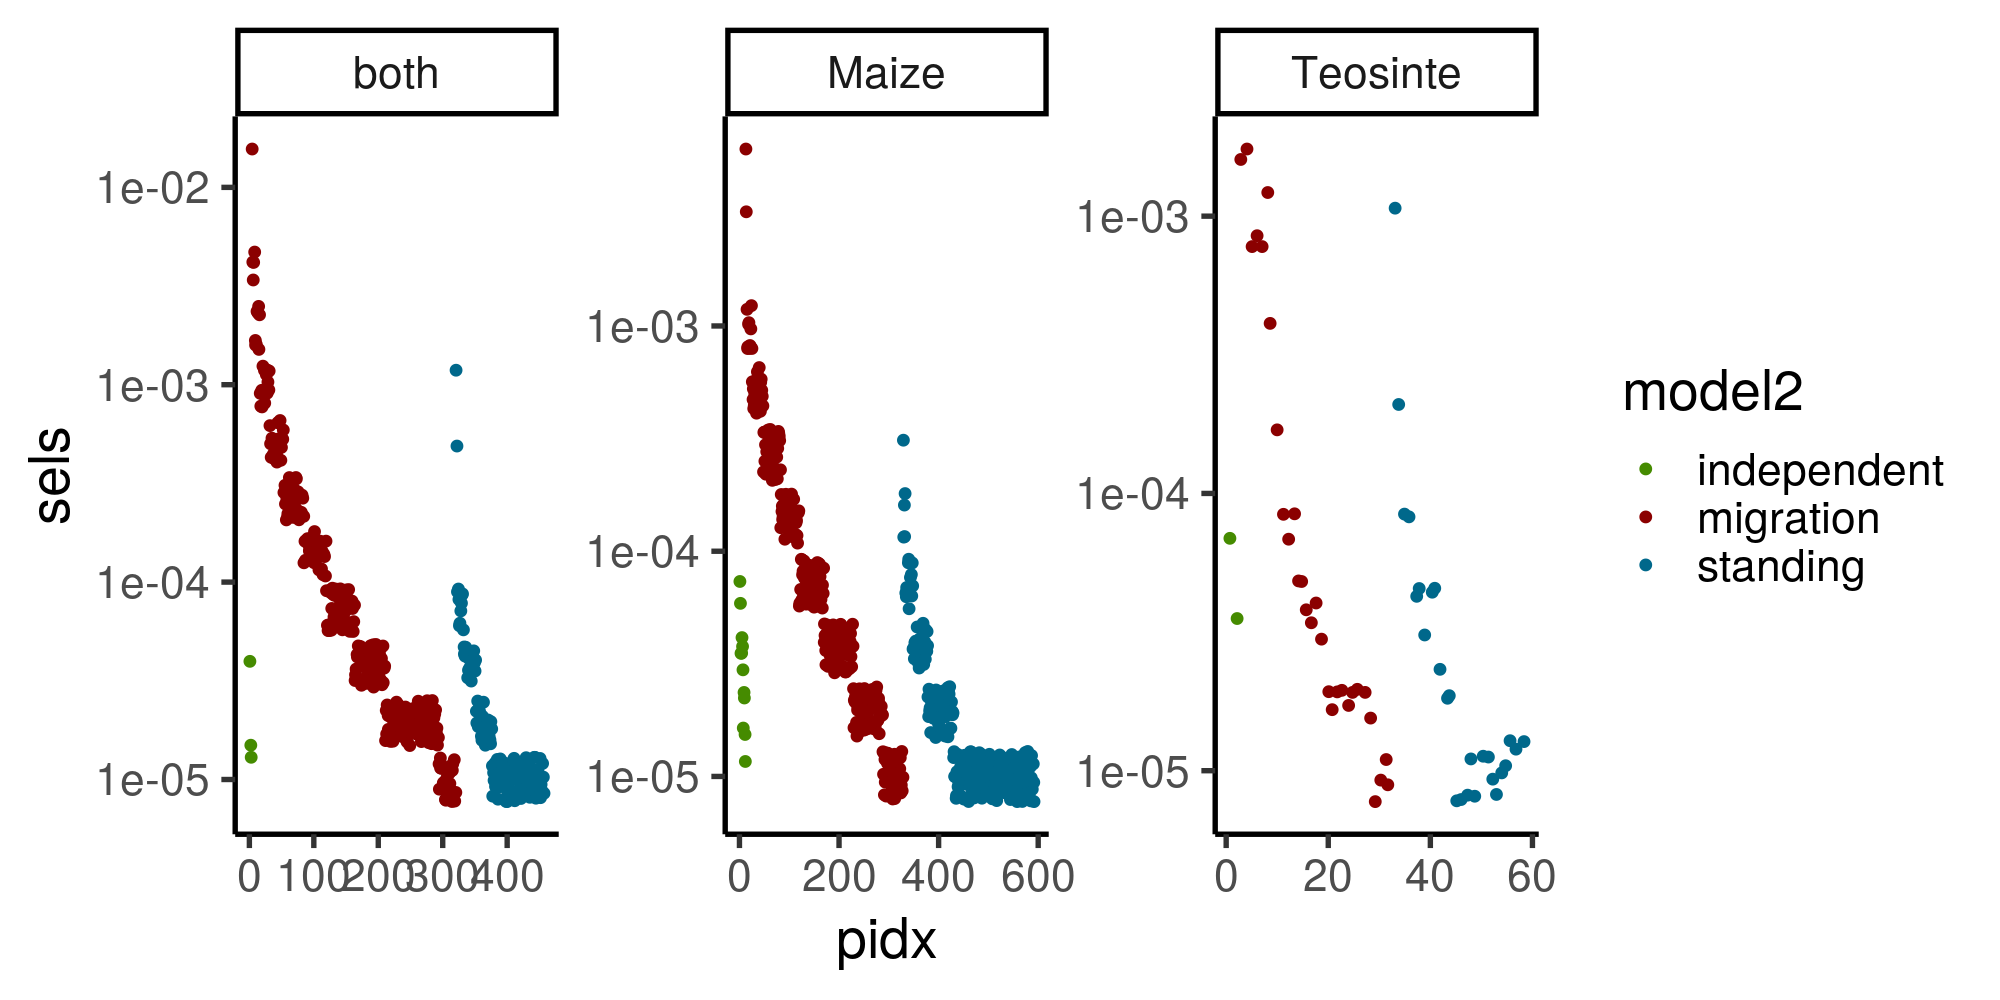

In [11]:

options(repr.plot.width = 10, repr.plot.height = 5, repr.plot.res = 200)
#mode_cols <- c("independent" = "chartreuse4", "migration" = "dodgerblue", "standing" = "purple")
sel_cols <- c("neutral" = "salmon4", "independent" = "chartreuse4", "migration" = "darkred", "standing" = "deepskyblue4")


mode_mcle <- 
    top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    mutate(pidx = 1:n())  %>% 
    ggplot() +
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    geom_point(aes(pidx, mcle_nextbest_diff), size = 2, alpha = 1) +
    scale_y_log10() +
    scale_color_manual(values = sel_cols) +
    theme(legend.position = "n") +
    xlab("Index") +
    ylab(expression(Delta[cle]))
mode_mcle


mode_sels <- 
    top_models_df %>% 
    filter(model2 != "neutral")  %>%
    arrange(model2, desc(sels)) %>%
    mutate(pidx=1:n()) %>% 
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter()+
    scale_y_log10() +
    scale_color_manual(values = sel_cols) +
    xlab("Index") +
    ylab("s") +
    labs(color='Mode') +
    theme(legend.position = "n")


mode_mcle
mode_sels

top_models_df %>% 
    filter(model2 != "neutral")  %>%
    mutate(bn_diff =  sqrt((mcle_nextbest_diff - mcle)^2))  %>% 
    arrange(model2, desc(mcle_nextbest_diff)) %>%
    group_by(type) %>% 
    mutate(pidx = 1:n())  %>% 
    ggplot()+
    geom_point(aes(pidx, mcle_nextbest_diff), size = 0.25, alpha = 0.2) +
    geom_segment(aes(x = pidx, xend=pidx, y = mcle, yend = mcle_nextbest_diff, colour = model2)) +
    #geom_point(aes(pidx, mcle), shape = 1, size = 0.5) +
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = sel_cols)

top_models_df %>% 
    filter(model2 != "neutral")  %>%
    arrange(model2, desc(sels)) %>%
    group_by(type) %>% 
    mutate(pidx=1:n()) %>% 
    ggplot(aes(pidx, sels, colour = model2)) +
    geom_jitter()+
    scale_y_log10() +
    facet_wrap(~type, scale = "free") +
    scale_color_manual(values = sel_cols)


model2      n()
1 independent  17
2 migration   663
3 neutral     627
4 standing    427

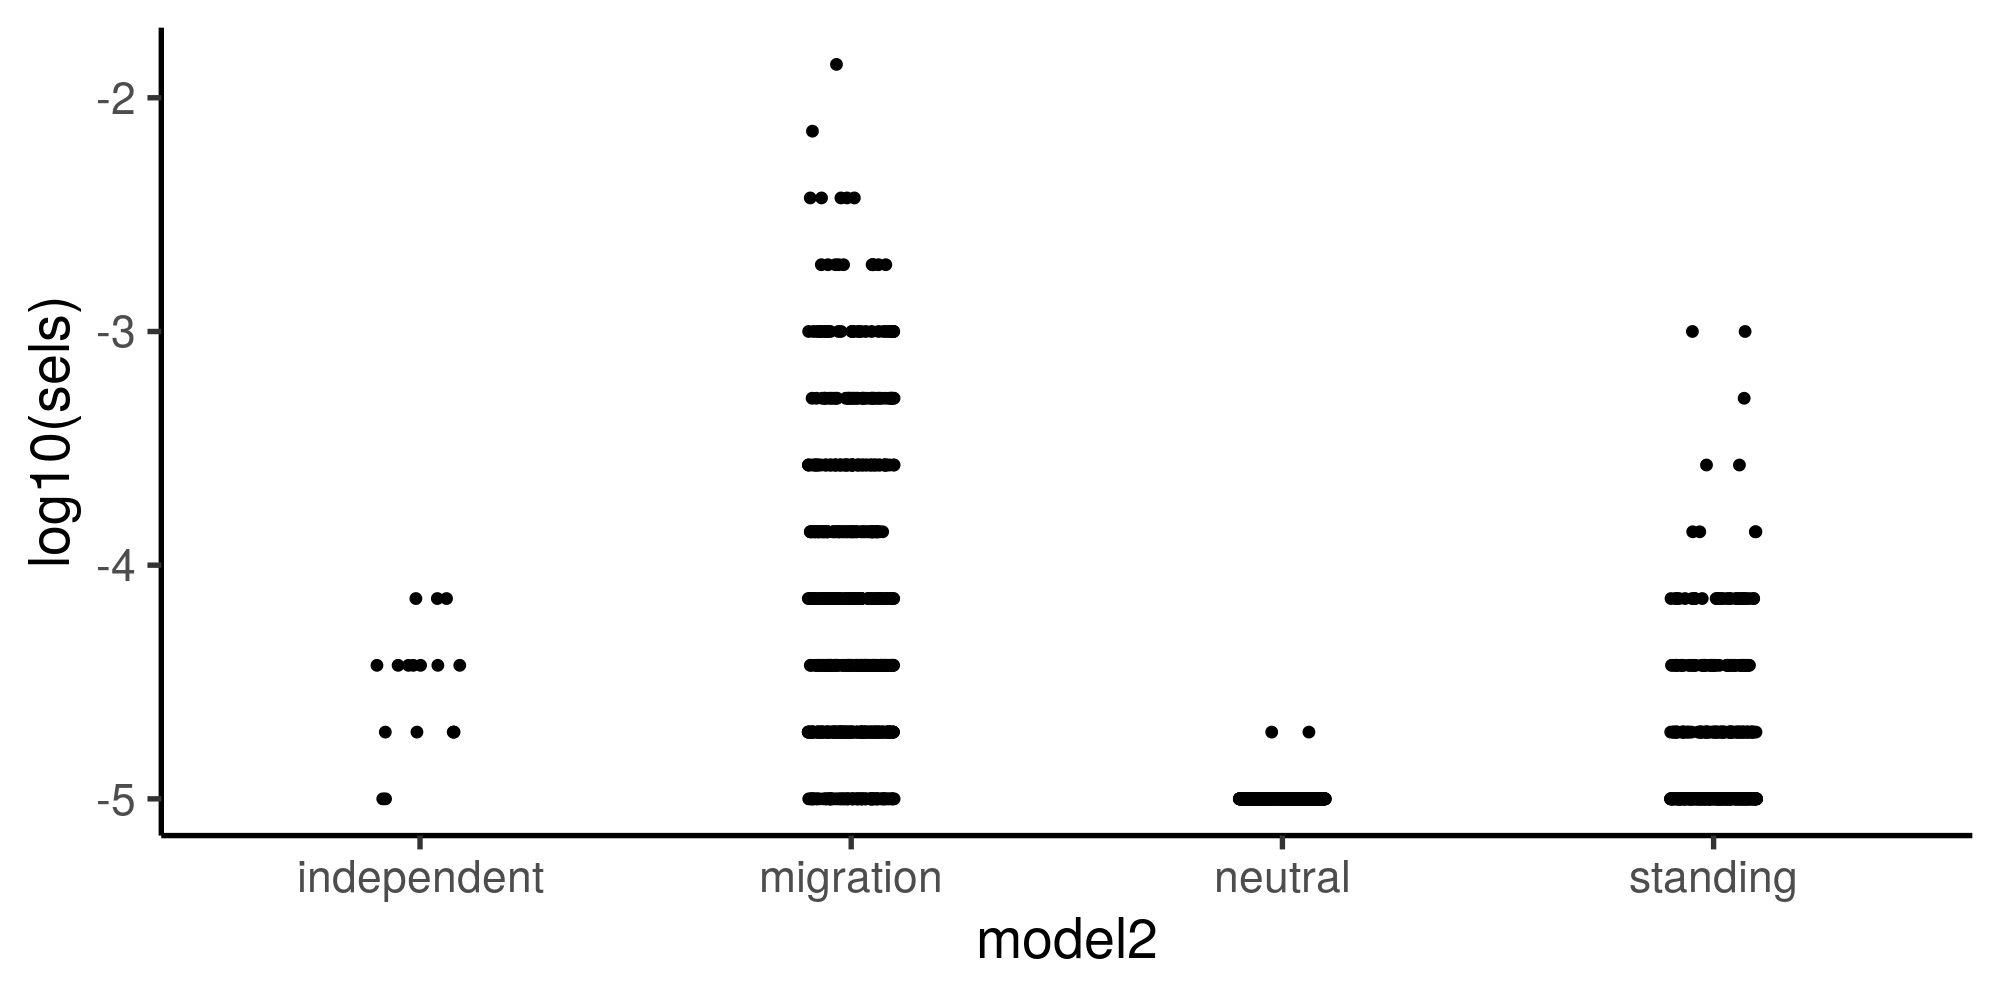

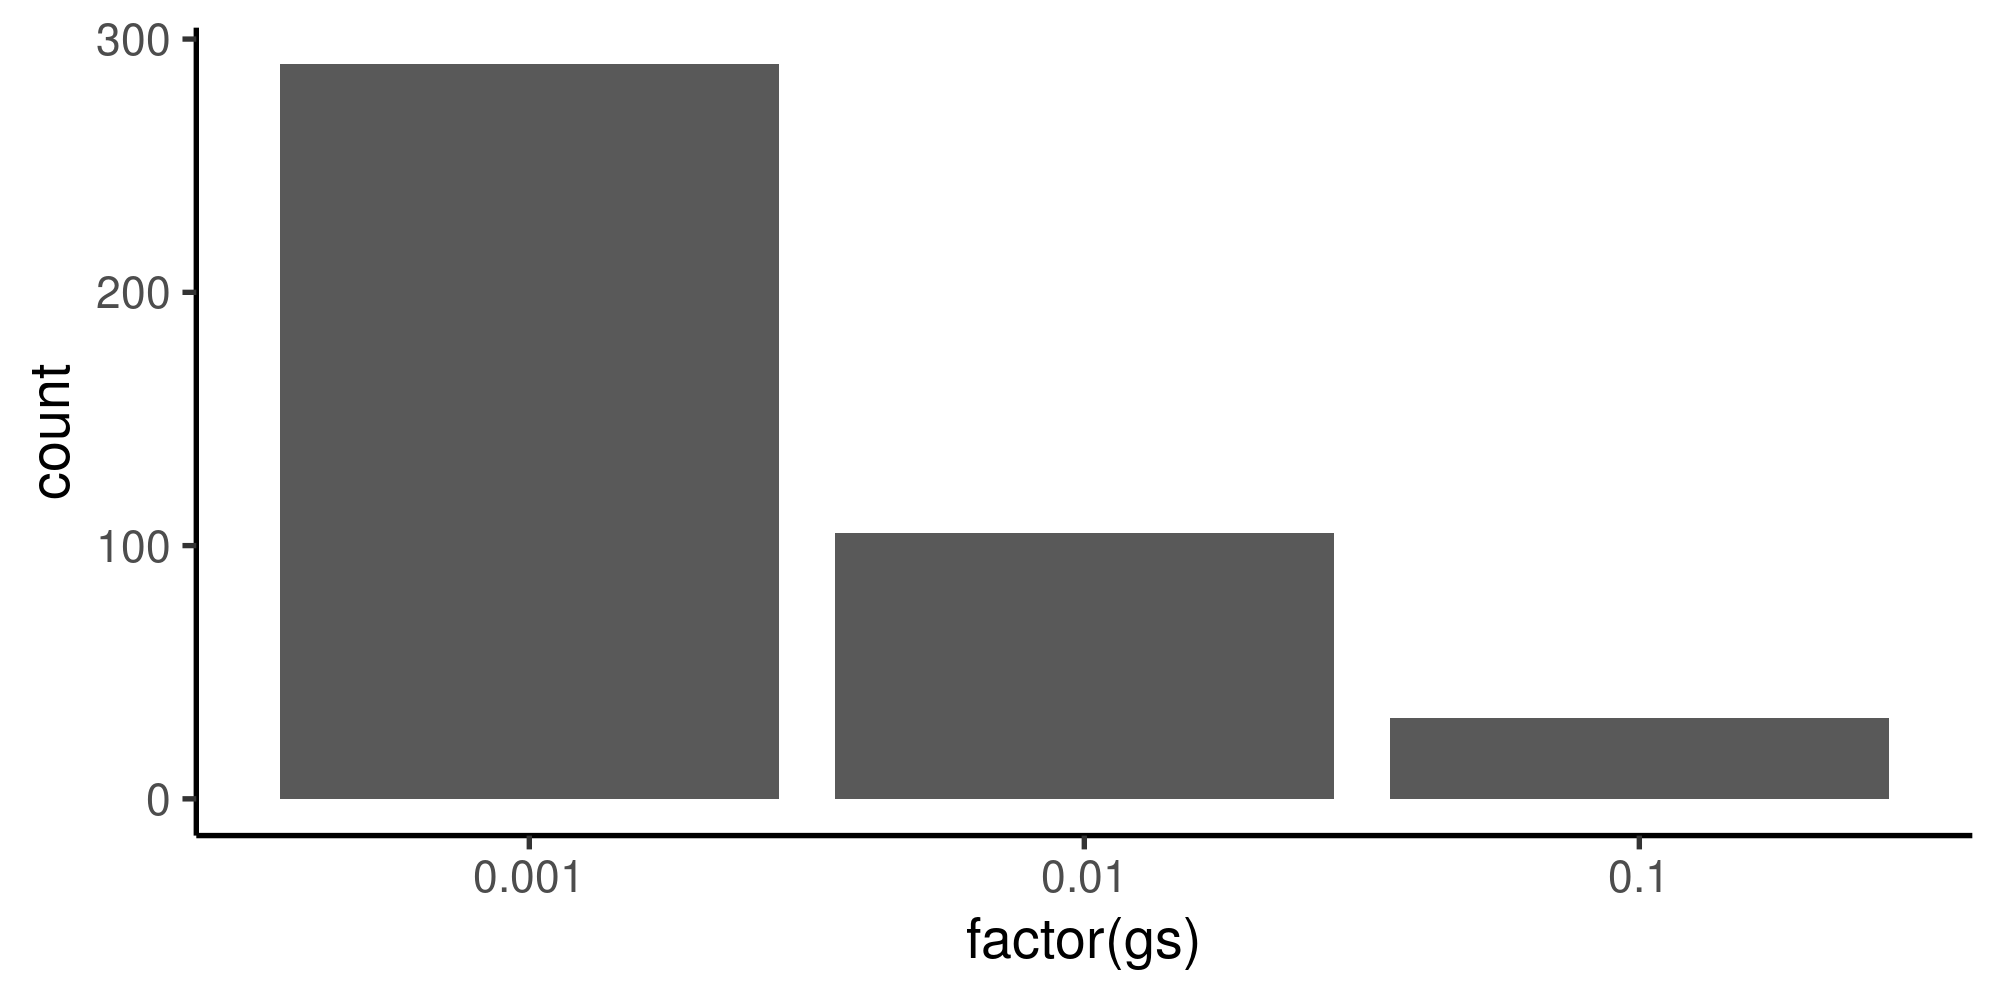

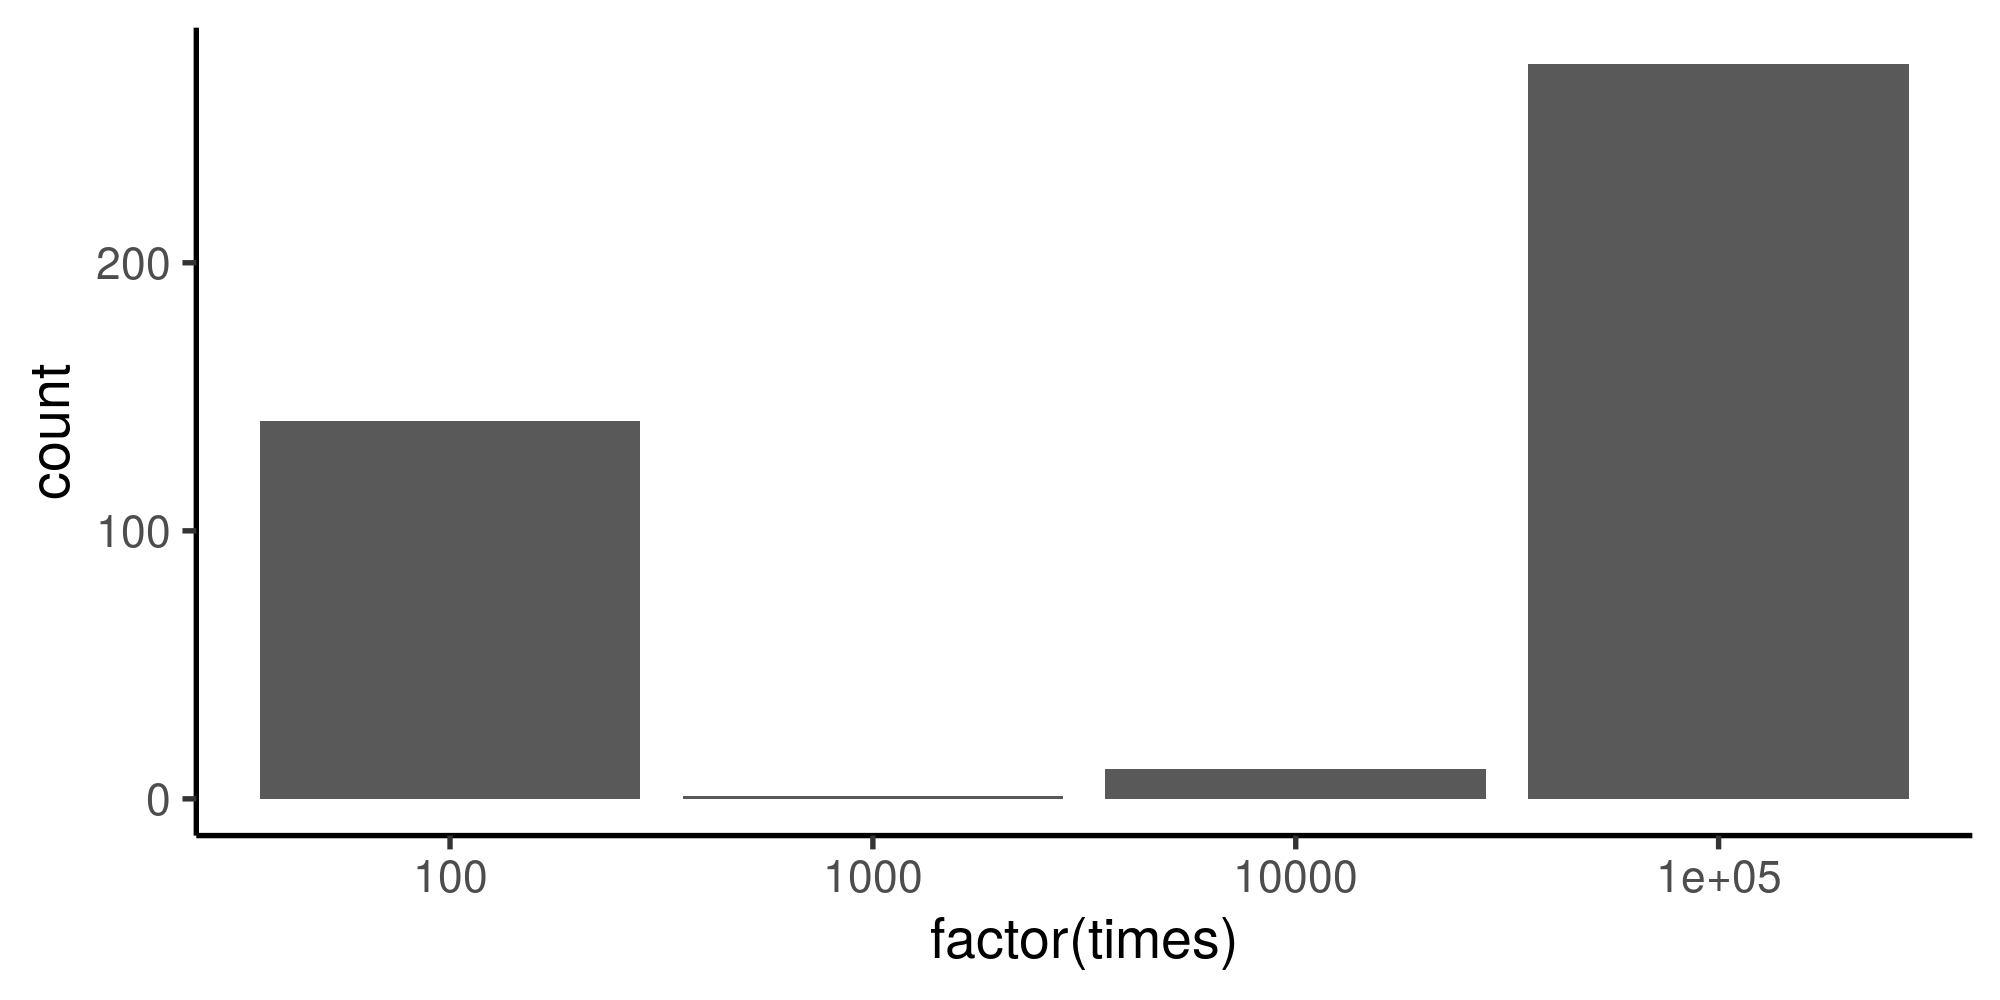

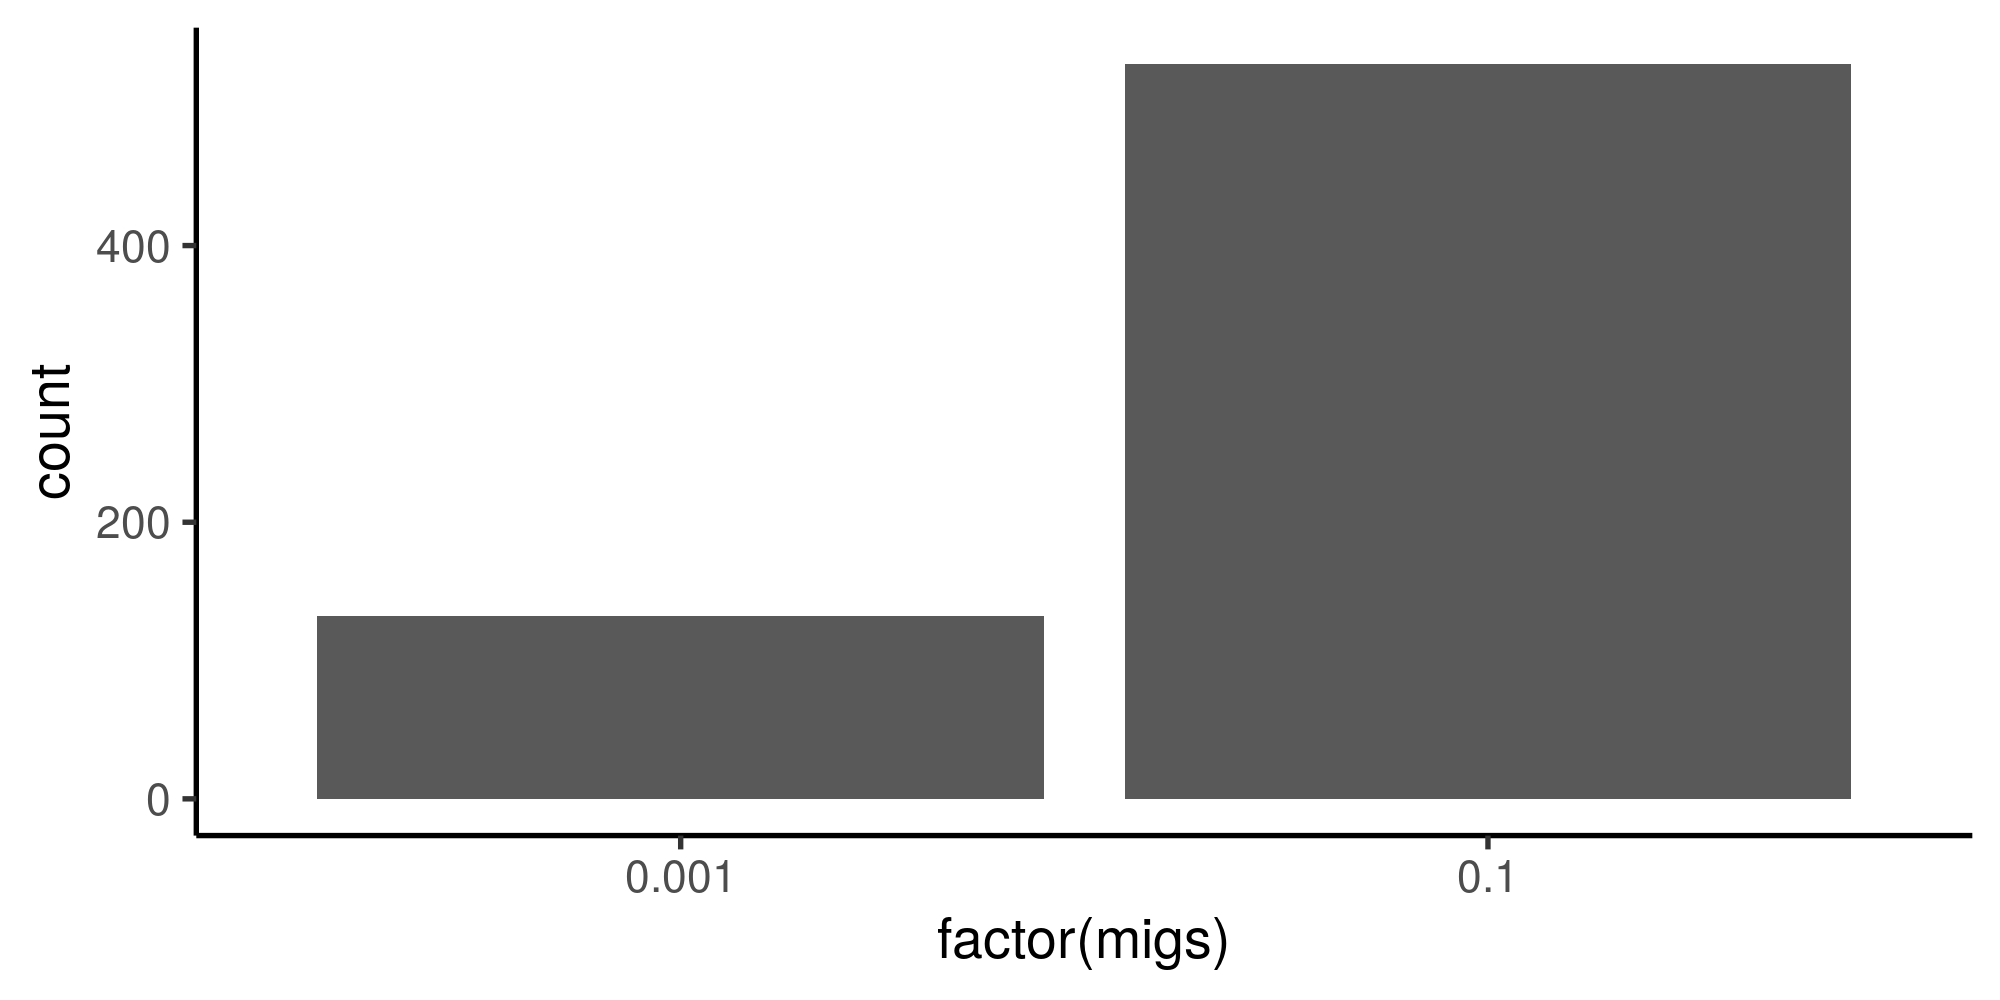

`geom_smooth()` using method = 'loess' and formula 'y ~ x'

Warning message:
“Removed 26 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 26 rows containing missing values (geom_point).”


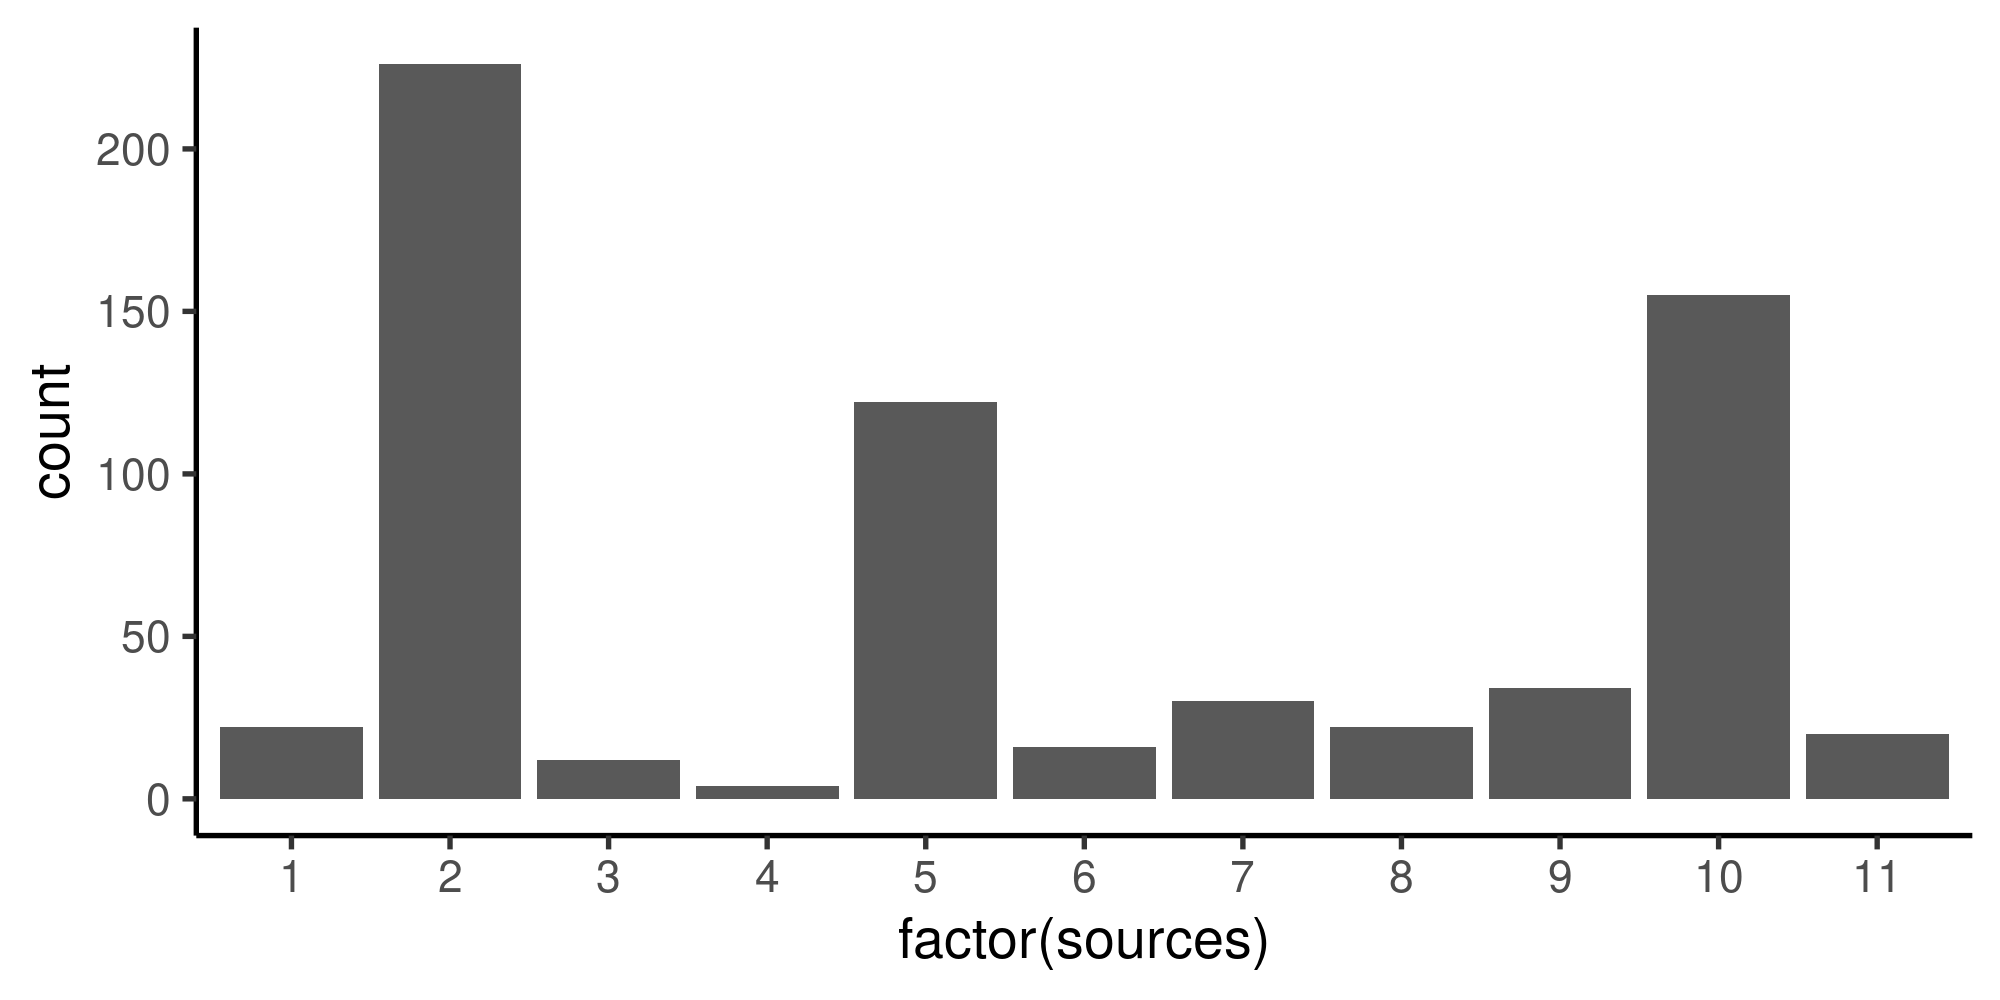

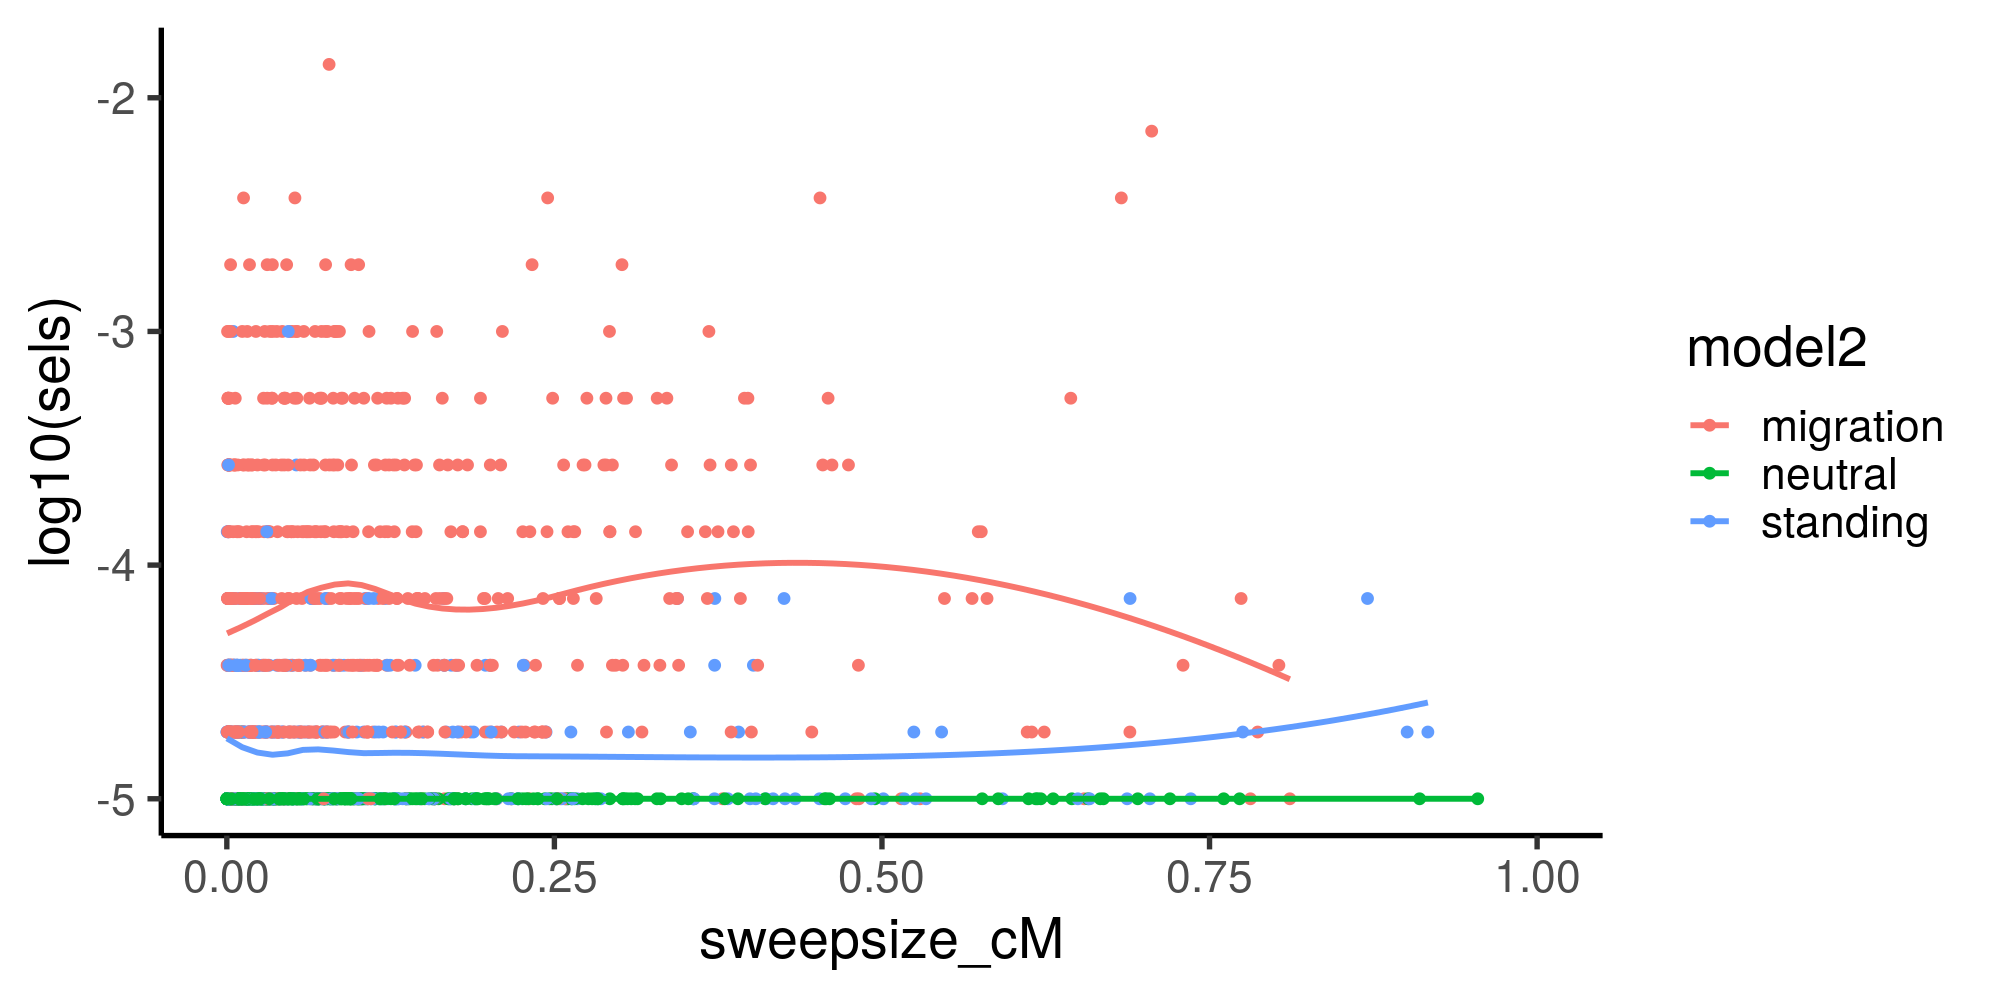

In [12]:


top_models_df %>%
    group_by(model2) %>% 
    summarise(n())

top_models_df %>% 
    ggplot(aes(model2, log10(sels))) +
    geom_jitter(width = 0.1, height = 0)

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(gs))) +
    geom_bar(stat = "count")

top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(factor(times))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(migs))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(sources))) +
    geom_bar(stat = "count")


top_models_df %>%
    filter(model2 != "independent") %>% 
    ggplot(aes(sweepsize_cM, log10(sels), colour = model2)) +
    geom_point() +
    geom_smooth(se = F) +
    xlim(0, 1)


`geom_smooth()` using formula 'y ~ x'



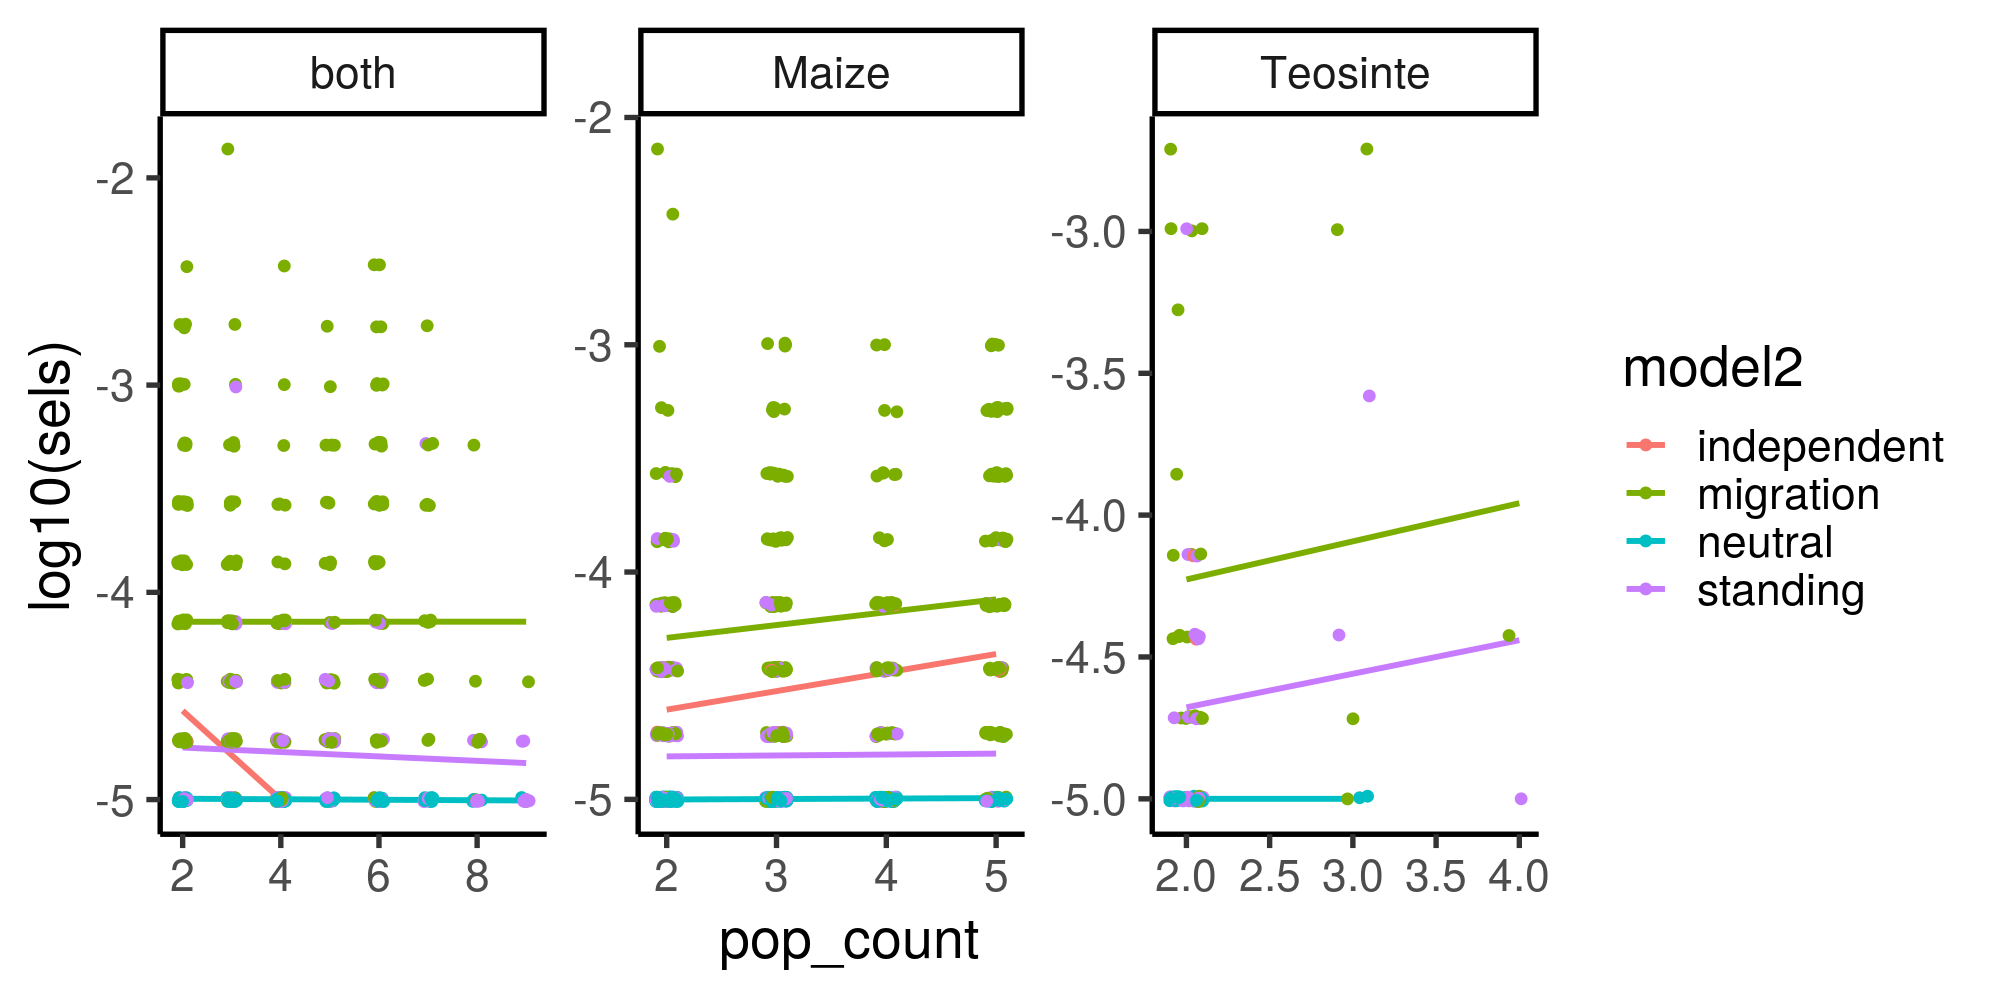

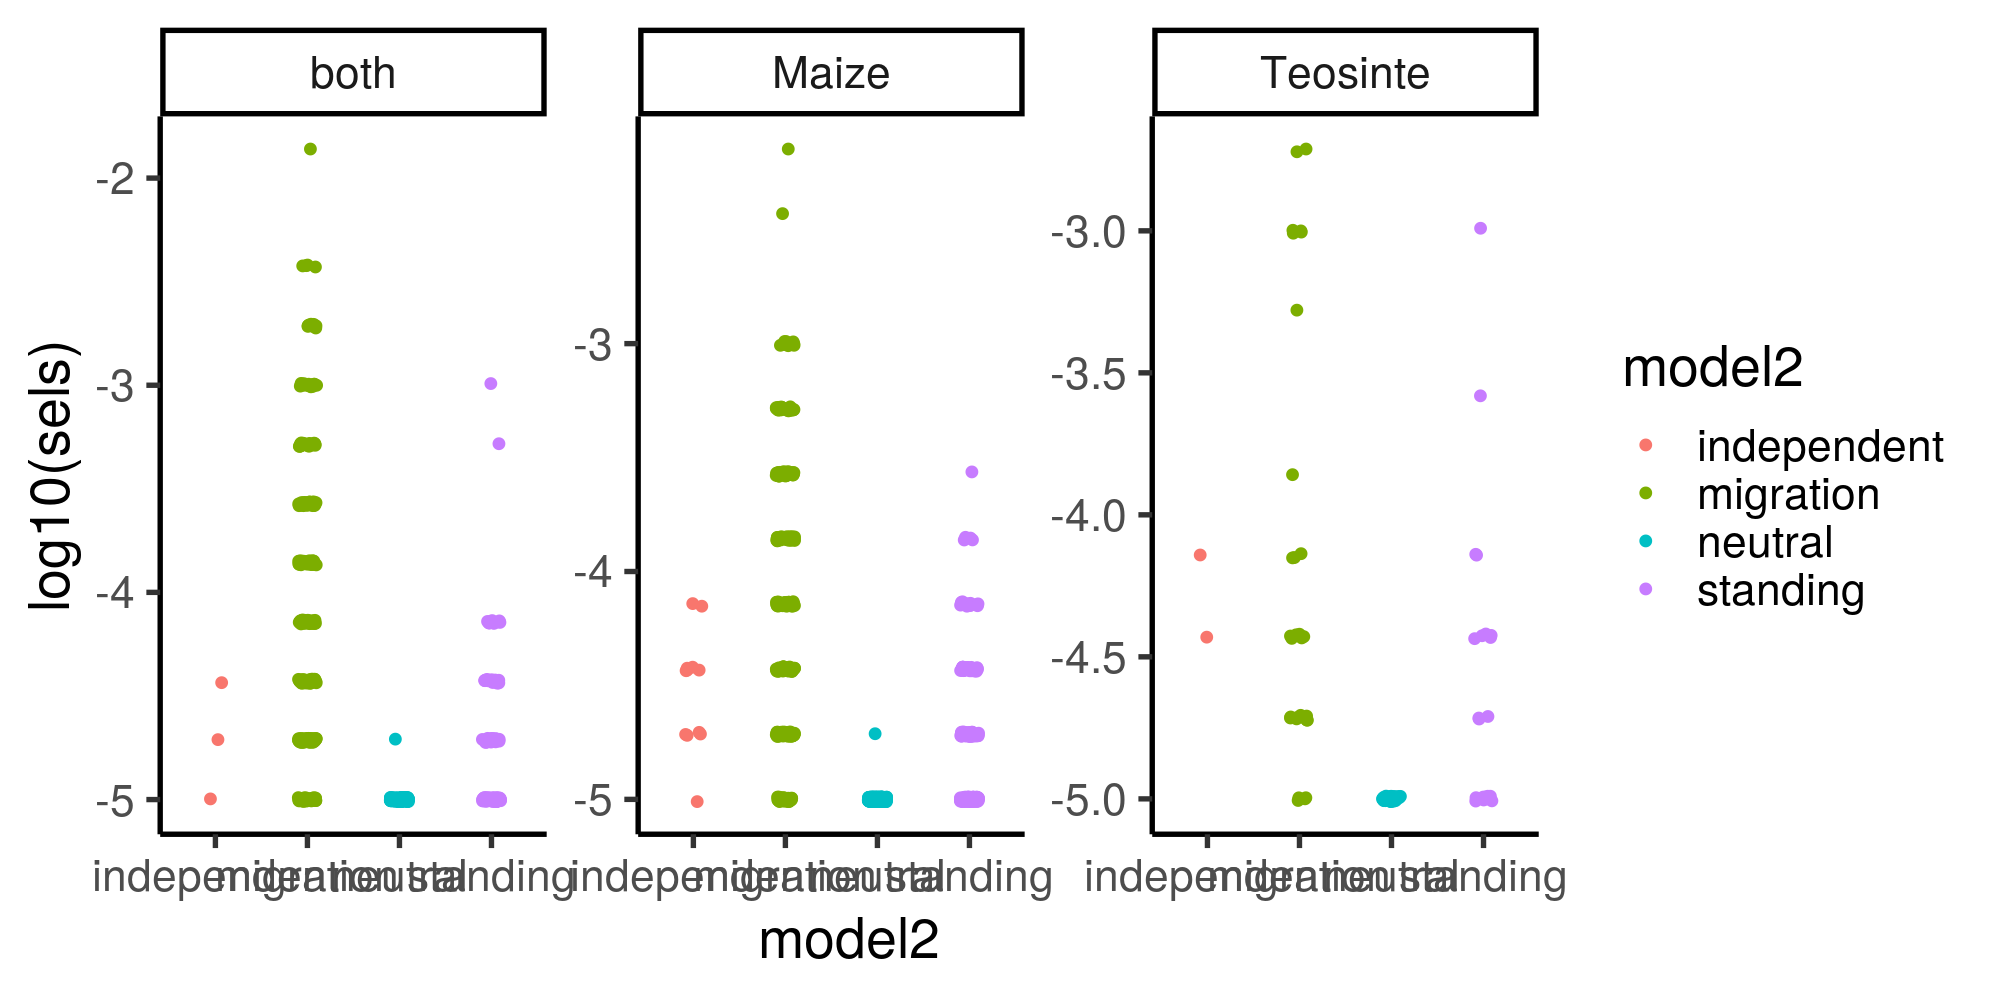

In [13]:
top_models_df %>%
    ggplot(aes(pop_count, log10(sels), colour = model2)) +
    geom_smooth(method = "lm", se = F) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")


top_models_df %>%
    ggplot(aes(model2, log10(sels), colour = model2)) +
    geom_jitter(height = 0.01, width = 0.1) +
    facet_wrap(~type, scale = "free")

Warning message in cor.test.default(top_models_df$sweepsize_cM, top_models_df$n_snps, :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  top_models_df$sweepsize_cM and top_models_df$n_snps
S = 221323837, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.745298 


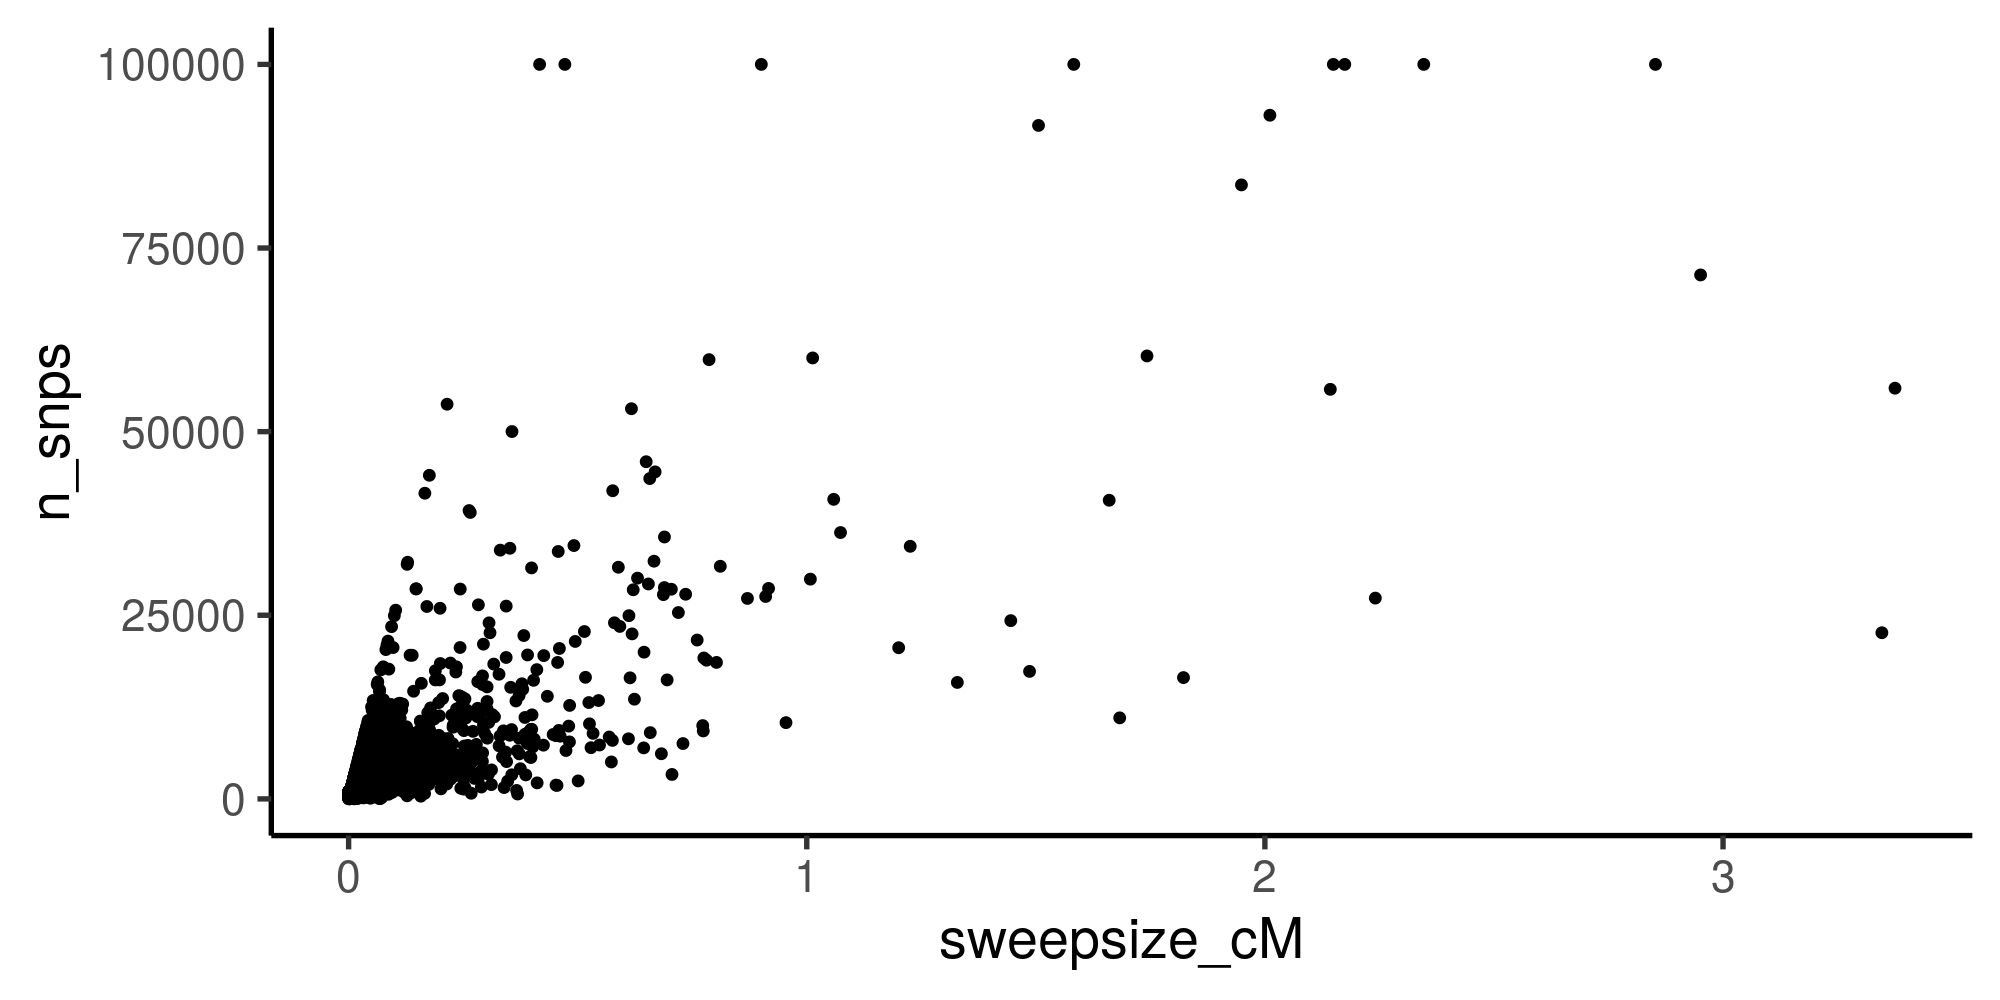

In [14]:
top_models_df %>% 
    ggplot(aes(sweepsize_cM, n_snps)) +
    geom_point()
    #geom_hline(yintercept = c(1e3, 1e4))

cor.test(top_models_df$sweepsize_cM, top_models_df$n_snps, method = "spear")

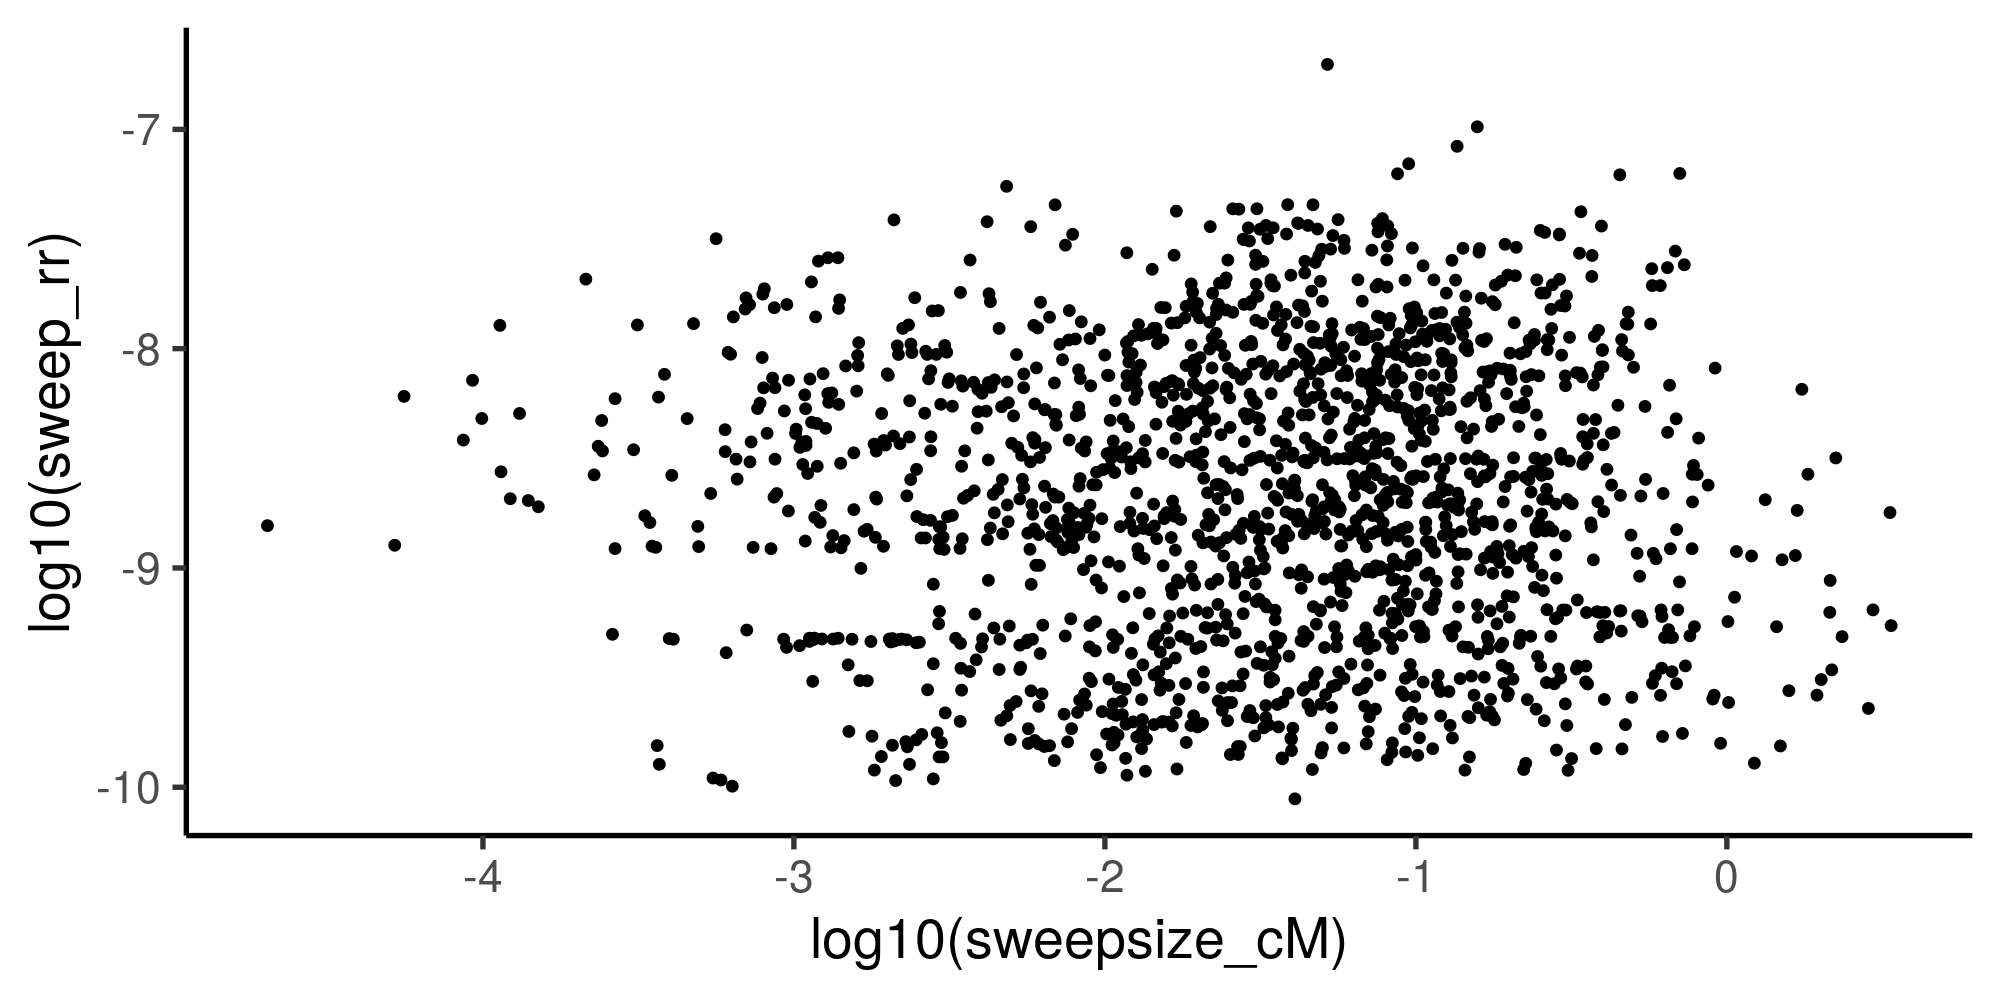

In [15]:
top_models_df %>% 
    ggplot(aes(log10(sweepsize_cM), log10(sweep_rr))) +
    geom_point()

[1] 18

[1] "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start160869233_end161520782_pops1-3-4-5-11.txt" 
 [2] "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start184914360_end185055309_pops4-7.txt"        
 [3] "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start246169953_end246246355_pops3-10.txt"       
 [4] "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start268763990_end268850624_pops1-8.txt"        
 [5] "../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start31254656_end31477475_pops4-10.txt"         
 [6] "../data/rdmc/fitted/v5--sweep_chr2--0--243675191_start103780641_end104314482_pops4-10.txt"       
 [7] "../data/rdmc/fitted/v5--sweep_chr2--0--243675191_start53855302_end53998394_pops4-10.txt"         
 [8] "../data/rdmc/fitted/v5--sweep_chr3--0--238017767_start105502784_end106540101_pops5-8-10.txt"     
 [9] "../data/rdmc/fitted/v5--sweep_chr4--0--250330460_start171636787_end171851851_pops1-2-3-4-5-8.txt"
[10] "../data/rdmc/fitted/v5--sweep_chr5--0--226353449_start152584158_end152977968_pops8-10-11.txt"    
[11] "../data/rdmc/fitted/v5--sweep_chr6--0--181357234_start108673946_end109060999_pops1-2-3-4-5-7.txt"
[12] "../data/rdmc/fitted/v5--sweep_chr6--0--181357234_start17855671_end21068685_pops1-2-3-4-5-7-8.txt"
[13] "../data/rdmc/fitted/v5--sweep_chr6--0--181357234_start23726739_end24935874_pops2-3-4-5-7-8.txt"  
[14] "../data/rdmc/fitted/v5--sweep_chr6--0--181357234_start52899435_end53024709_pops4-10.txt"         
[15] "../data/rdmc/fitted/v5--sweep_chr7--0--185808916_start72504867_end72768820_pops4-8-10.txt"       
[16] "../data/rdmc/fitted/v5--sweep_chr7--0--185808916_start81161011_end81679948_pops4-10-11.txt"      
[17] "../data/rdmc/fitted/v5--sweep_chr8--0--182411202_start67739169_end68088967_pops3-10.txt"         
[18] "../data/rdmc/fitted/v5--sweep_chr9--0--163004744_start59966603_end60552344_pops1-2-3-4-5-8.txt"

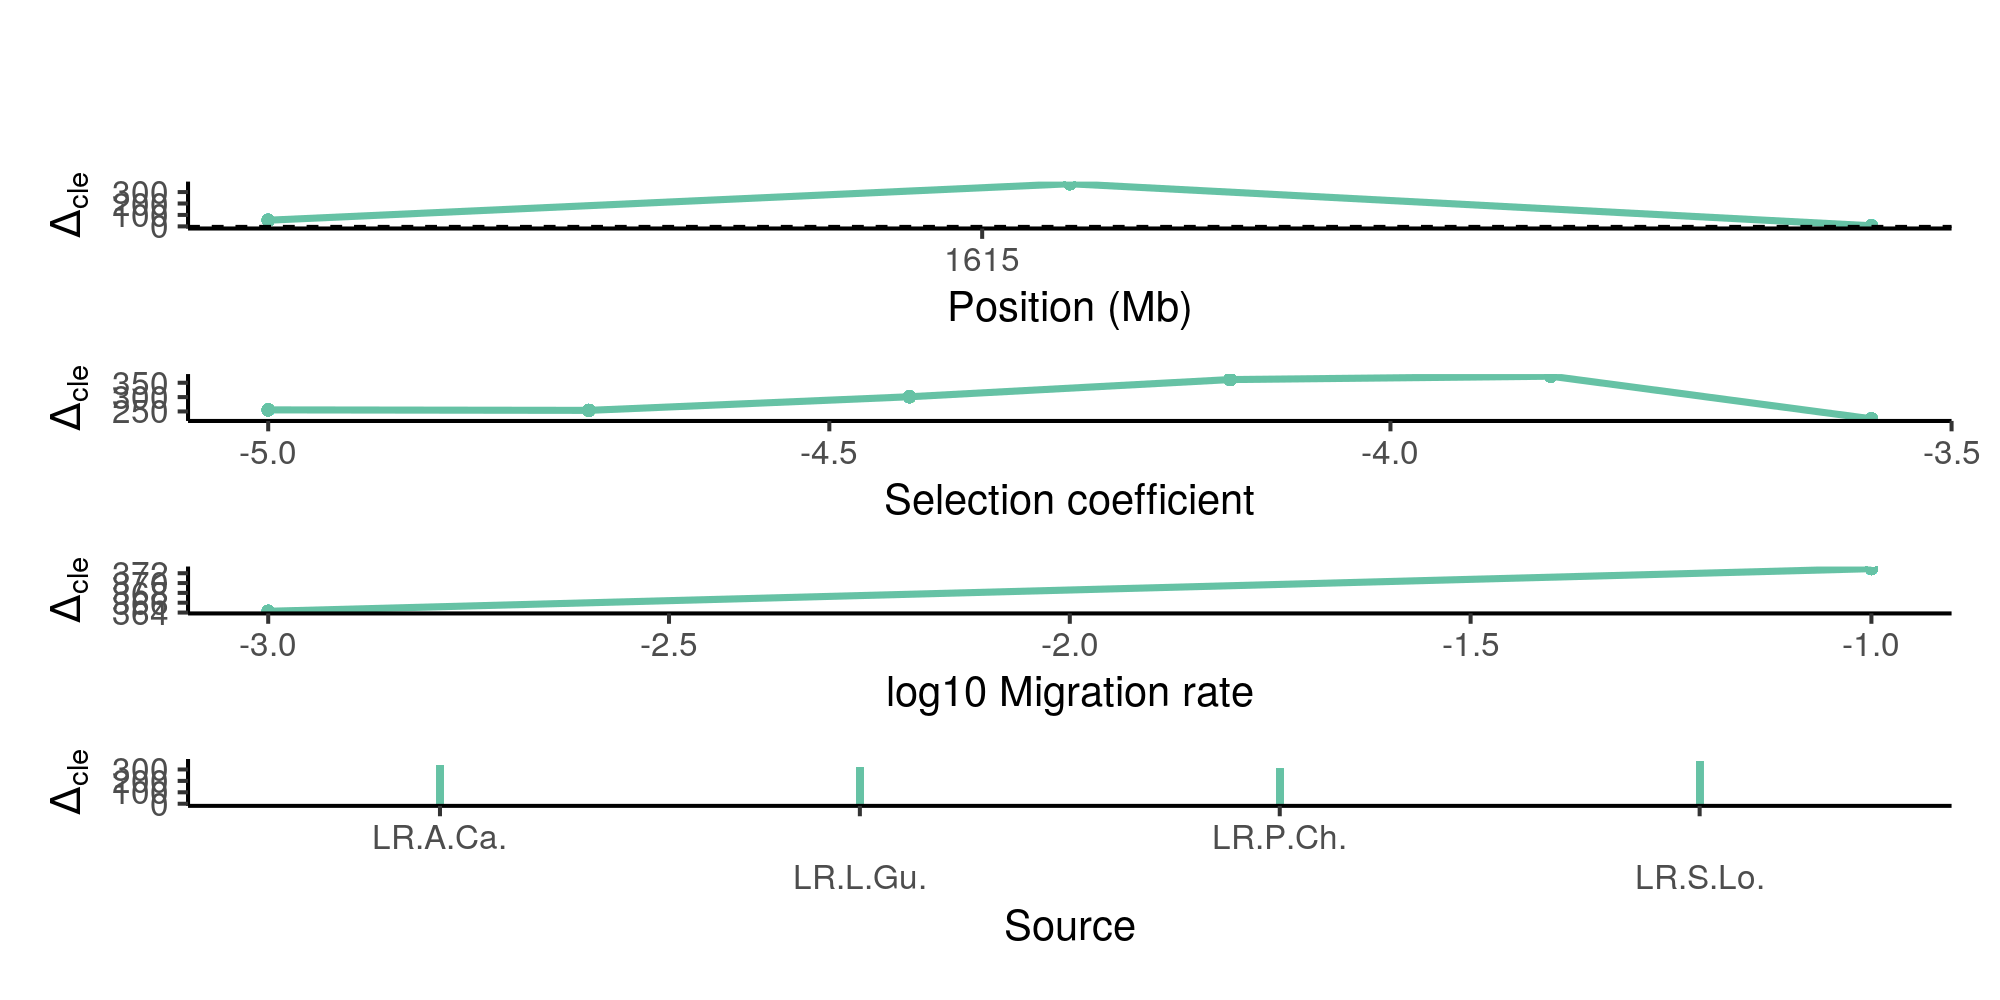

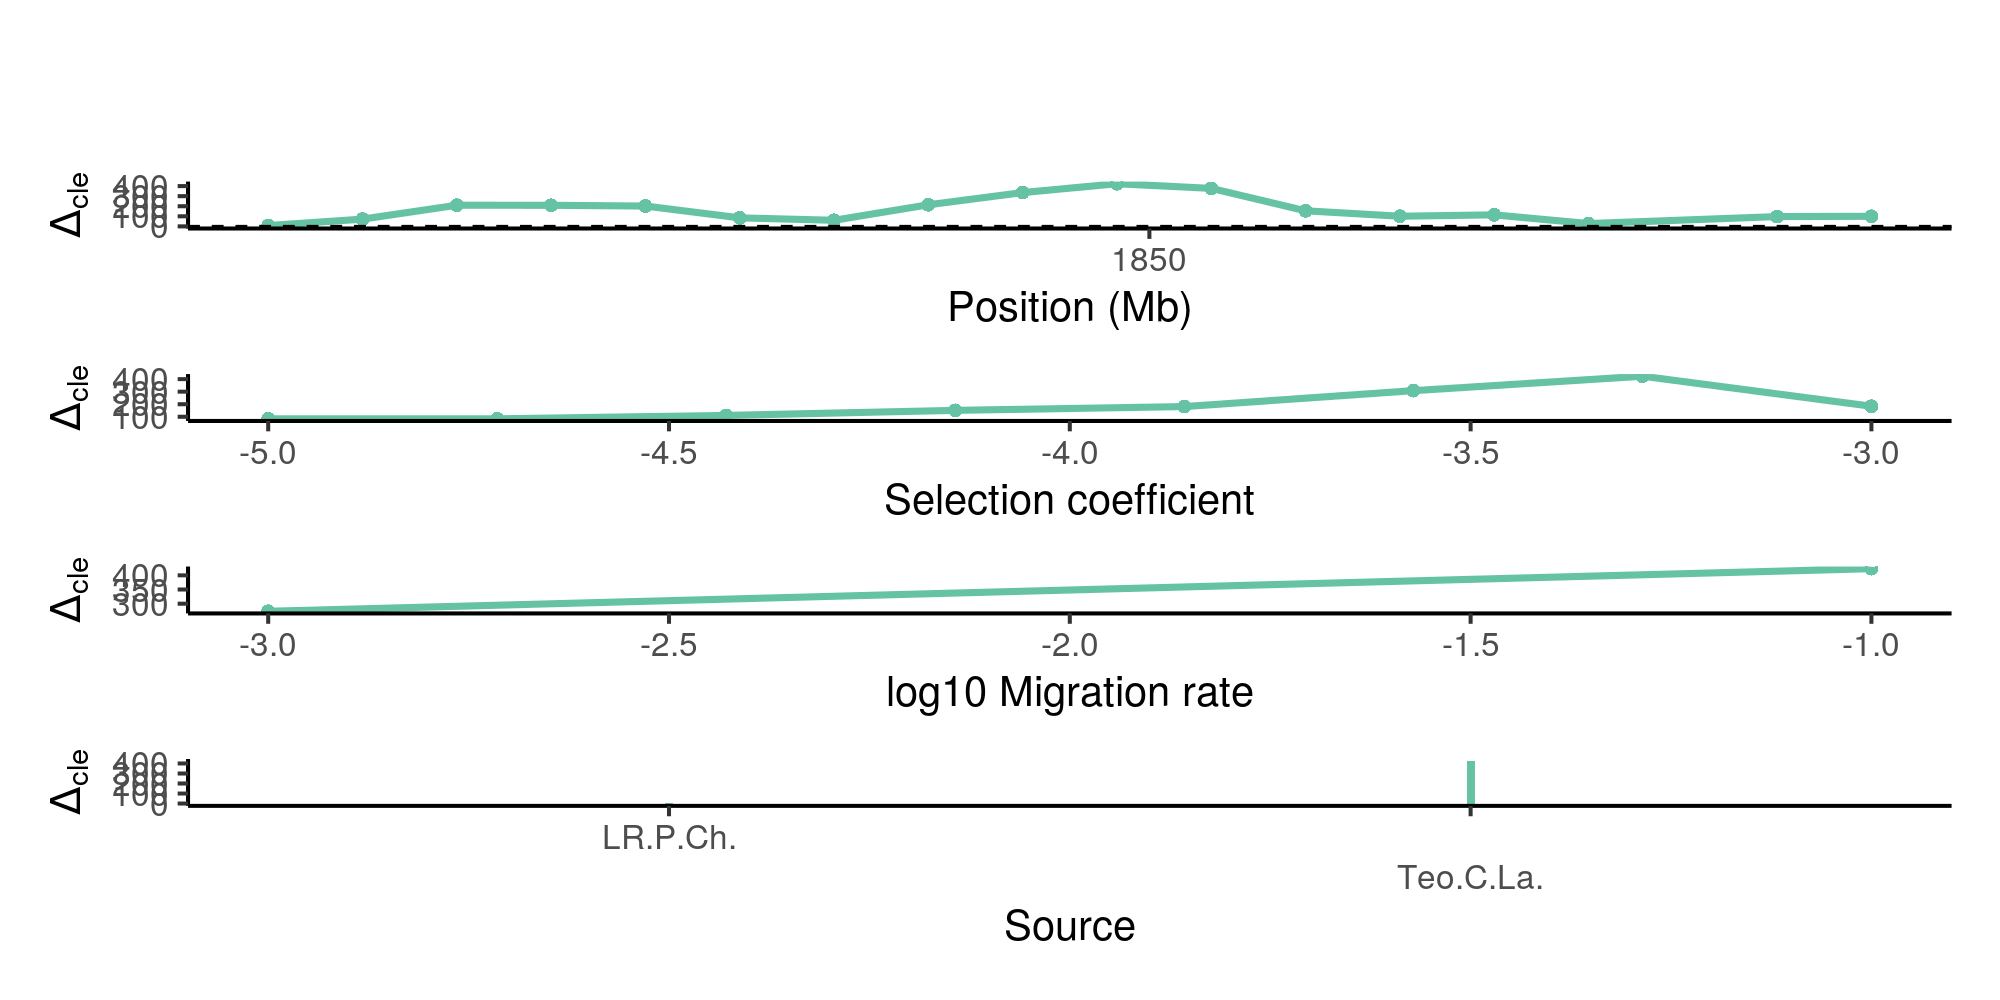

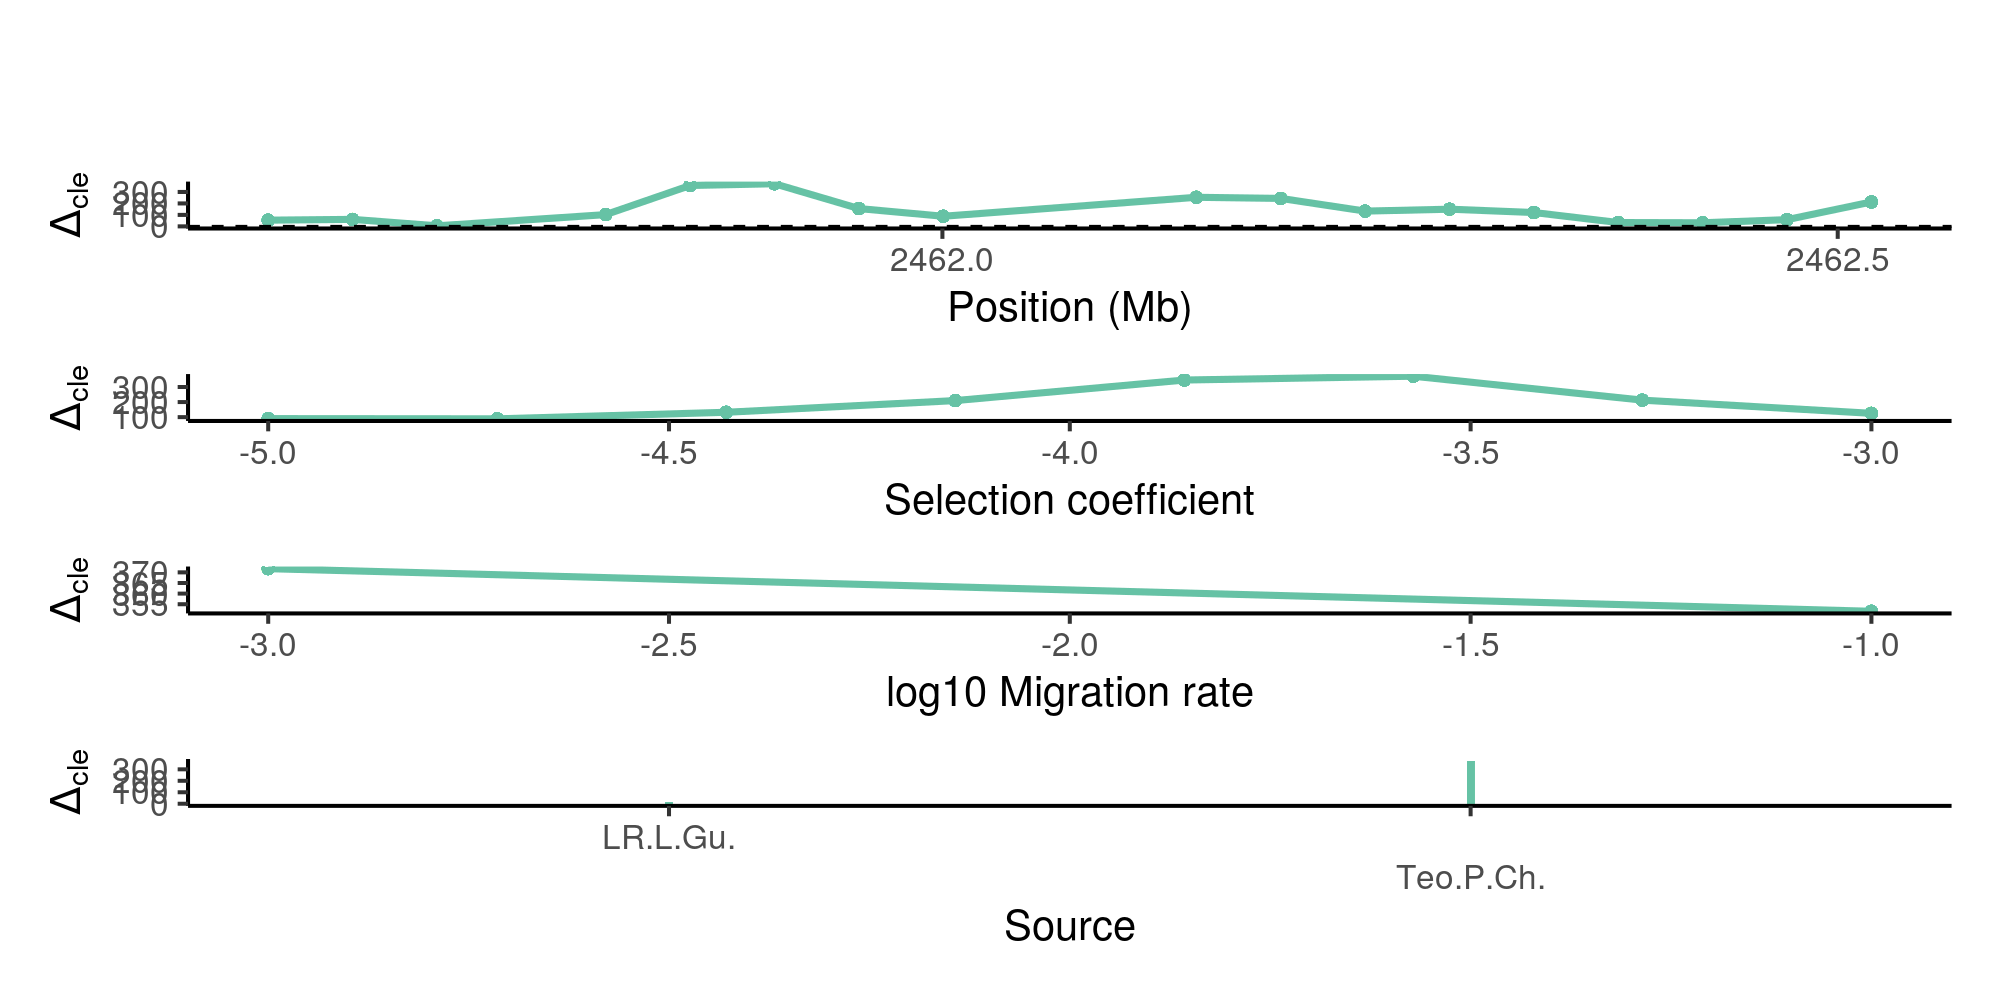

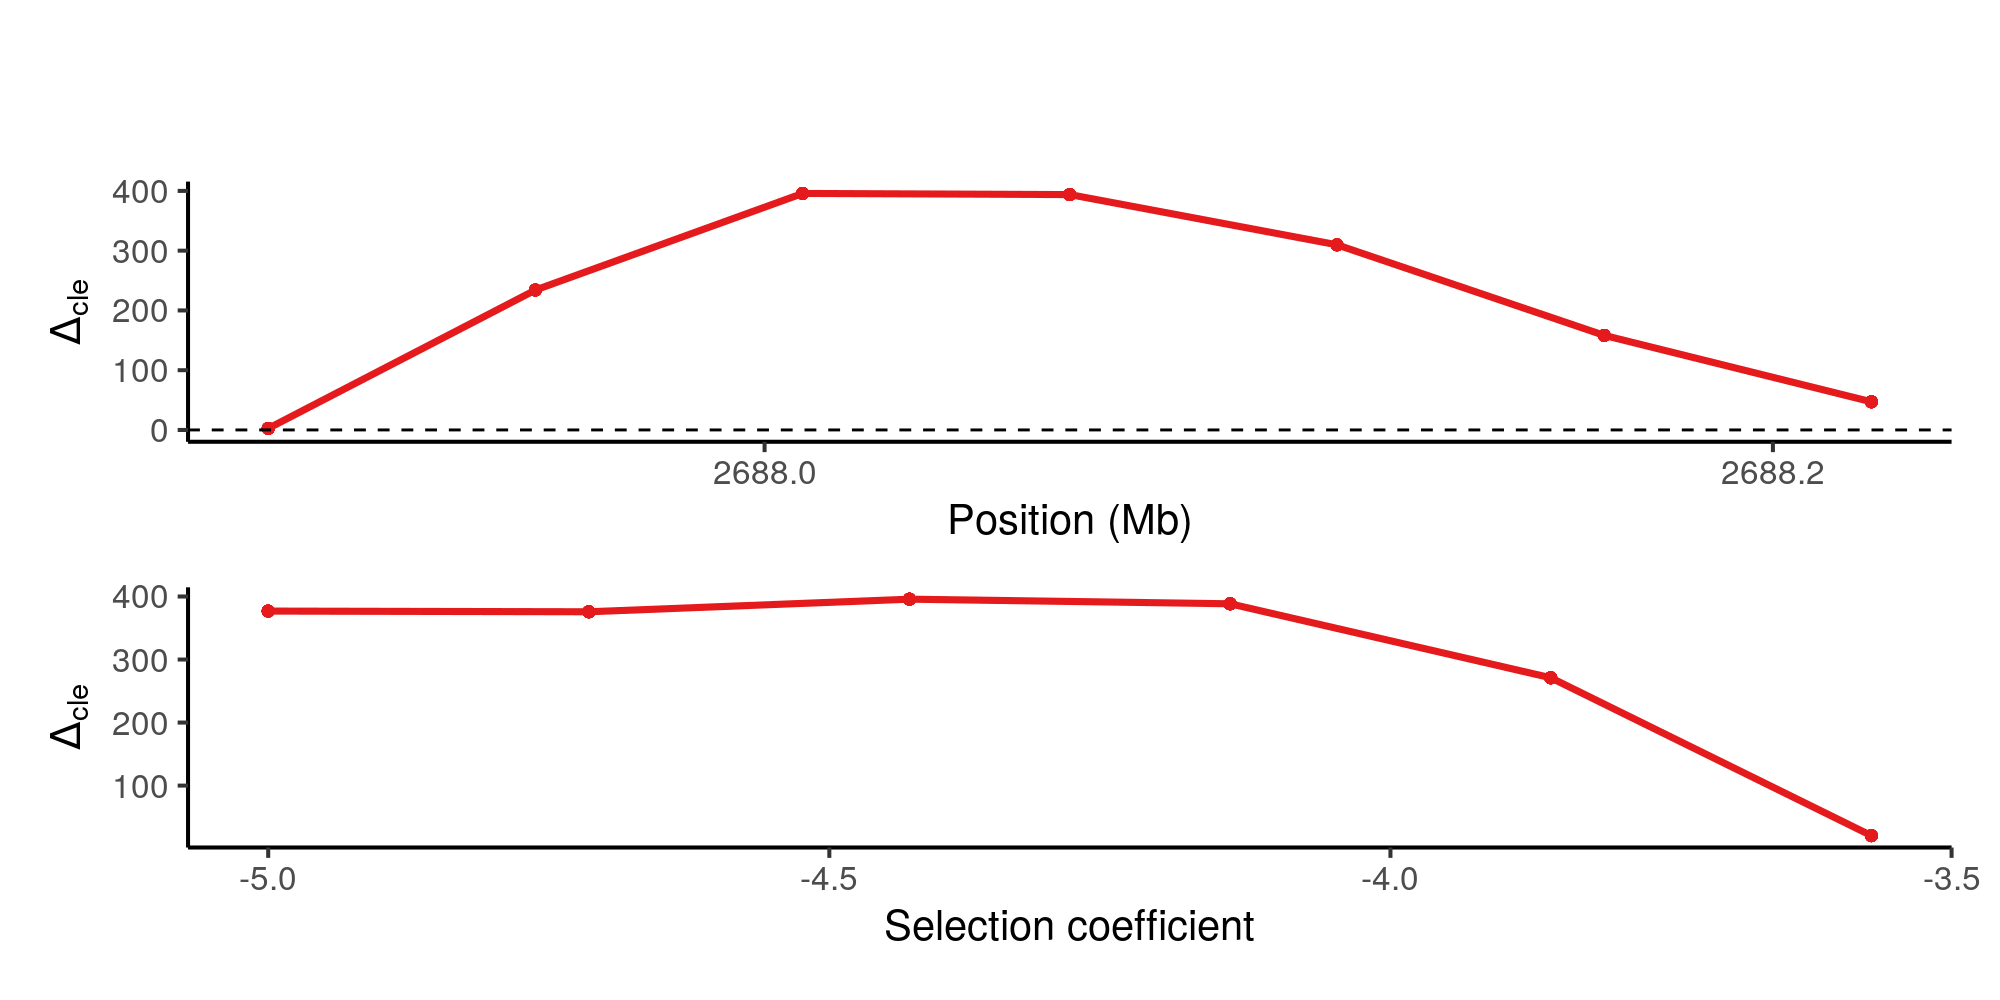

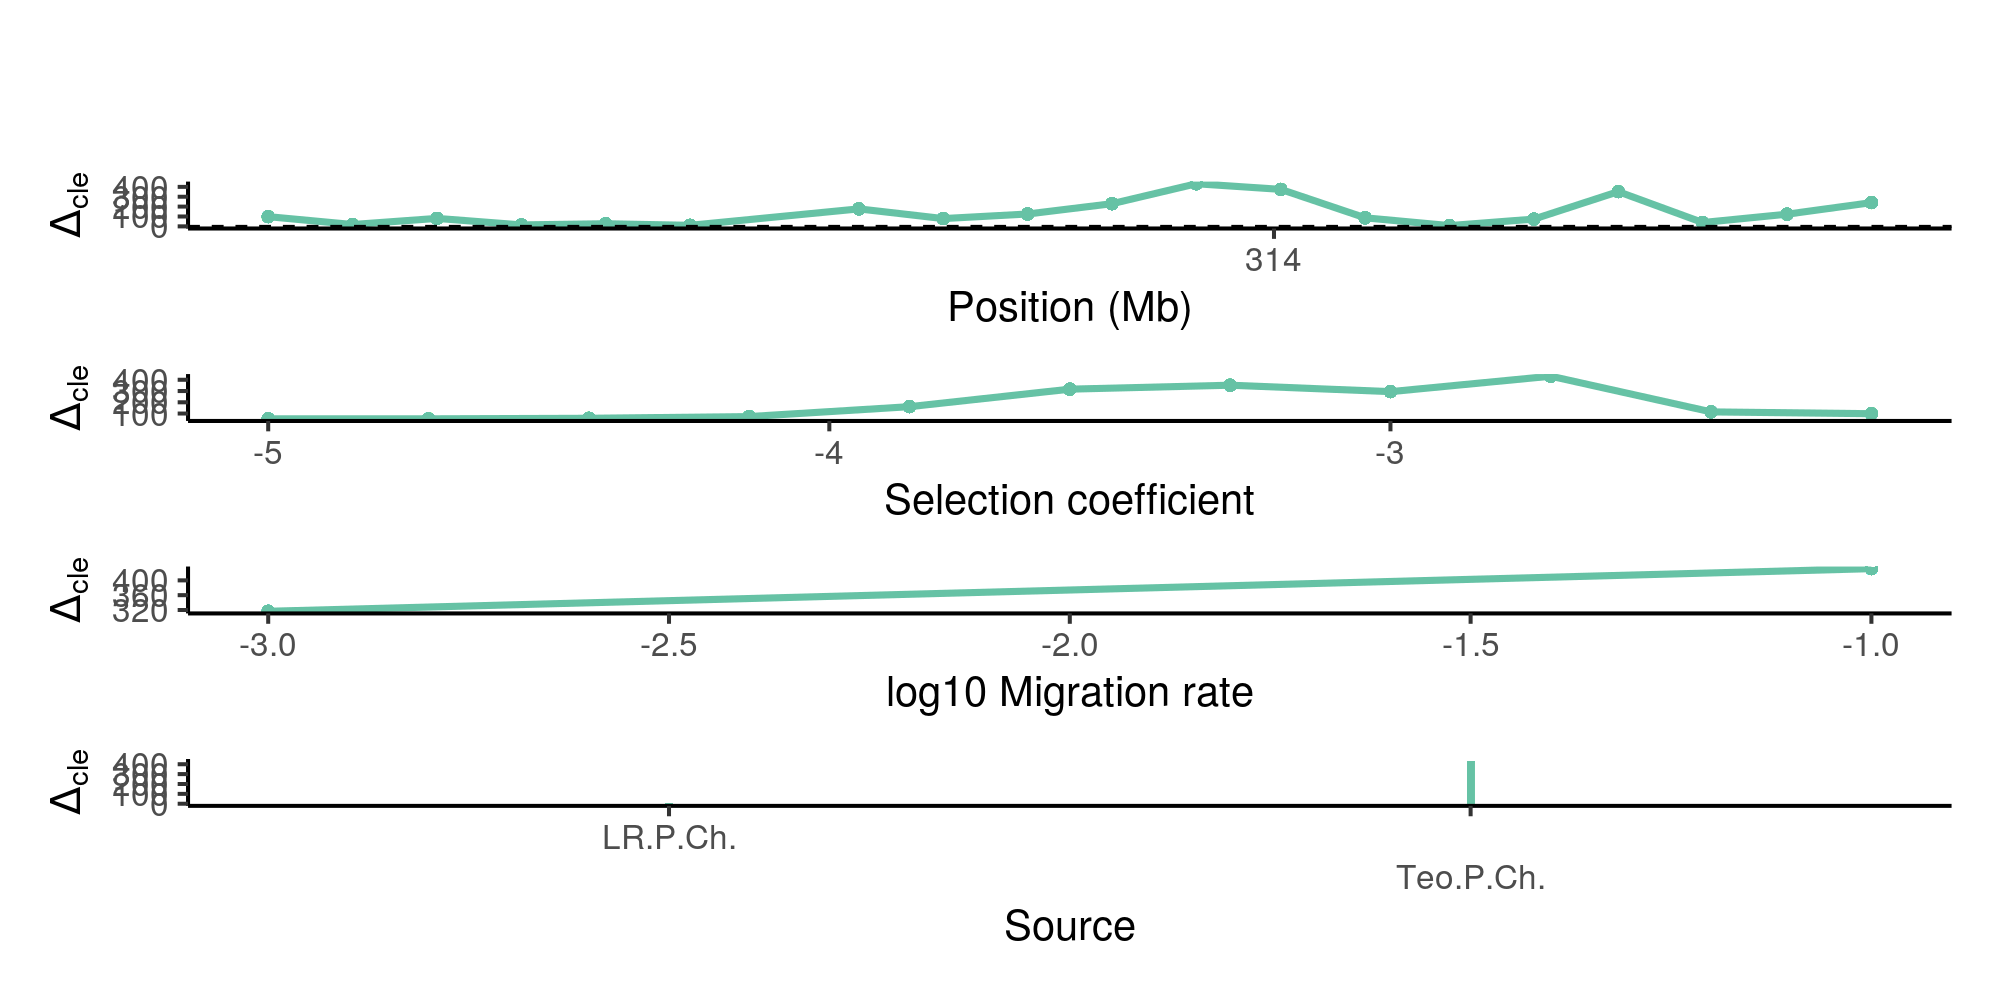

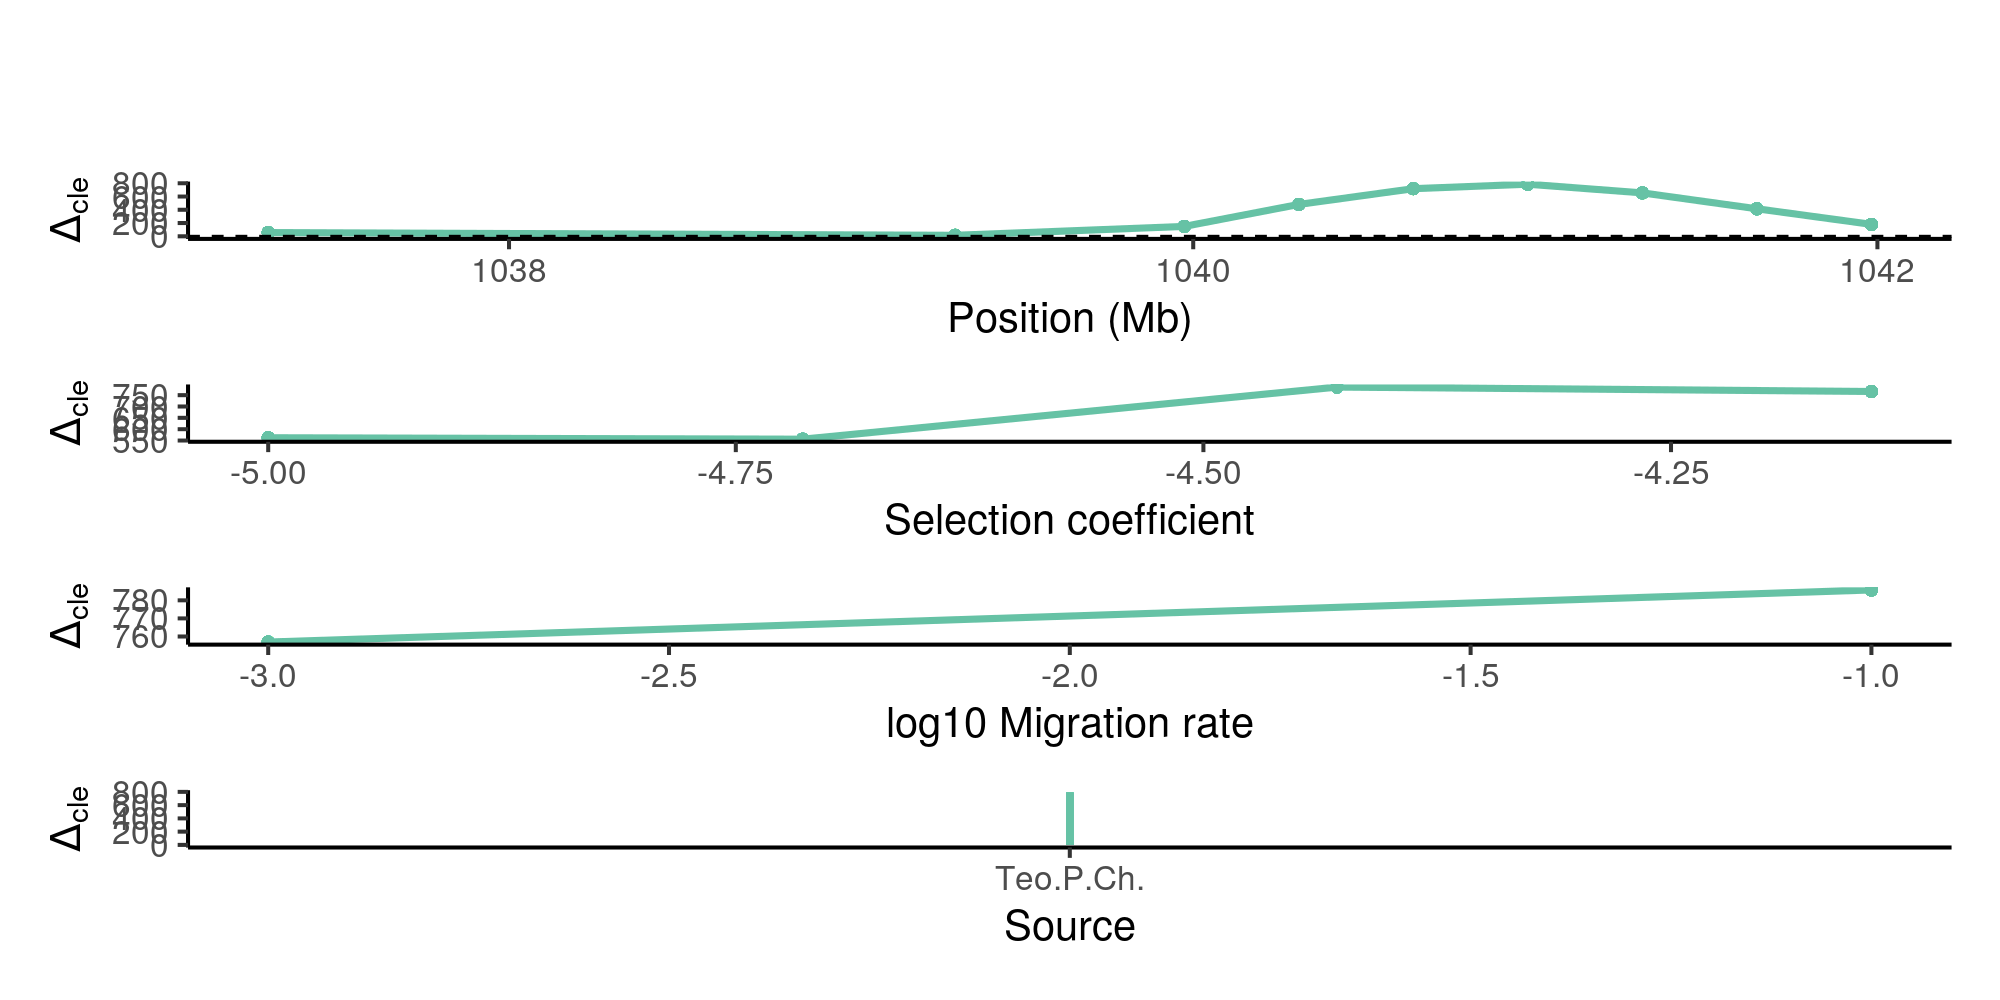

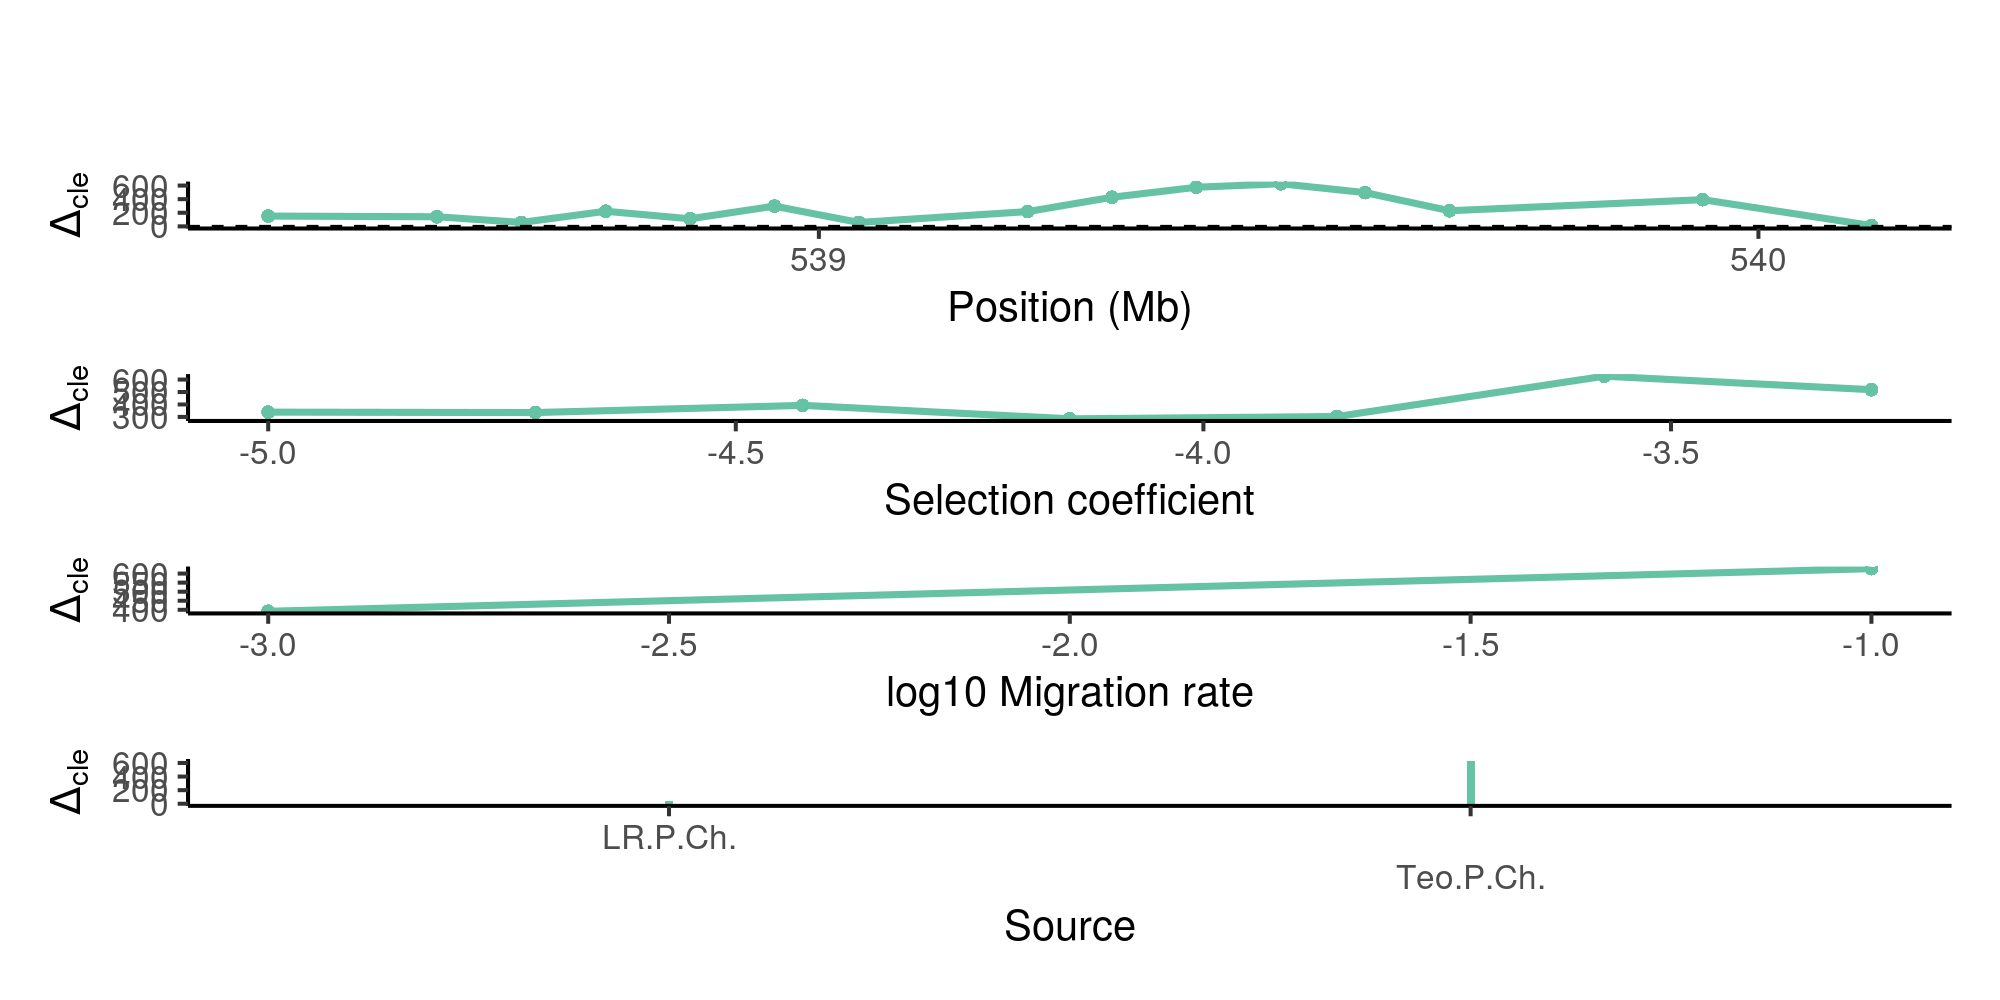

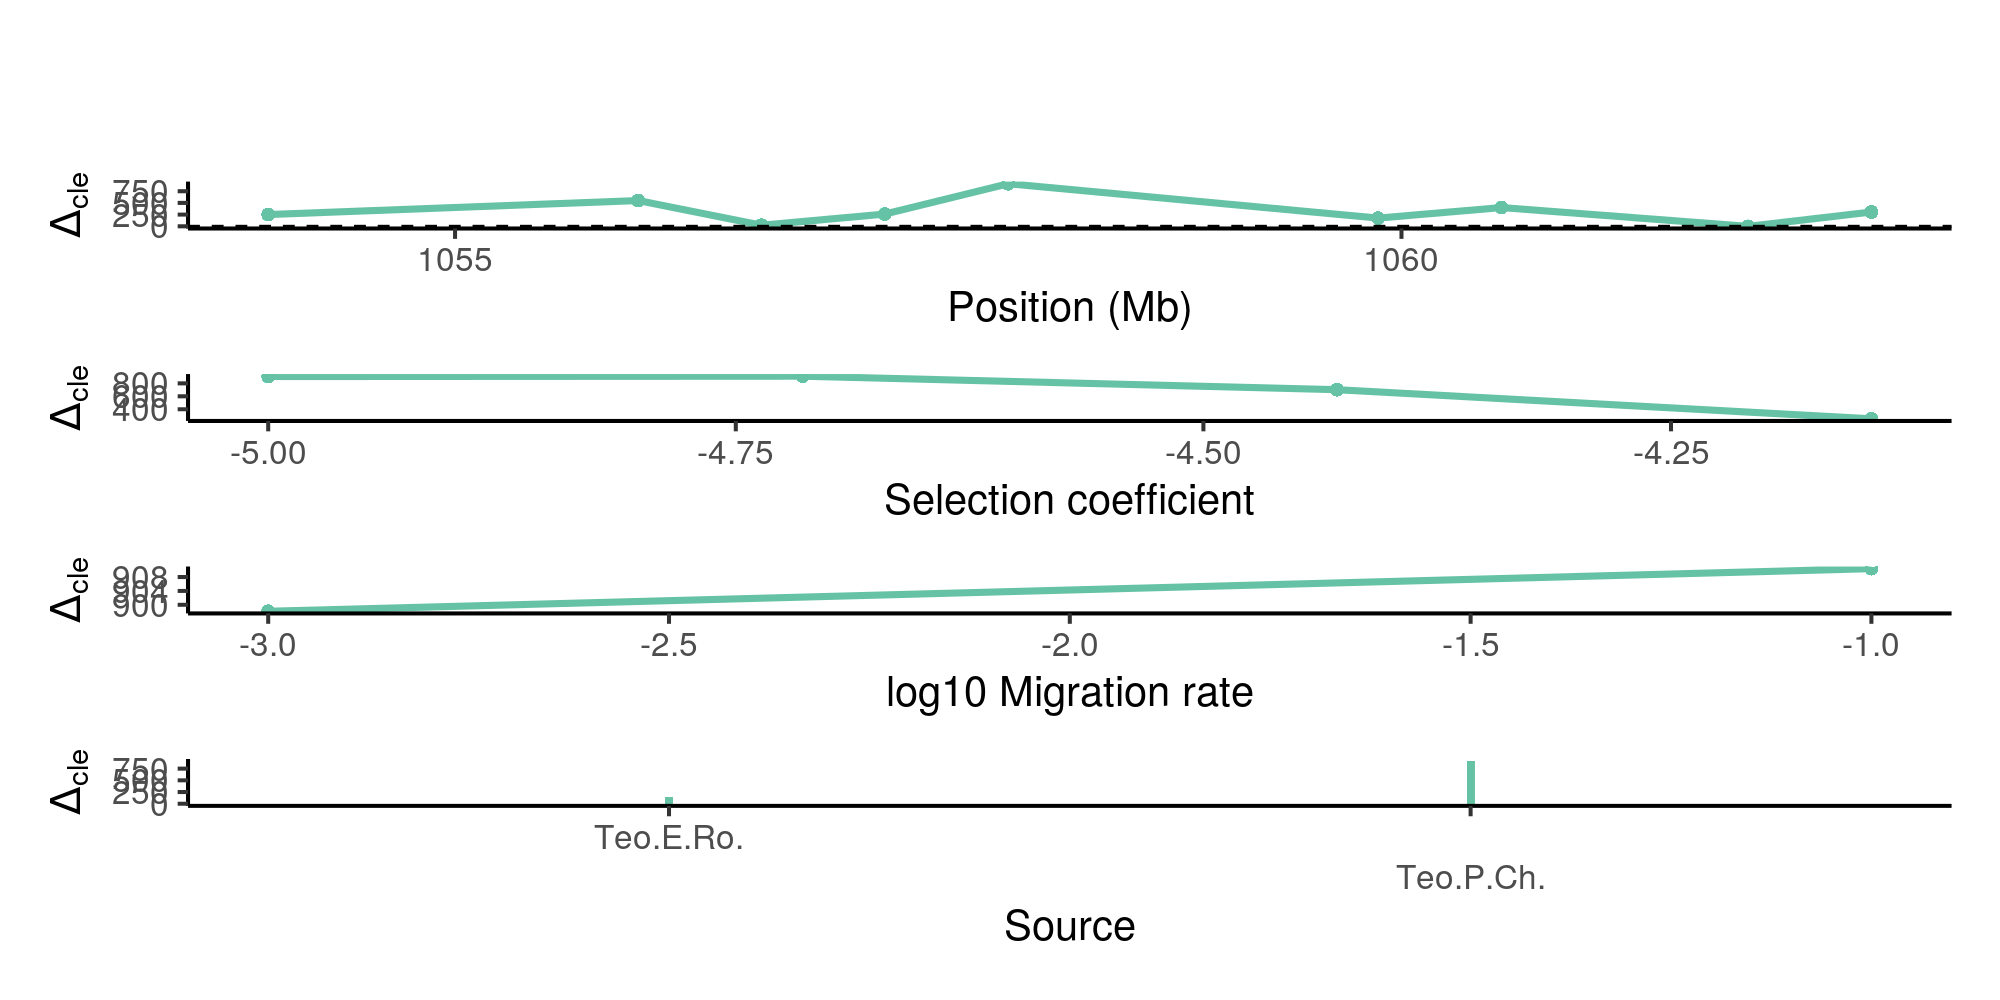

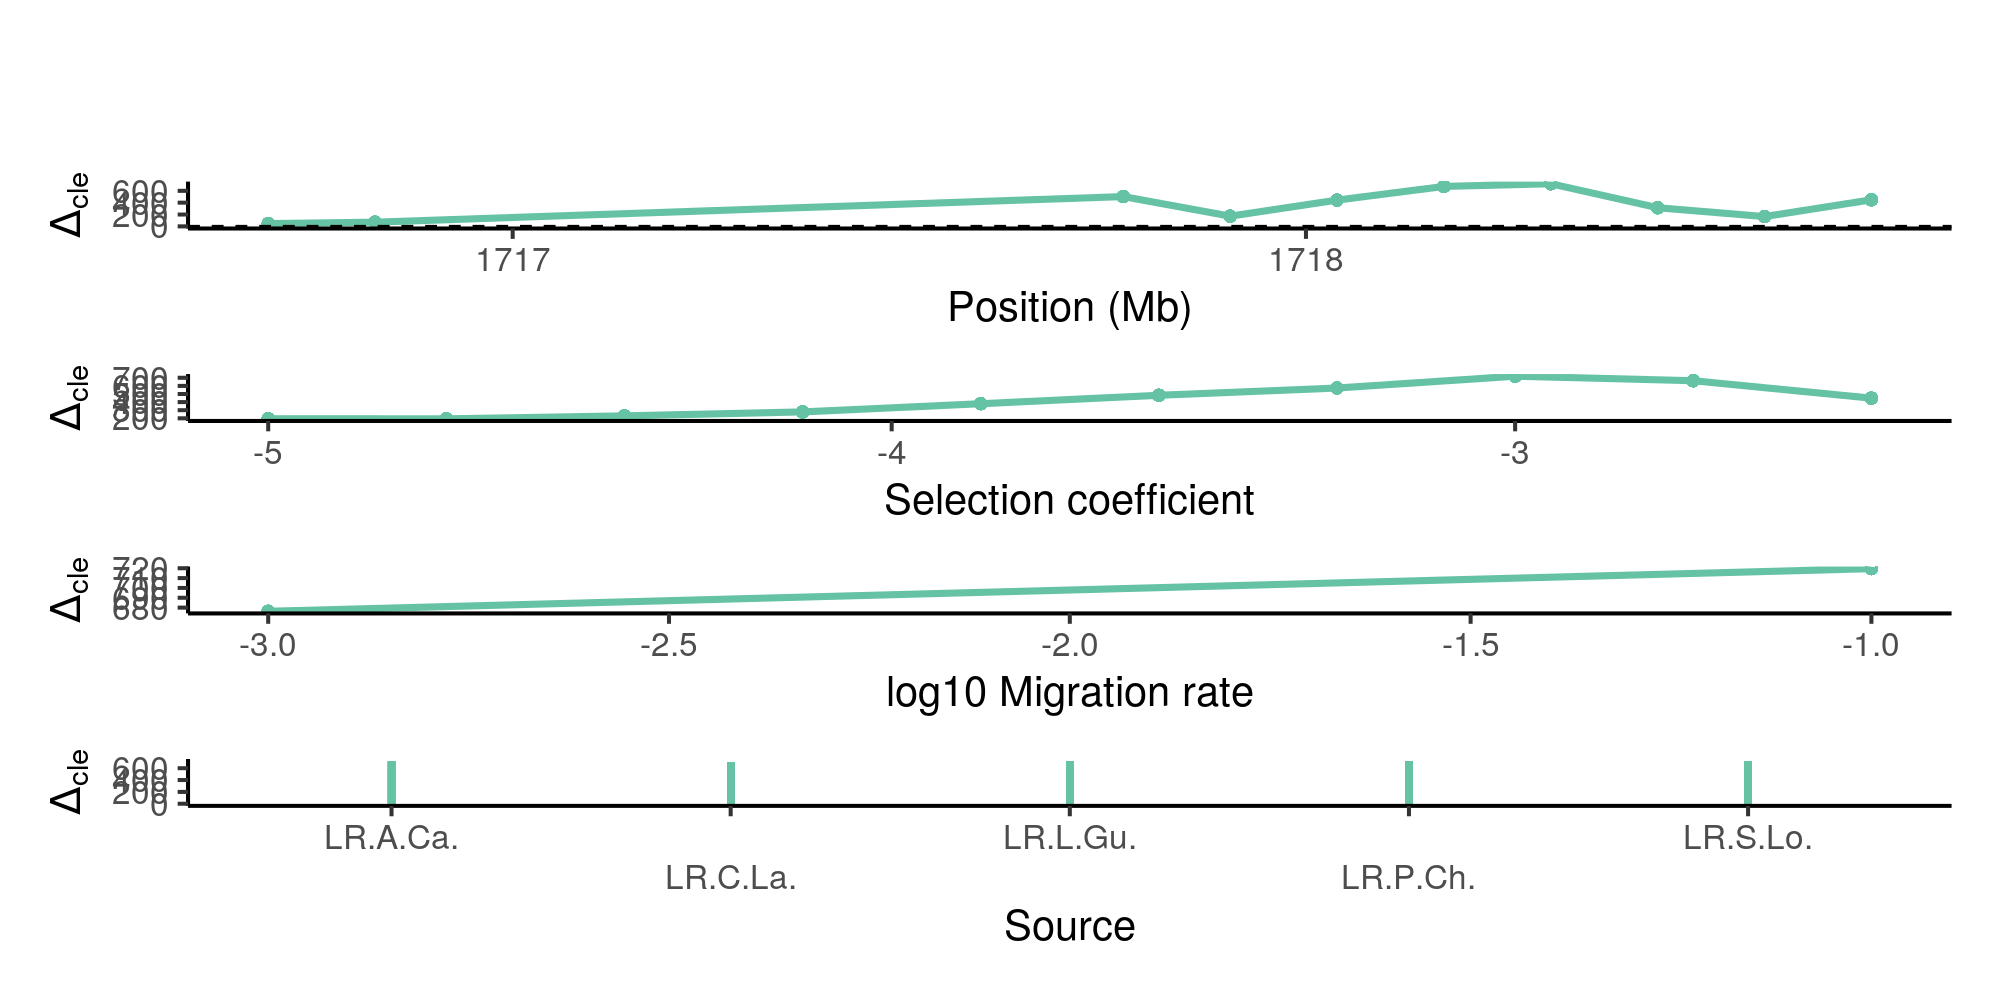

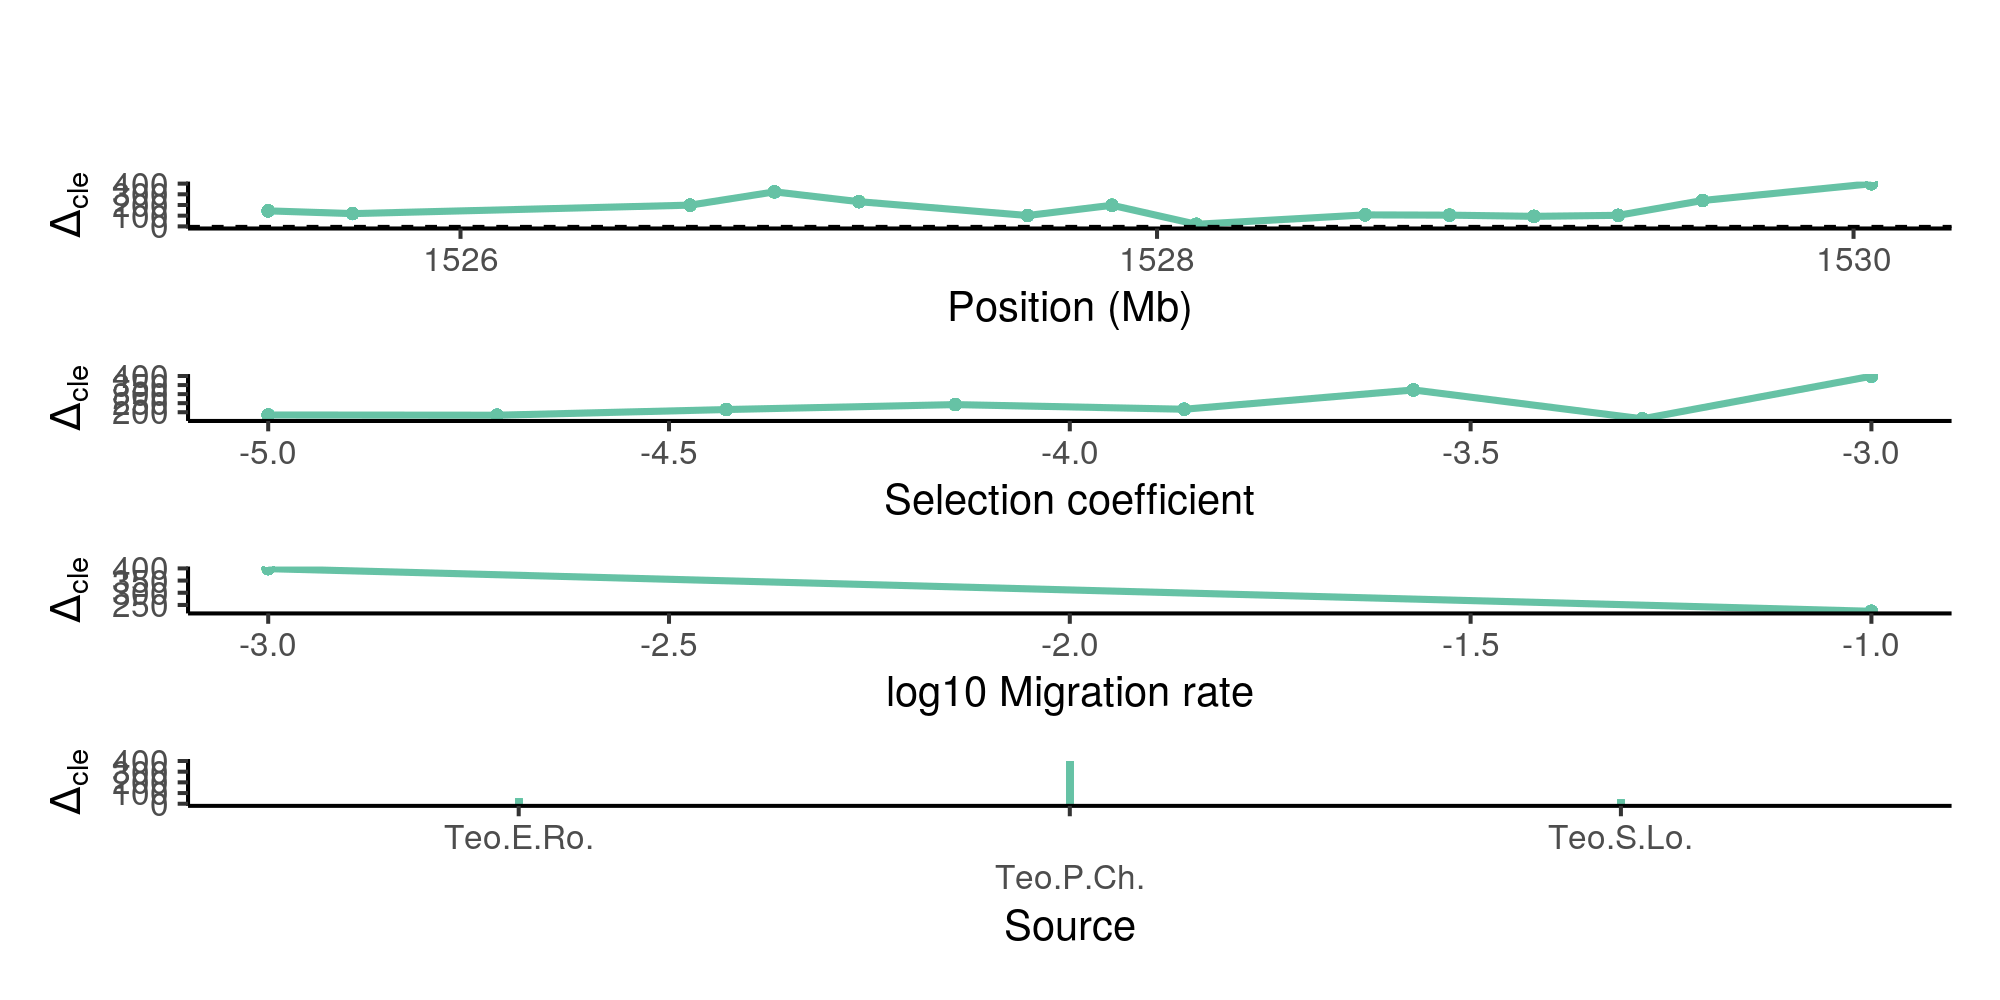

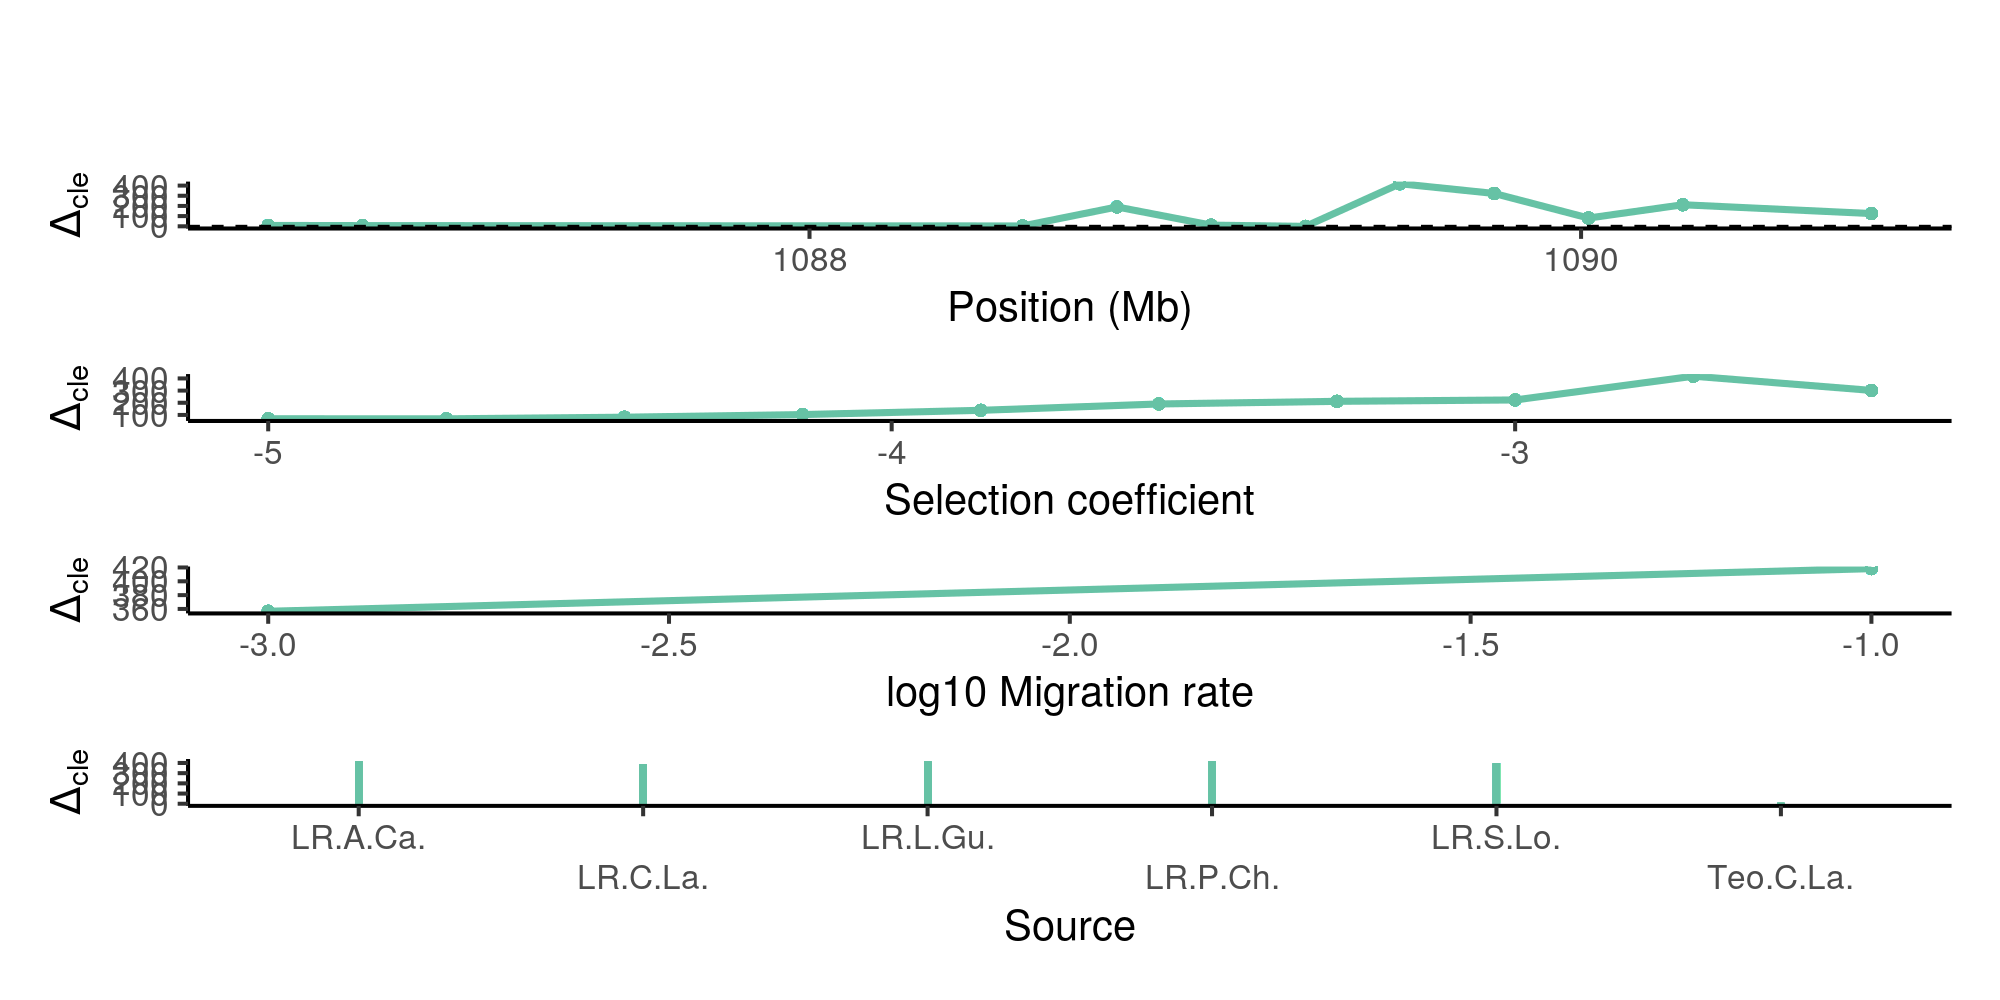

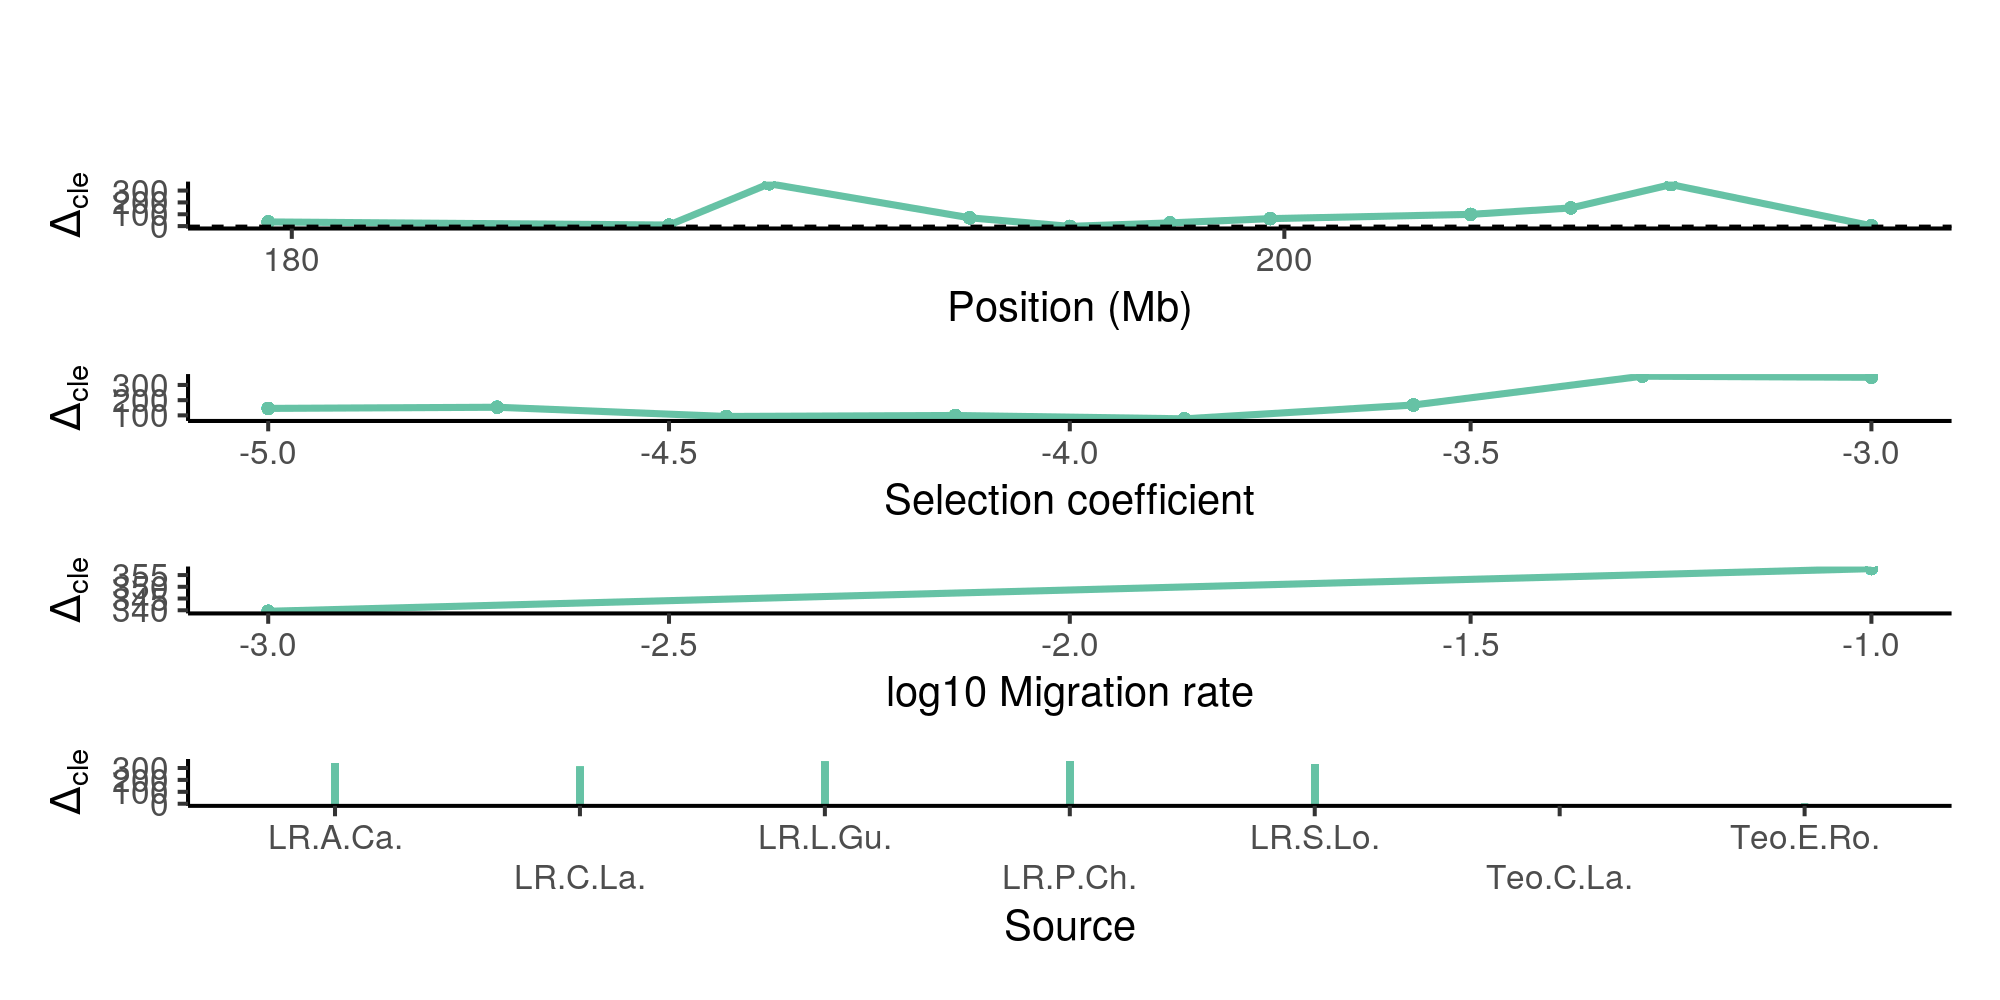

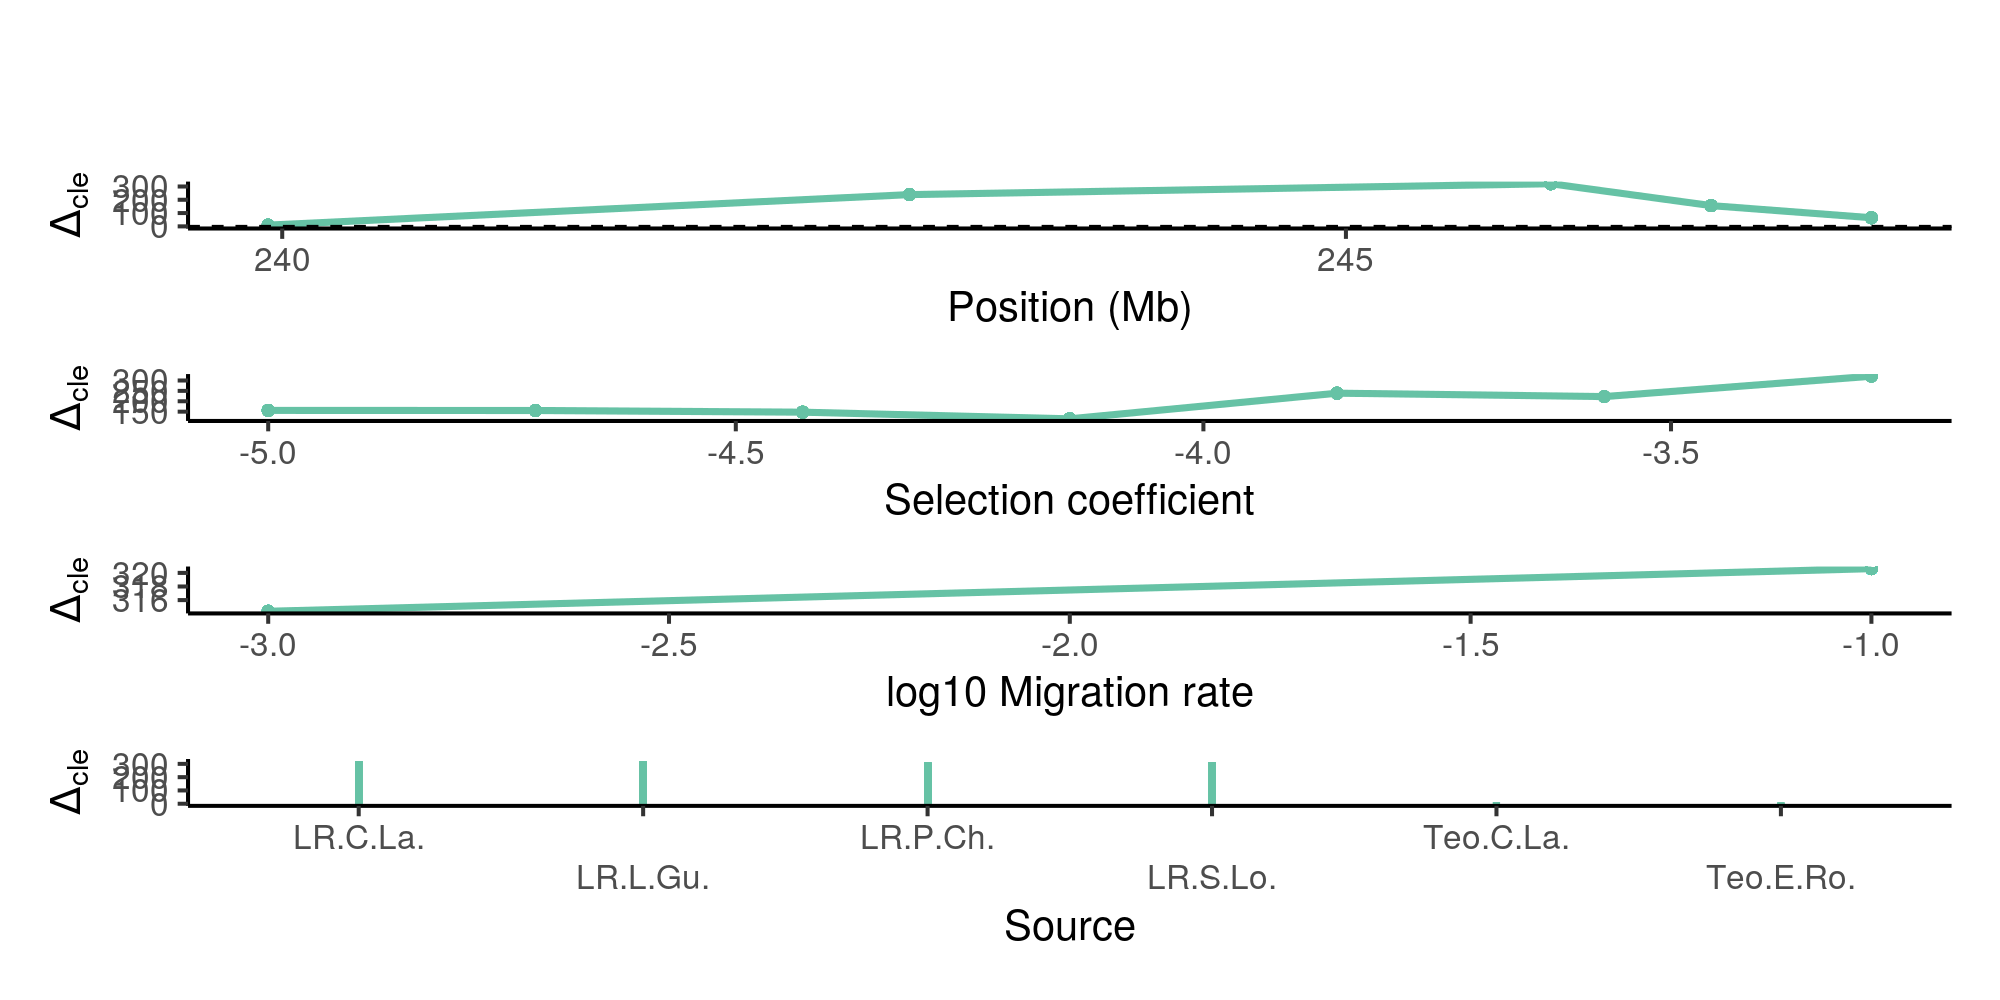

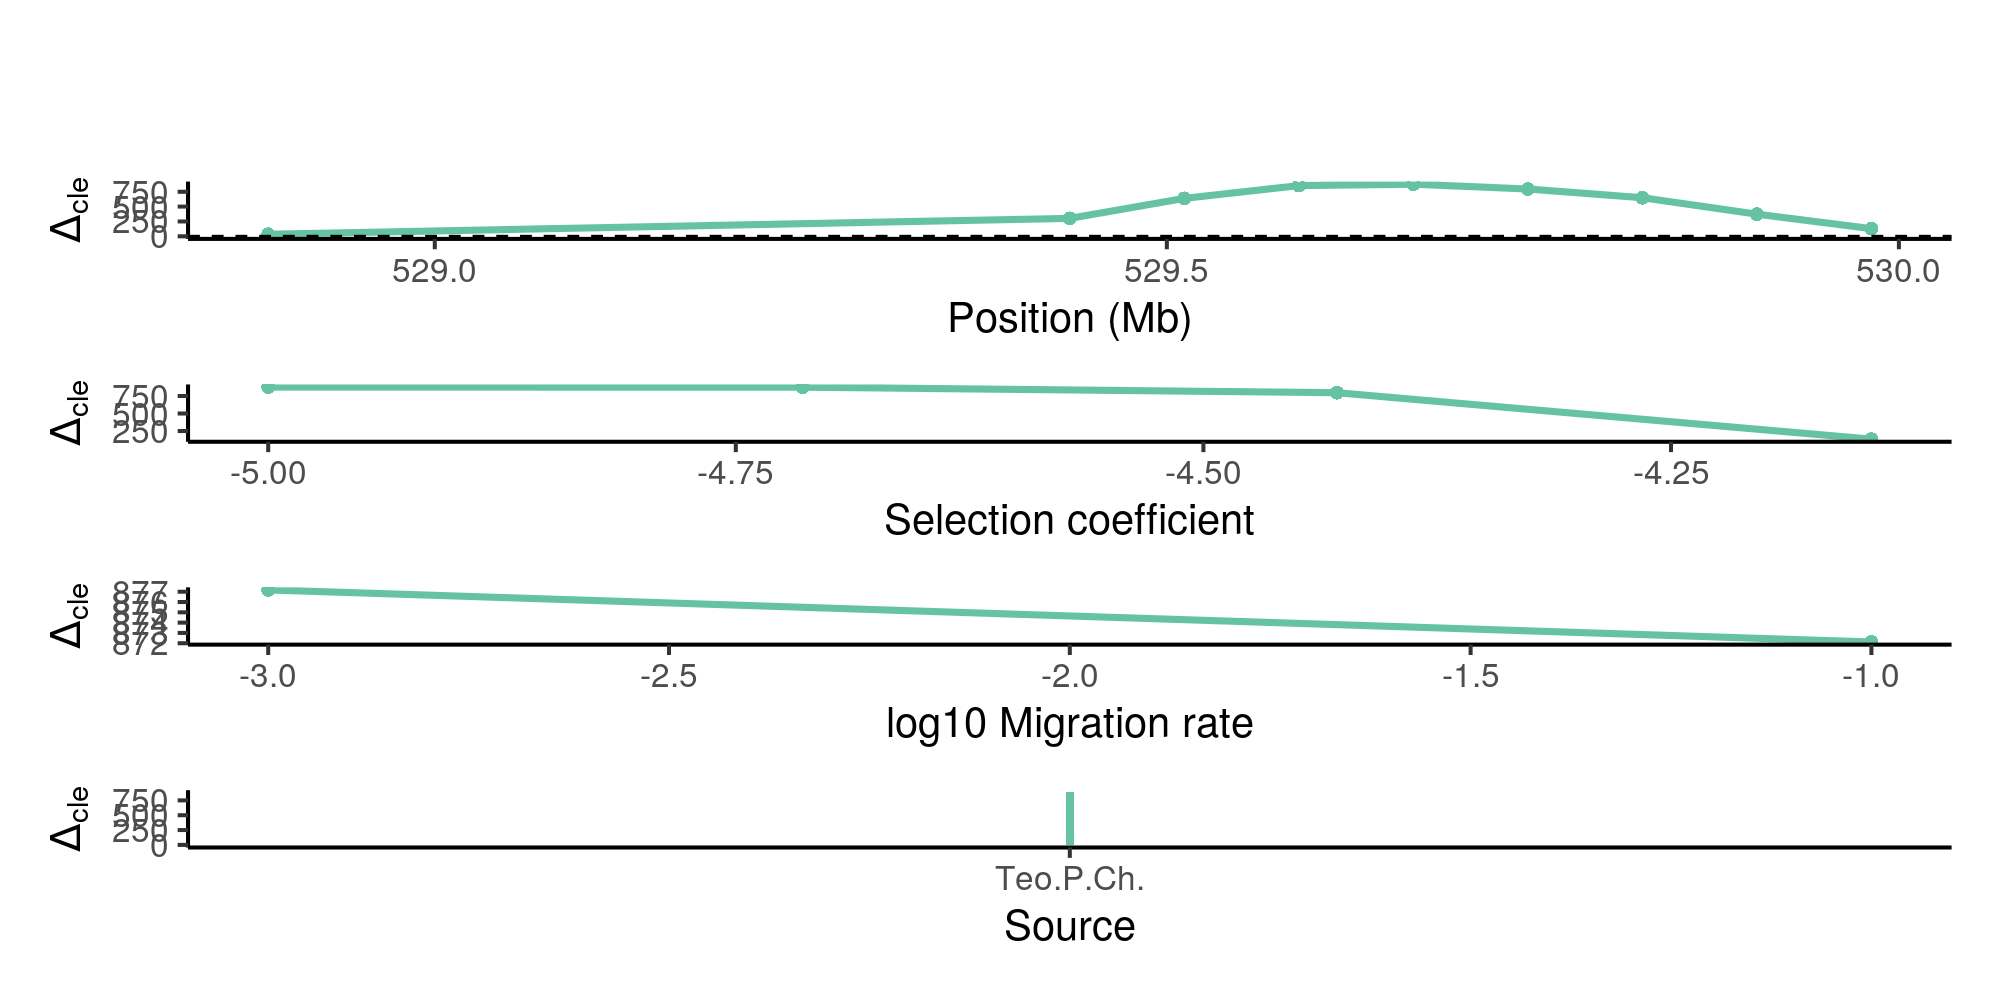

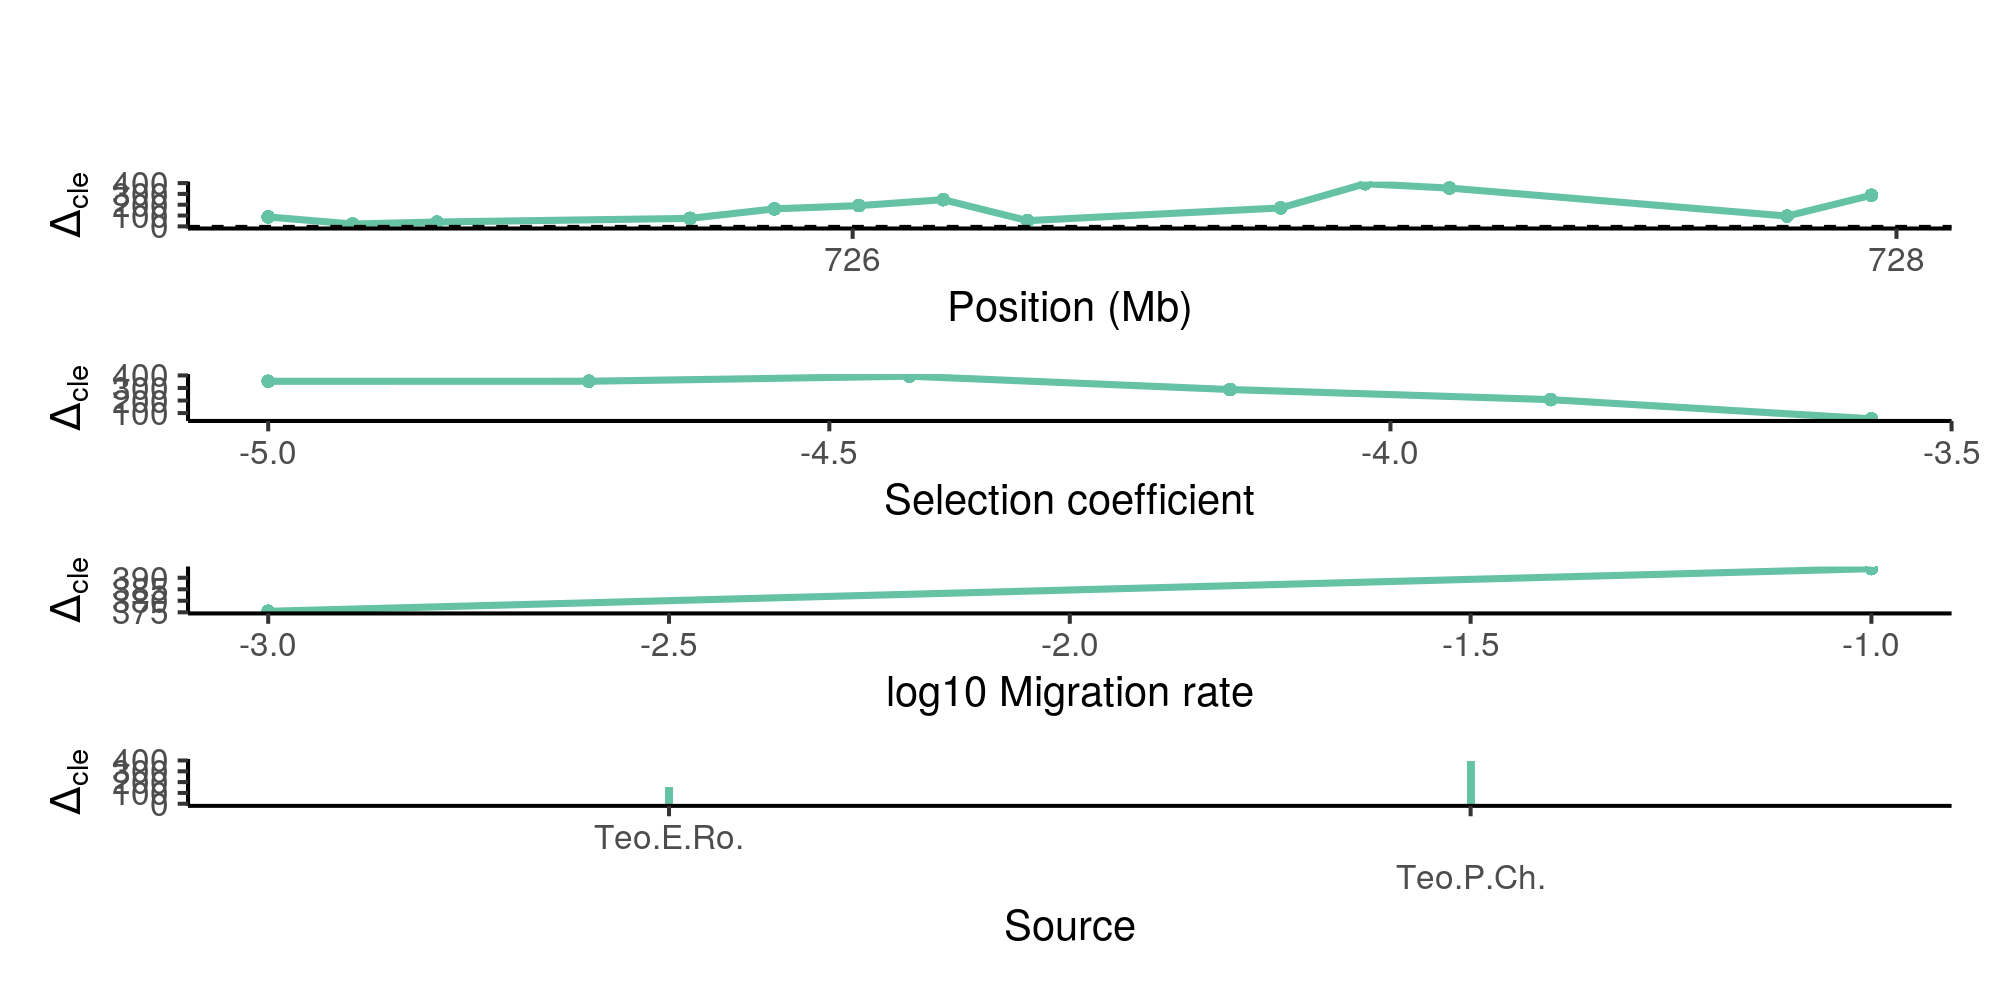

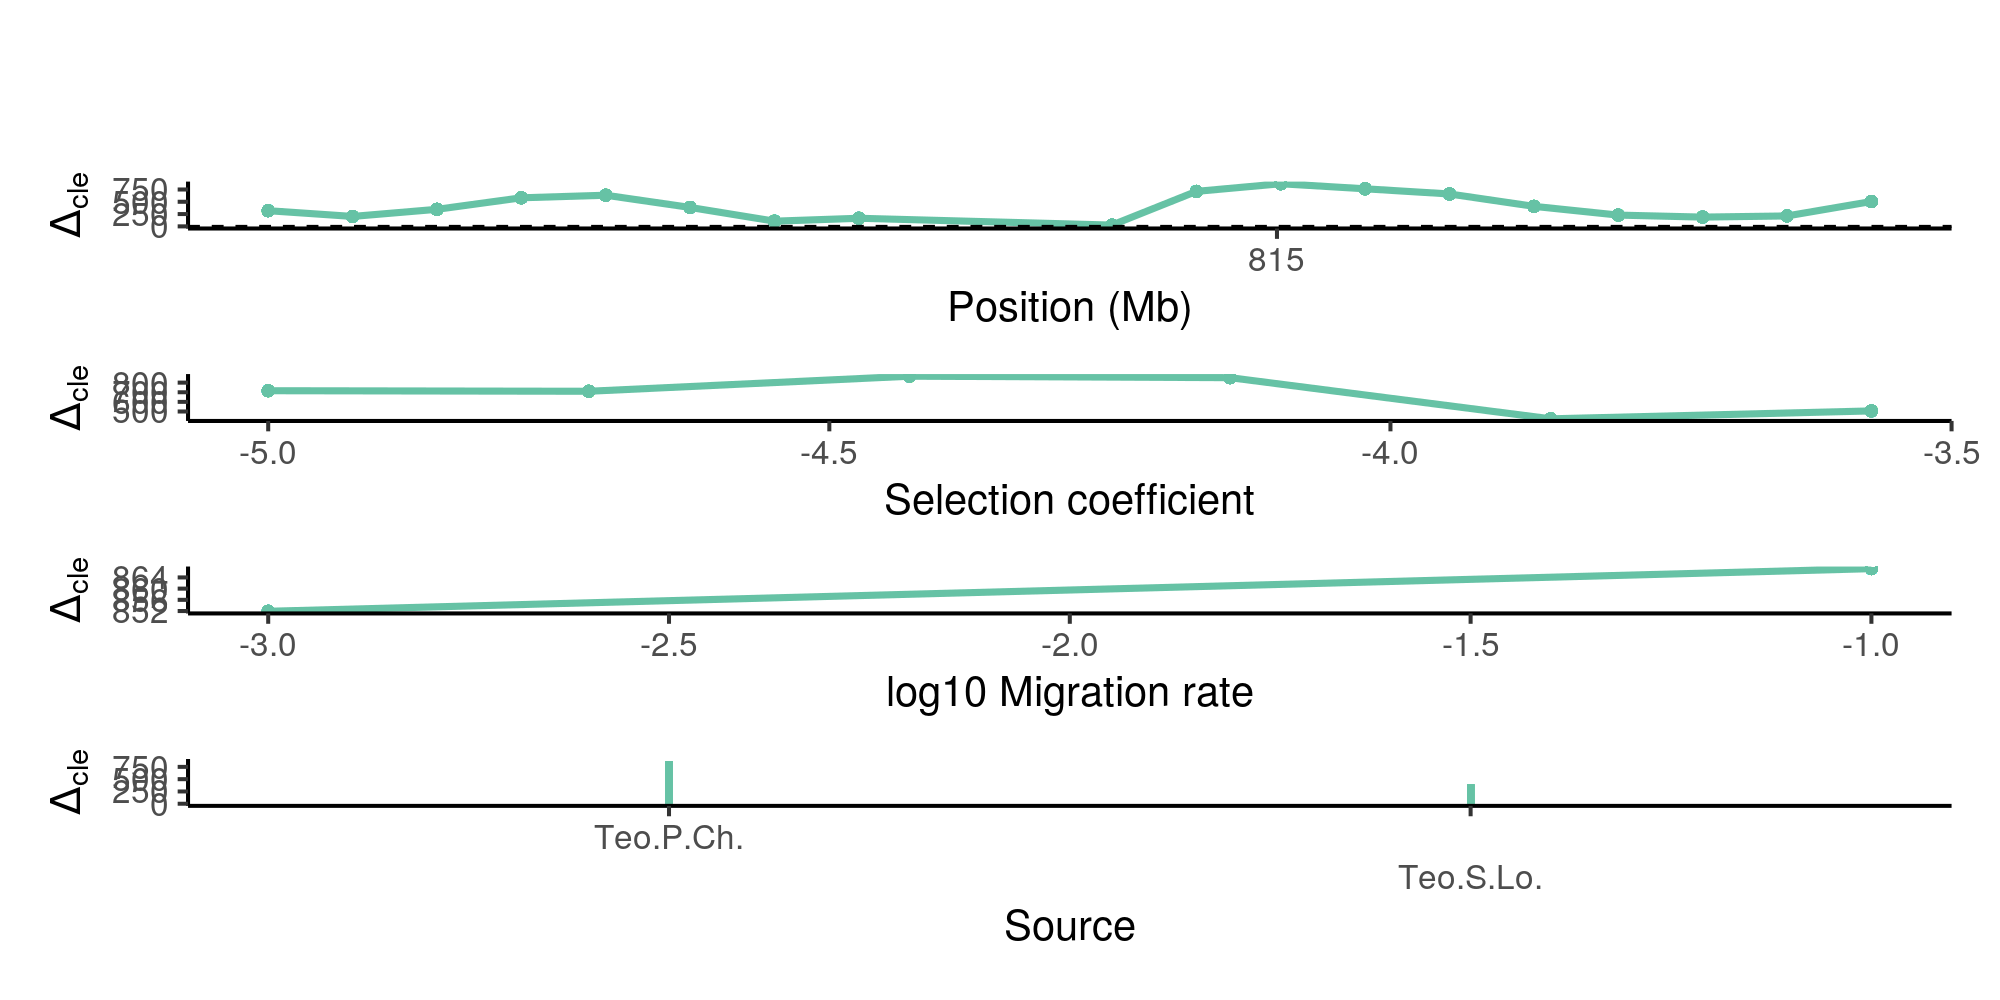

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]

[[11]]

[[12]]

[[13]]

[[14]]

[[15]]

[[16]]

[[17]]

[[18]]


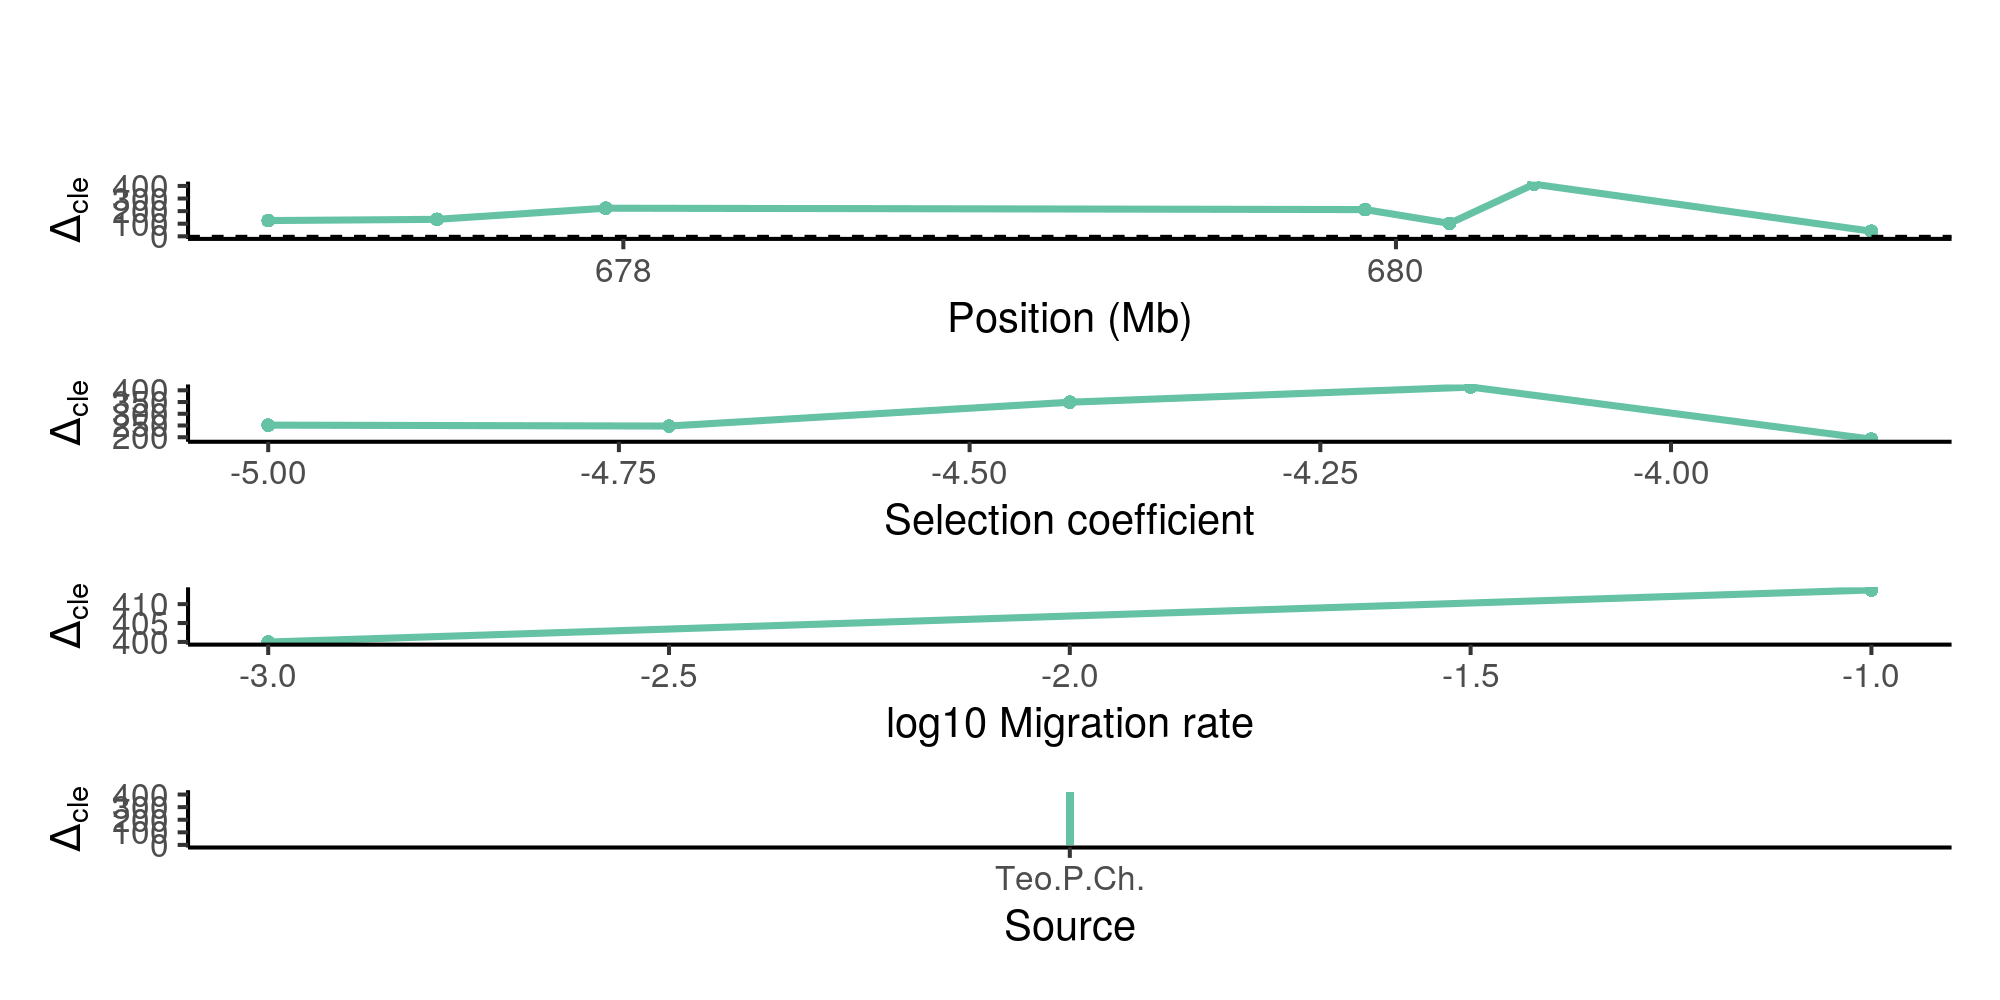

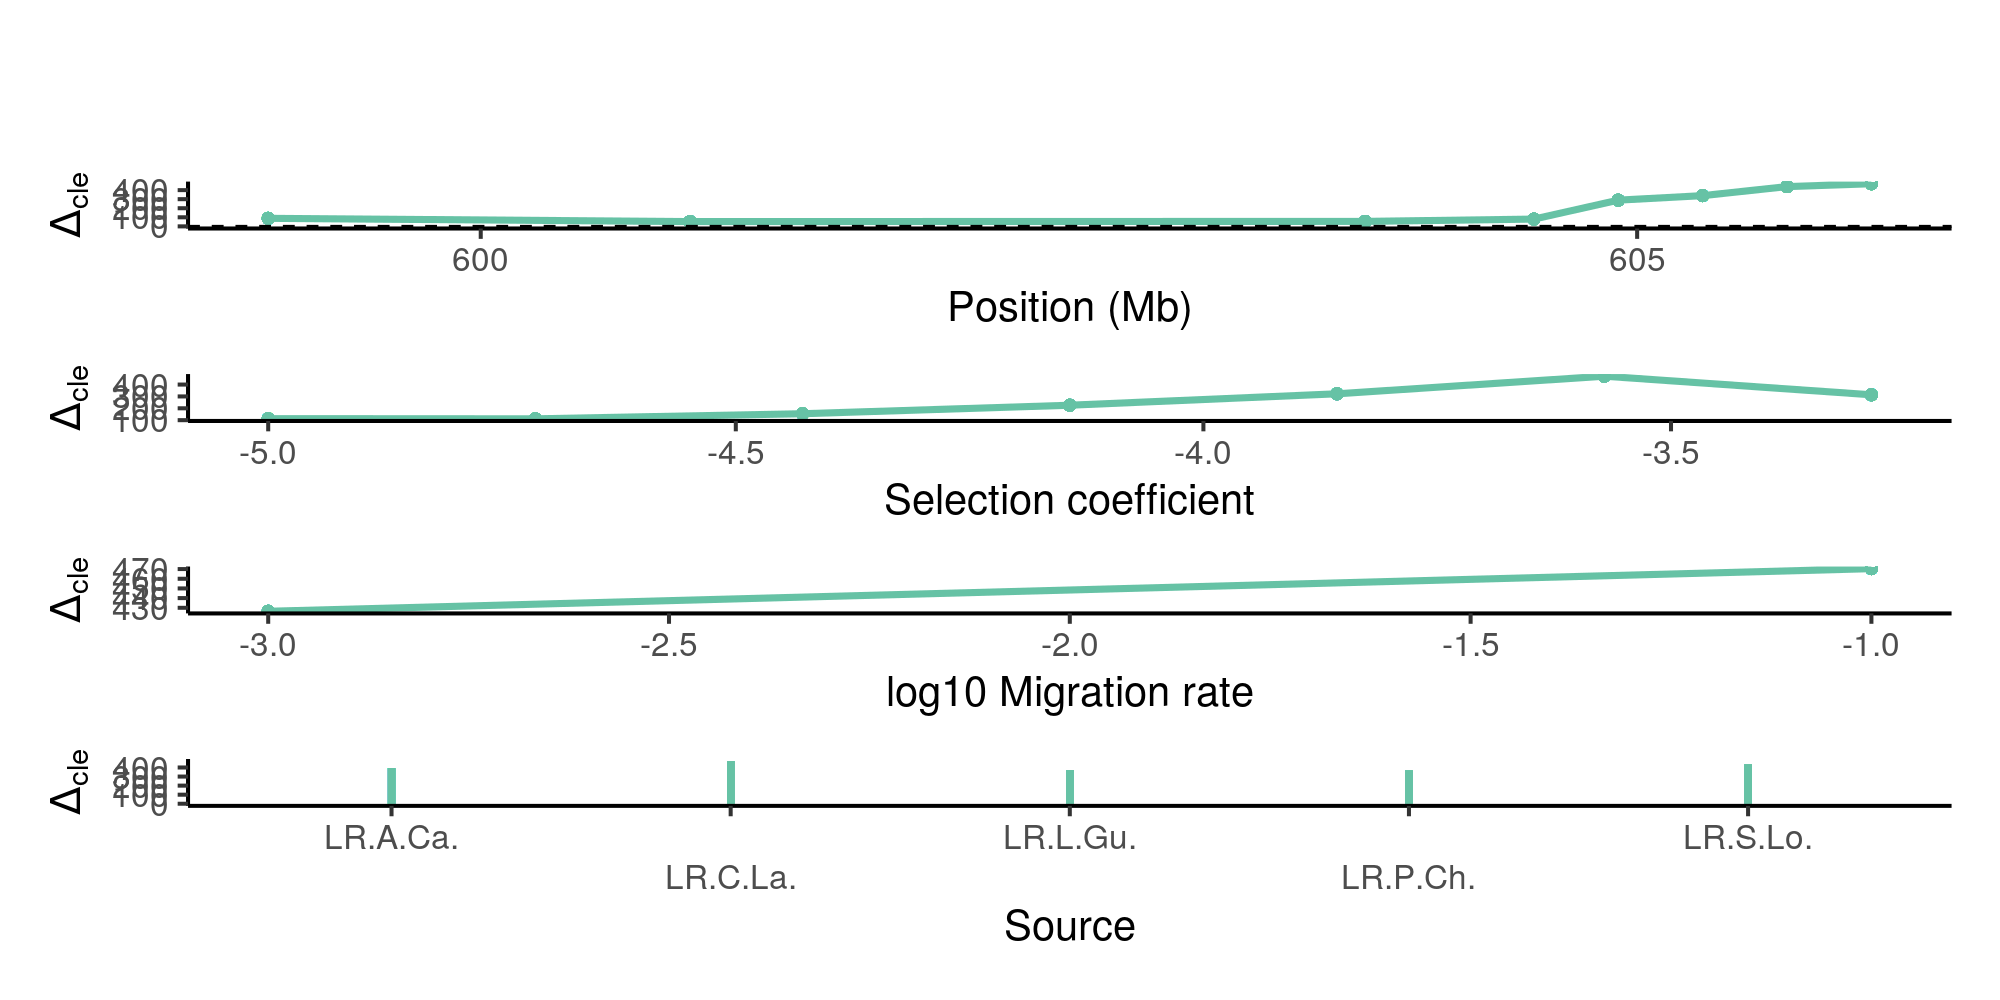

In [16]:

lr_files <- top_models_df %>% filter(model2 != "neutral", sel_pops == "1-2-3-4-5", mcle > 10) %>% pull(file_name)

q_high <- quantile(top_models_df$mcle, 0.99)
top_files <- top_models_df %>% filter(model2 != "neutral", mcle > q_high) %>% pull(file_name)
length(top_files)
top_files
suppressMessages(map(top_files, ~ plot_rdmc(.x, cle_low = -5)))

`summarise()` has grouped output by 'pop_count', 'times'. You can override using the `.groups` argument.



selected_sites sels         cle      
1 100198525      0.0000100000  40931.19
2 100256829      0.0000100000  34294.19
3 100508735      0.0000100000 122831.82
4  10410007      0.0005179475  55305.28
5  10466113      0.0001389495  49669.78
6 105283522      0.0000100000  79938.78
  locus                                                                                         
1 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  gs    times migs sources sel_pops  model     ⋯ mcle          mcle_delta
1 0.001 100    NA  NA      2-4-5     standing  ⋯ -5.223216e-04 0         
2 0.001 100    NA  NA      2-4-5     standing  ⋯ -2.313819e-03 0         
3 0.001 100    NA  NA      1-4-5     standing  ⋯ -3.317808e-06 0         
4    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  4.463767e+00 0         
5    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  3.805085e+00 0         
6 0.001 100    NA  NA      3-5       standing  ⋯ -4.647760e-01 0         
  mcle_nextbest_diff
1   2.850449        
2 114.165837        
3  35.372594        
4   4.463767        
5   3.805085        
6  98.471809        
  file_name                                                                                   
1 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  populations                                                                                                               
1 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
2 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
3 v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                               
4 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
5 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
6 v5--LR--Los_Guajes; v5--LR--San_Lorenzo                                                                                   
  type  pop_count Landraces_count Teosinte_count model2   
1 Maize 3         3               0              neutral  
2 Maize 3         3               0              neutral  
3 Maize 3         3               0              neutral  
4 Maize 5         5               0              migration
5 Maize 5         5               0              migration
6 Maize 2         2               0              neutral

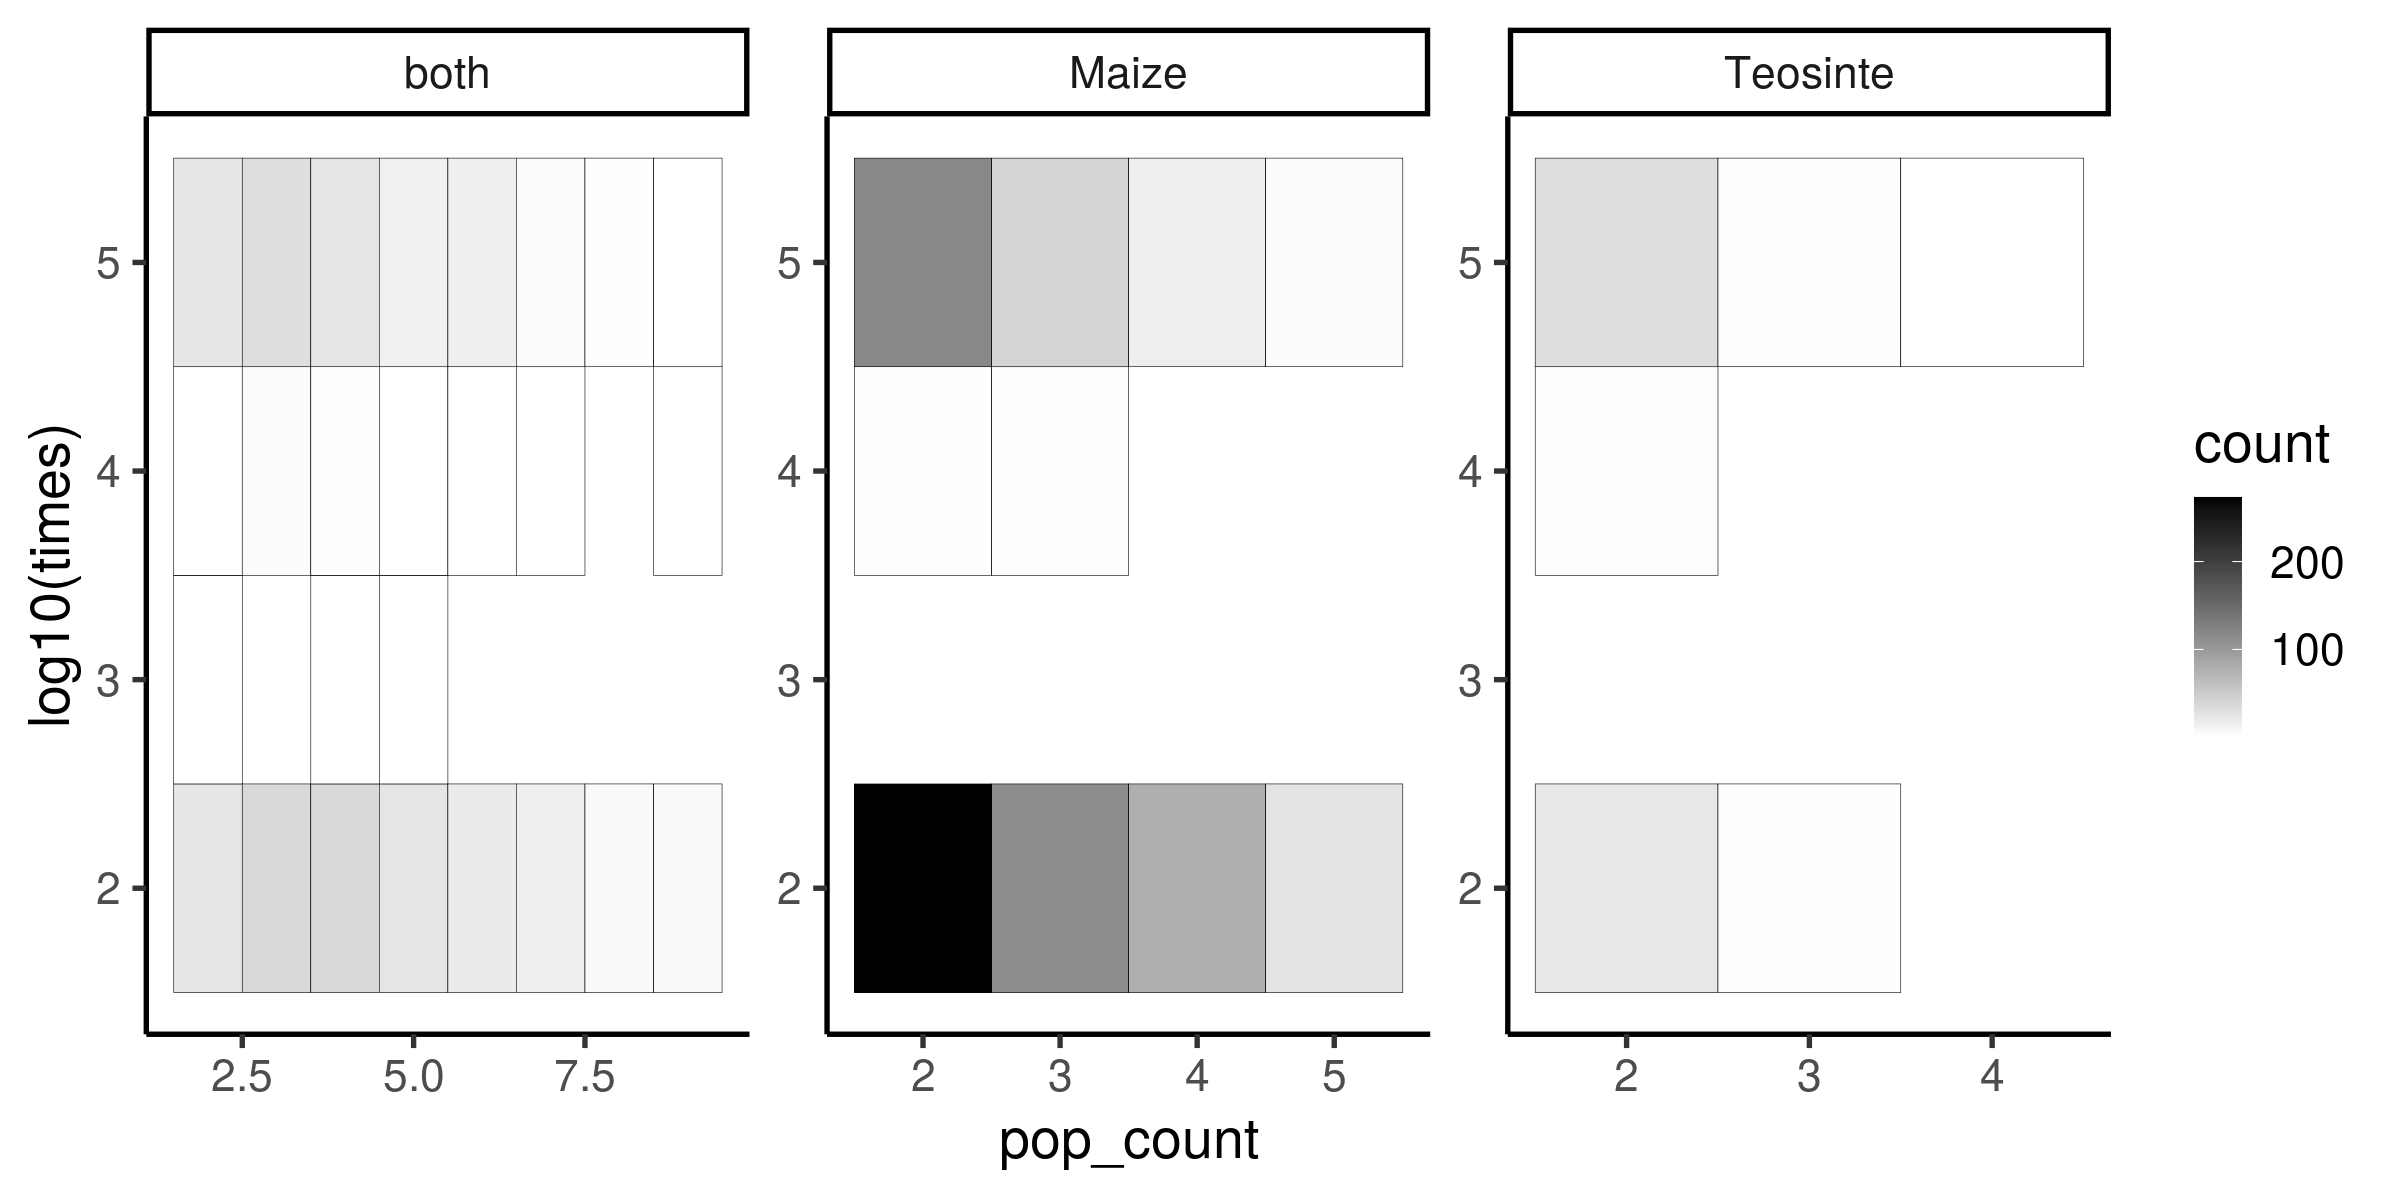

In [17]:
options(repr.plot.width = 12, repr.plot.height = 6 , repr.plot.res = 200)

top_models_df %>% 
    select(pop_count, times, type) %>% 
    drop_na() %>% 
    group_by(pop_count, times, type) %>% 
    summarise(count = n()) %>% 
    ggplot(aes(pop_count, log10(times), fill = count)) +
    geom_tile(color = "black") +
    facet_wrap(~type, scales = "free") +
    scale_fill_gradient(low = "white", high = "black")

head(top_models_df)

# FIGURE 5

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



type     model2      n()
1  both     independent   3
2  both     migration   317
3  both     neutral     174
4  both     standing    137
5  Maize    independent  12
6  Maize    migration   316
7  Maize    neutral     416
8  Maize    standing    264
9  Teosinte independent   2
10 Teosinte migration    30
11 Teosinte neutral      37
12 Teosinte standing     26

model2      n()
1 independent  17
2 migration   663
3 neutral     627
4 standing    427

[1] 1734

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



[1] "HERE!"


selected_sites sels         cle      
1 100198525      0.0000100000  40931.19
2 100256829      0.0000100000  34294.19
3 100508735      0.0000100000 122831.82
4  10410007      0.0005179475  55305.28
5  10466113      0.0001389495  49669.78
6 105283522      0.0000100000  79938.78
  locus                                                                                         
1 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 data/rdmc/sweep_freq/v5--sweep--chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  gs    times migs sources sel_pops  model     ⋯ mcle          mcle_delta
1 0.001 100    NA  NA      2-4-5     standing  ⋯ -5.223216e-04 0         
2 0.001 100    NA  NA      2-4-5     standing  ⋯ -2.313819e-03 0         
3 0.001 100    NA  NA      1-4-5     standing  ⋯ -3.317808e-06 0         
4    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  4.463767e+00 0         
5    NA  NA   0.1   2      1-2-3-4-5 migration ⋯  3.805085e+00 0         
6 0.001 100    NA  NA      3-5       standing  ⋯ -4.647760e-01 0         
  mcle_nextbest_diff
1   2.850449        
2 114.165837        
3  35.372594        
4   4.463767        
5   3.805085        
6  98.471809        
  file_name                                                                                   
1 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100197055_end100282945_pops2-4-5.txt  
2 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100223517_end100282005_pops2-4-5.txt  
3 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start100393279_end100636254_pops1-4-5.txt  
4 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10382710_end10518322_pops1-2-3-4-5.txt
5 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start10430149_end10517583_pops1-2-3-4-5.txt
6 ../data/rdmc/fitted/v5--sweep_chr1--0--308452471_start105182522_end105338183_pops3-5.txt    
  populations                                                                                                               
1 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
2 v5--LR--Crucero_Lagunitas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                              
3 v5--LR--Amatlan_de_Canas; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo                                               
4 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
5 v5--LR--Amatlan_de_Canas; v5--LR--Crucero_Lagunitas; v5--LR--Los_Guajes; v5--LR--RANDOM1_Palmar_Chico; v5--LR--San_Lorenzo
6 v5--LR--Los_Guajes; v5--LR--San_Lorenzo                                                                                   
  type  pop_count Landraces_count Teosinte_count model2   
1 Maize 3         3               0              neutral  
2 Maize 3         3               0              neutral  
3 Maize 3         3               0              neutral  
4 Maize 5         5               0              migration
5 Maize 5         5               0              migration
6 Maize 2         2               0              neutral

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


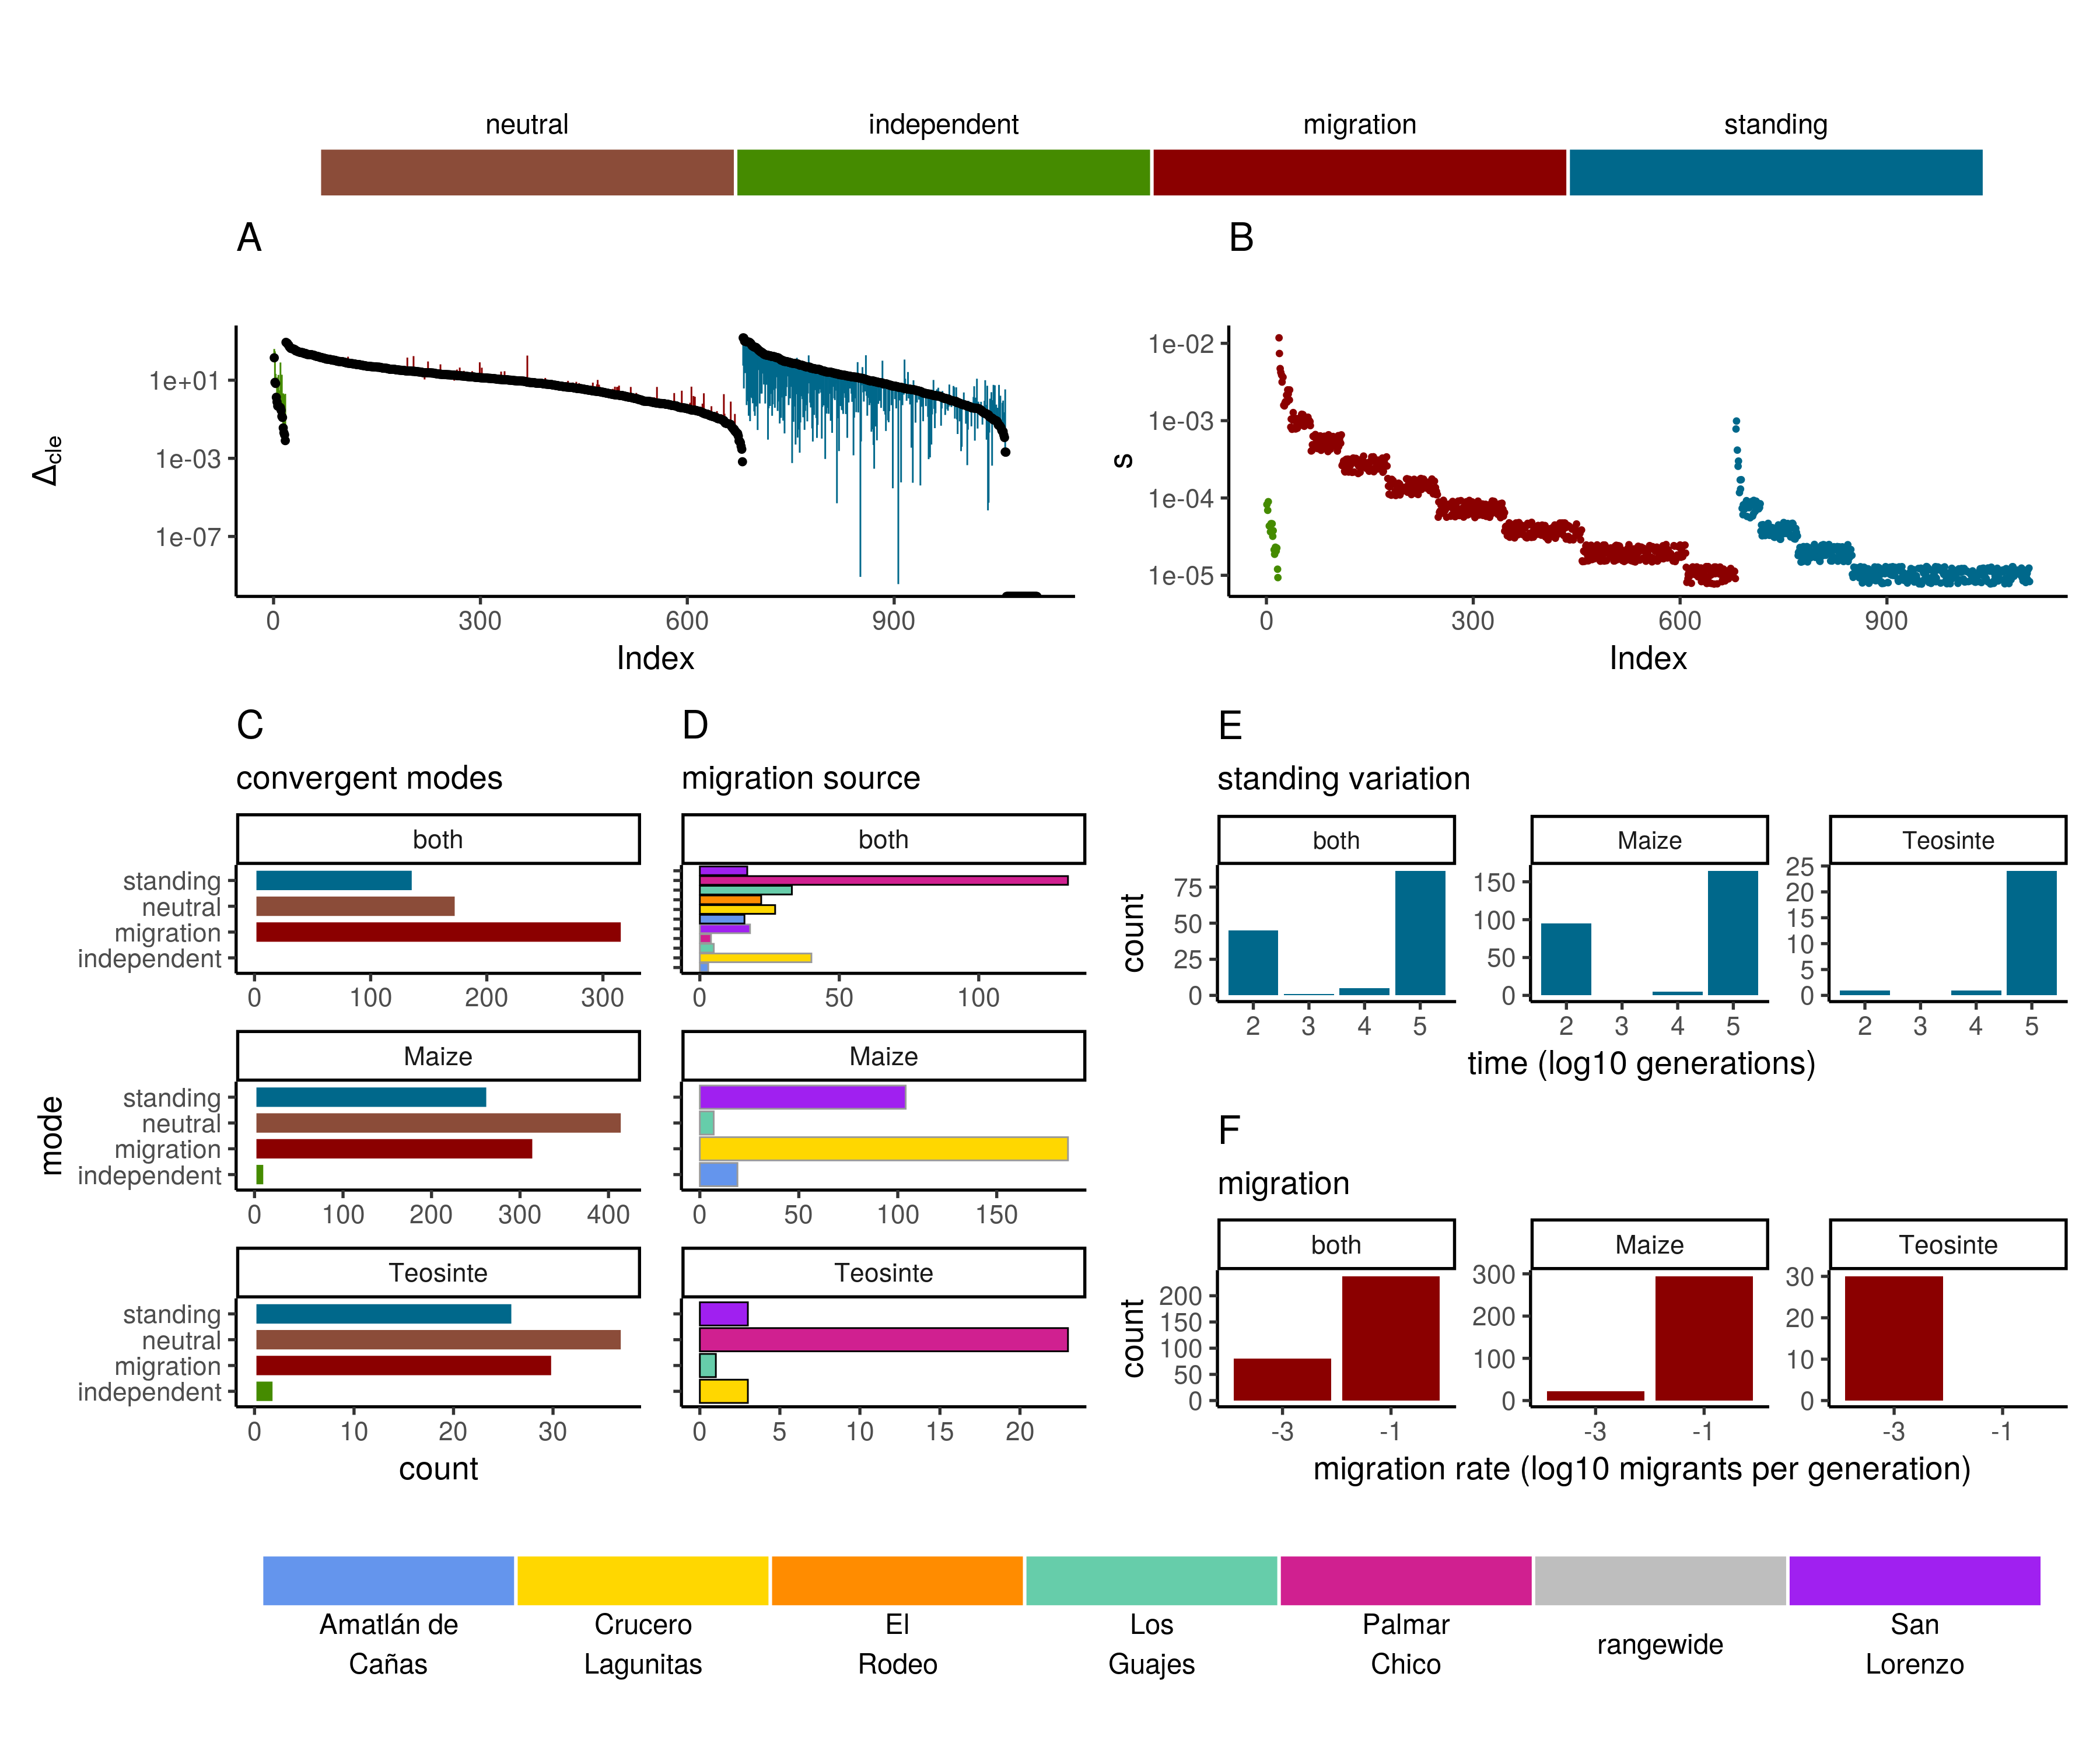

In [18]:

#color_format_df <- color_df %>% 
#    mutate(pop = str_replace_all(pop, "LR_", "Landrace ")) %>% 
#    mutate(pop = str_replace_all(pop, "Teo_", "Teosinte ")) %>% 
#    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
#    mutate(pop = str_remove_all(pop, "random([12])"))


color_format_df <- color_df %>% 
    mutate(pop = str_replace_all(pop, "LR_", "")) %>% 
    mutate(pop = str_replace_all(pop, "Teo_", "")) %>% 
    mutate(pop = str_replace_all(pop, "_", " ")) %>% 
    mutate(pop = str_remove_all(pop, "random([12])"))


FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

id_df <- tibble(sources = 1:length(FREQ_POPS), pop_id = FREQ_POPS) 

top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(n())

top_models_df %>% 
    group_by(model2) %>% 
    summarise(n())

nrow(top_models_df)

mode_plot <- top_models_df %>% 
    group_by(type, model2) %>% 
    summarise(counts = n()) %>% 
    ggplot(aes(model2, counts, fill = model2)) + 
    geom_bar(stat = "identity", lwd = 1.1, colour = "white") +
    facet_wrap(~type, scale = "free", ncol = 1) +
    coord_flip() +
    ylab("count") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small)) +
    xlab("mode")


print("HERE!")
head(top_models_df)

src_df  <-  
top_models_df %>%
    filter(model2 == "migration") %>% 
    full_join(., id_df, by = "sources")  %>% 
    mutate(ssp_id = ifelse(grepl("Landrace", pop_id), "Landrace", "Teosinte")) %>% 
    mutate(pop_id2 = pop_id) %>% 
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop"))

source_plot <- 
src_df  %>%
    ggplot(aes(pop_id2, fill = color, colour = ssp_id)) +
    geom_bar(stat = "count", position = position_dodge(preserve = "single"), lwd = 0.5) +
    xlab("Population") +
    ylab("count") +
    facet_wrap(~type, scale = "free", ncol = 1, drop = FALSE) +
    scale_x_discrete(drop=FALSE) +
    coord_flip() +
    scale_fill_identity() +
    scale_color_manual(values = c("Teosinte" = "black", "Landrace" = "grey60")) +
    theme( 
        strip.text.x = element_text(size = tts_small),
        legend.position = "n",
        axis.title = element_blank(),
        axis.text.y = element_blank()
    )


time_plot <- top_models_df %>%
    filter(model2 == "standing") %>% 
    ggplot(aes(log10(times), fill = model2)) +
    geom_bar(stat = "count") +
    ylab("count") +
    xlab("time (log10 generations)") +
    facet_wrap(~type, scale = "free_y") +
    scale_fill_manual(values = sel_cols) +
    theme(strip.text.x = element_text(size = tts_small-1)) +
    theme(legend.position = "n")


mig_plot <- top_models_df %>%
    filter(model2 == "migration") %>% 
    ggplot(aes(factor(log10(migs)), fill = model)) +
    geom_bar(stat = "count") +
    ylab("count") +
    xlab("migration rate (log10 migrants per generation)") +
    facet_wrap(~type, scale = "free_y") +
    scale_fill_manual(values = sel_cols) +
    theme(legend.position = "n", strip.text.x = element_text(size = tts_small))


options(repr.plot.width = 18, repr.plot.height = 15, repr.plot.res = 200)

mode_leg(size = 6, nud = 1) /
(((mode_mcle + ggtitle(label = "A", subtitle = "")) +
 (mode_sels + ggtitle(label = "B", subtitle = "")))) / 
((mode_plot + ggtitle("C", subtitle = "convergent modes") + source_plot + ggtitle("D", subtitle = "migration source")) | 
( (time_plot + ggtitle("E", subtitle = "standing variation")) / (mig_plot + ggtitle("F", subtitle = "migration")))) /
 make_legplot(text_size = 6) +
plot_layout(nrow = 4, heights = c(7,10,20,7))
ggsave("../figures/Figure5.pdf", width = 15, height = 15)


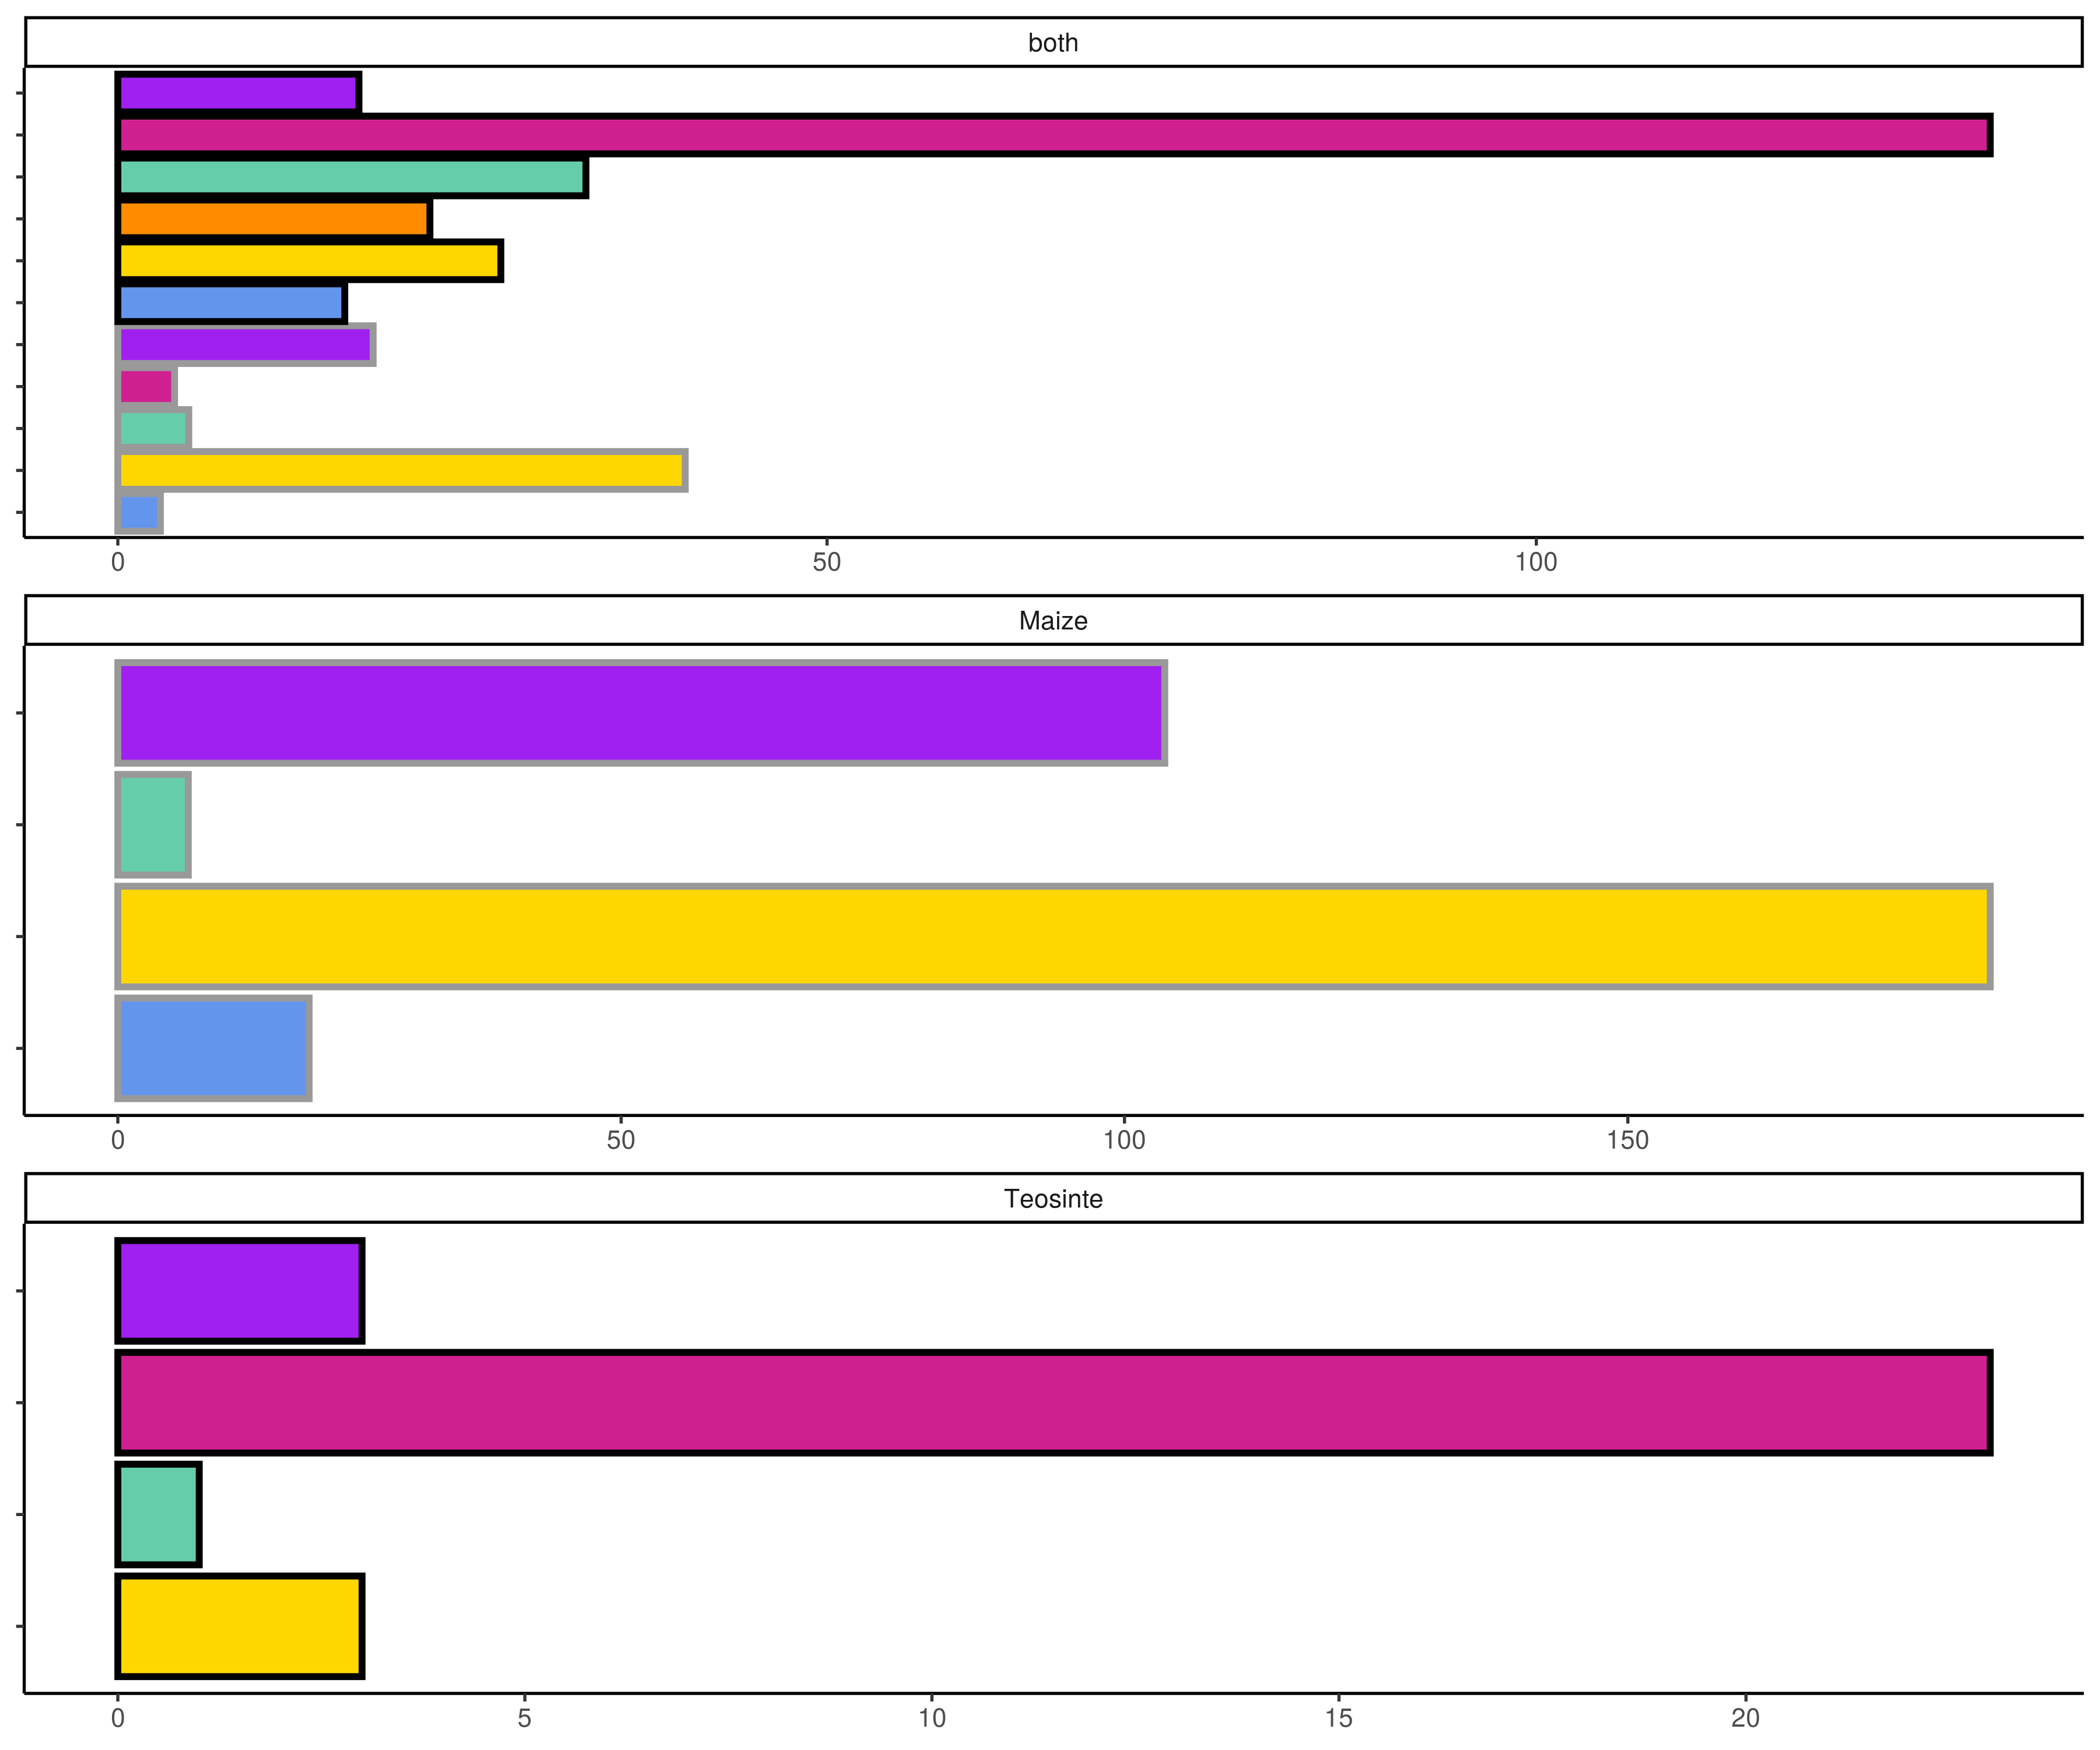

In [19]:
src_df  <-  
top_models_df %>%
    filter(model2 == "migration") %>% 
    full_join(., id_df, by = "sources")  %>% 
    mutate(ssp_id = ifelse(grepl("Landrace", pop_id), "Landrace", "Teosinte")) %>% 
    mutate(pop_id2 = pop_id) %>% 
    mutate(pop_id = str_remove_all(pop_id, "(Landrace |Teosinte )")) %>% 
    left_join(., color_format_df, by = c("pop_id" = "pop"))

src_df  %>%
    ggplot(aes(pop_id2, fill = color, colour = ssp_id)) +
    geom_bar(stat = "count", position = position_dodge(preserve = "single"), lwd = 2) +
    xlab("Population") +
    ylab("count") +
    facet_wrap(~type, scale = "free", ncol = 1, drop = FALSE) +
    scale_x_discrete(drop=FALSE) +
    coord_flip() +
    scale_fill_identity() +
    scale_color_manual(values = c("Teosinte" = "black", "Landrace" = "grey60")) +
    theme( 
        strip.text.x = element_text(size = tts_small),
        legend.position = "n",
        axis.title = element_blank(),
        axis.text.y = element_blank()
    )


count pop with_alt
1  58   Teo without 
2 457   Teo with    
3 592   LR  without 
4 457   LR  with

model2      sum(Landraces_count) sum(Teosinte_count) n()
1 independent   4                    4                   3
2 migration   780                  449                 317
3 neutral     421                  257                 174
4 standing    421                  236                 137

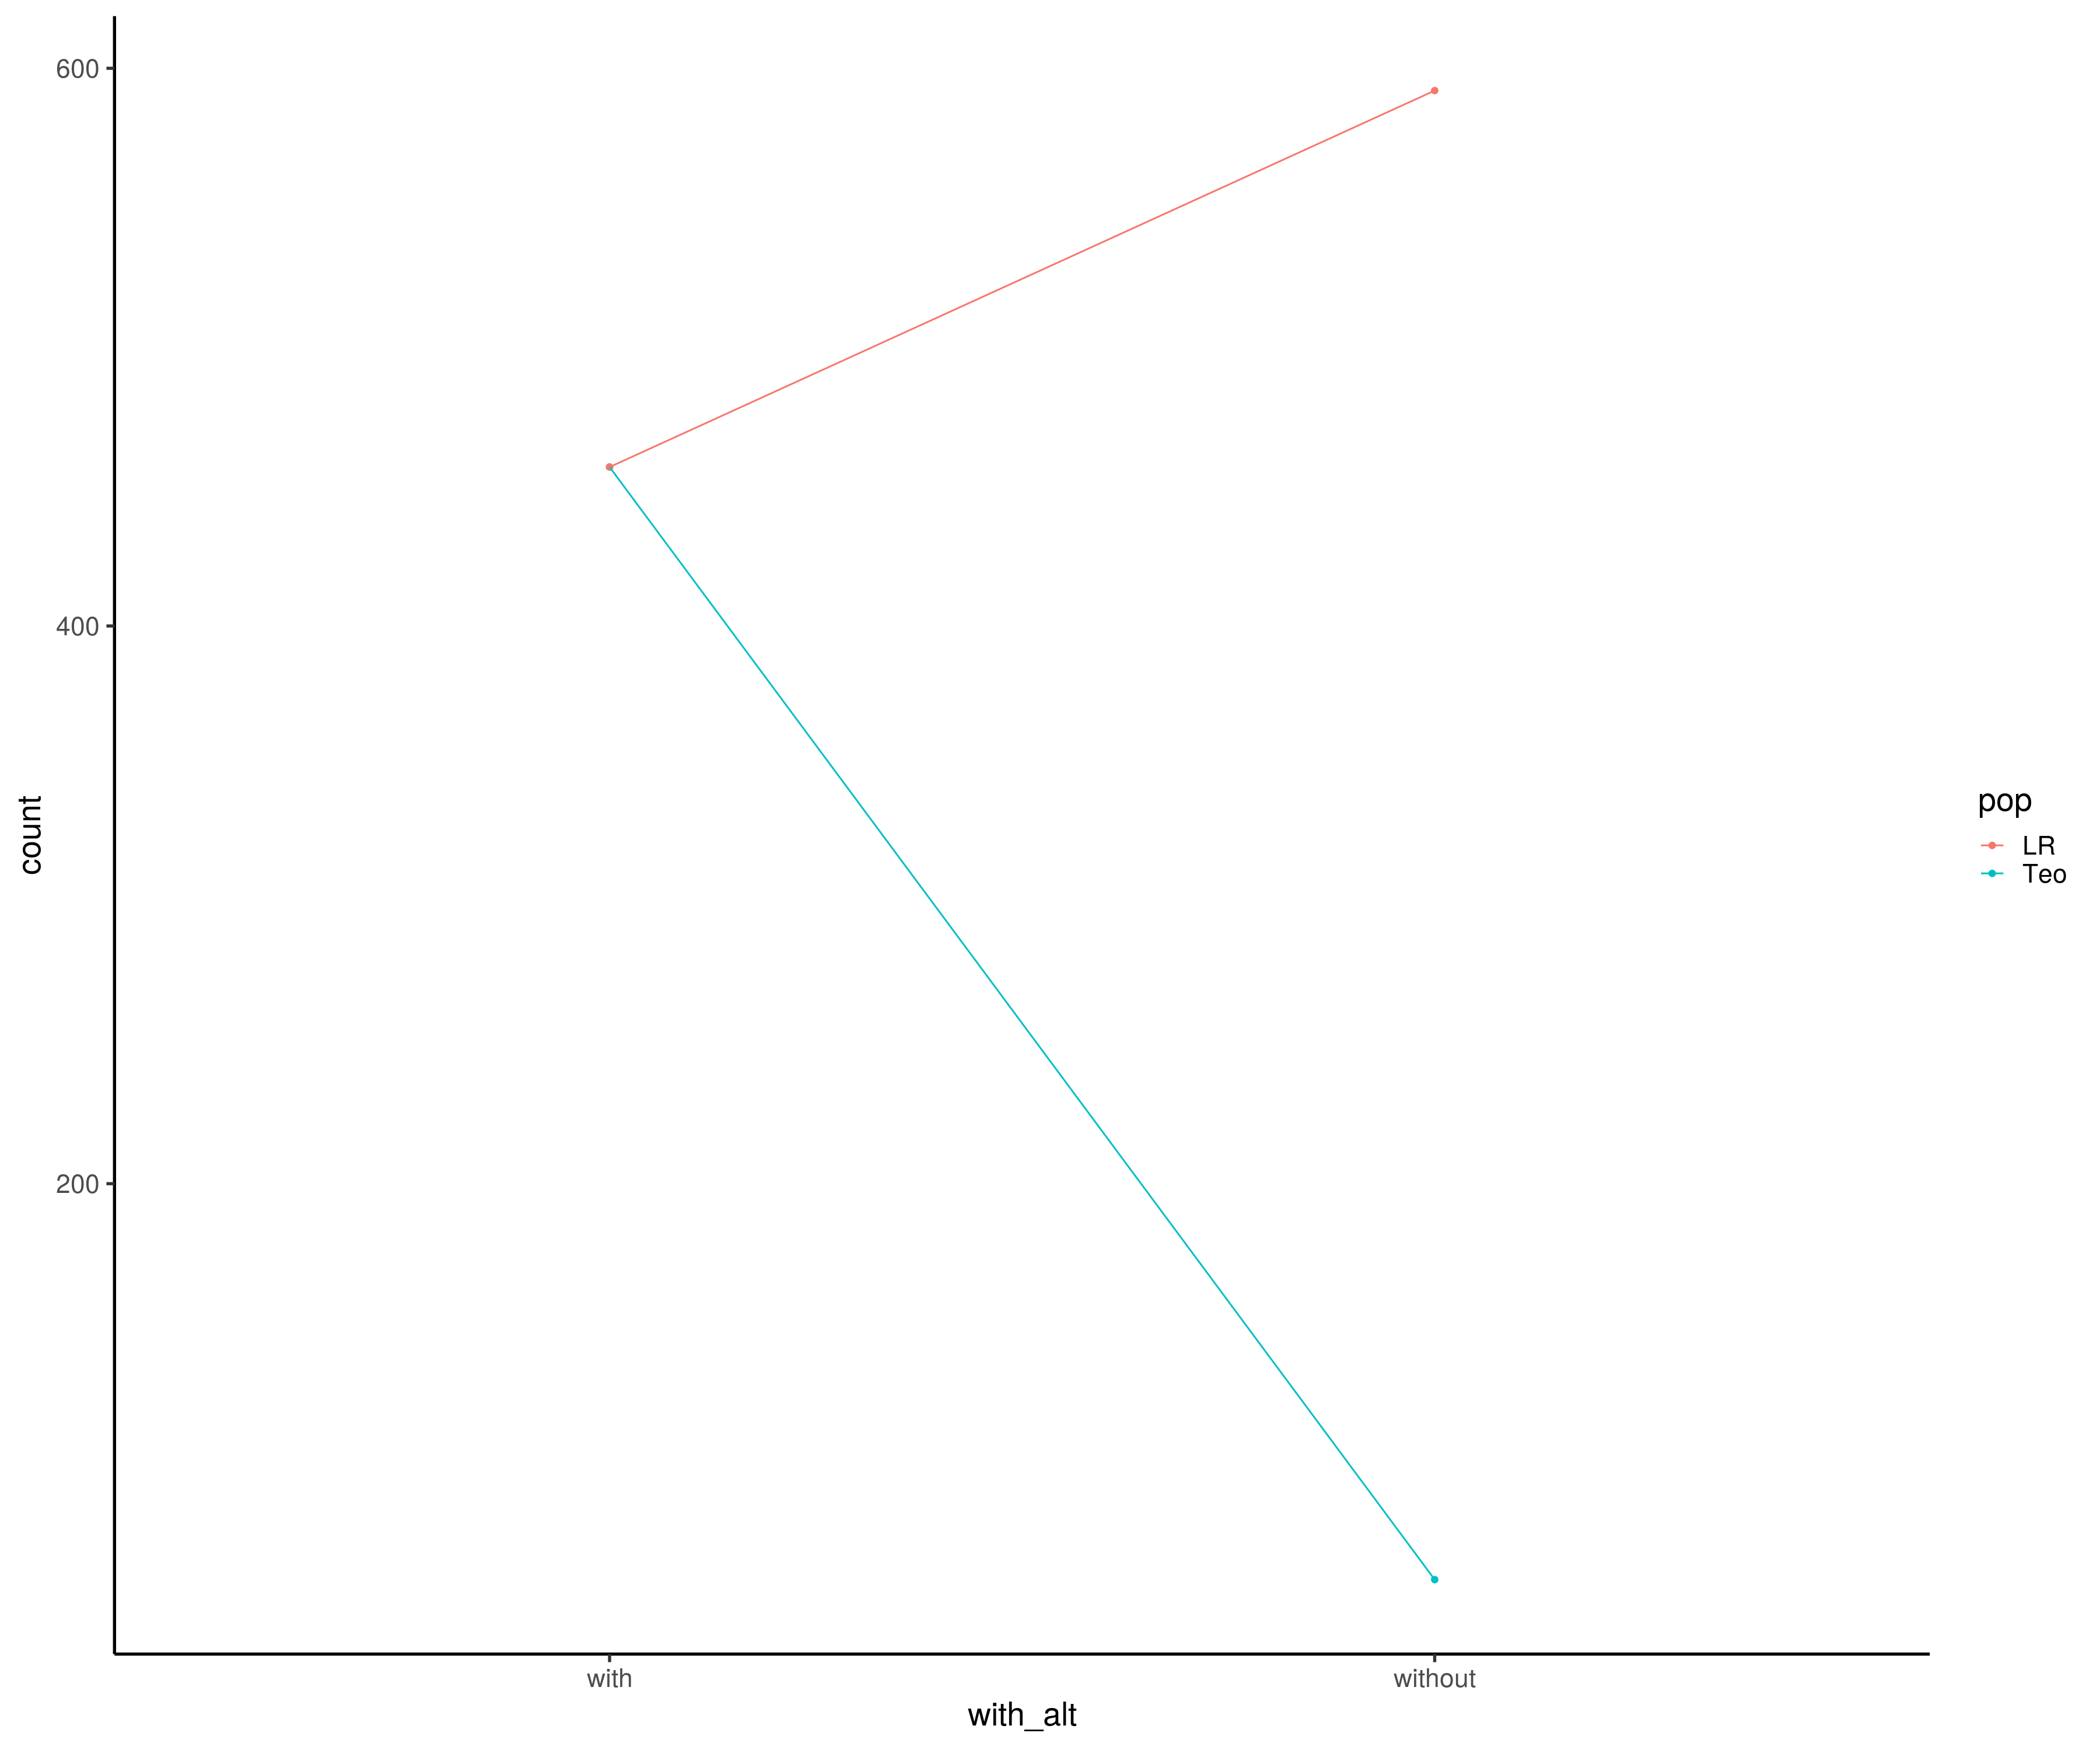

In [20]:
nonneut <- top_models_df %>% filter(model2 != "neutral")

MN <- 1
TEO_noLR <- nonneut %>% filter(Landraces_count == 0, Teosinte_count >= MN)  %>% nrow()
TEO_LR <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count >= MN) %>% nrow()
LR_noTeo <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count == 0)  %>% nrow()
LR_TEO <- nonneut %>% filter(Landraces_count >= MN, Teosinte_count >= MN) %>% nrow()

cross_df <- tibble(
    count = c(TEO_noLR, TEO_LR, LR_noTeo, LR_TEO),
    pop = c("Teo", "Teo", "LR", "LR"),
    with_alt = c("without", "with", "without", "with")
) 

cross_df

cross_df %>% 
group_by(pop) %>% 
mutate(count2 = count/max(count)) %>% 
ggplot(aes(with_alt, count, group = pop, colour = pop)) +
geom_point() +
geom_line()



top_models_df %>% 
  filter(type == "both") %>% 
  group_by(model2) %>% 
  summarise(
      sum(Landraces_count),
      sum(Teosinte_count),
      n()
  )


`summarise()` has grouped output by 'ssp'. You can override using the `.groups` argument.



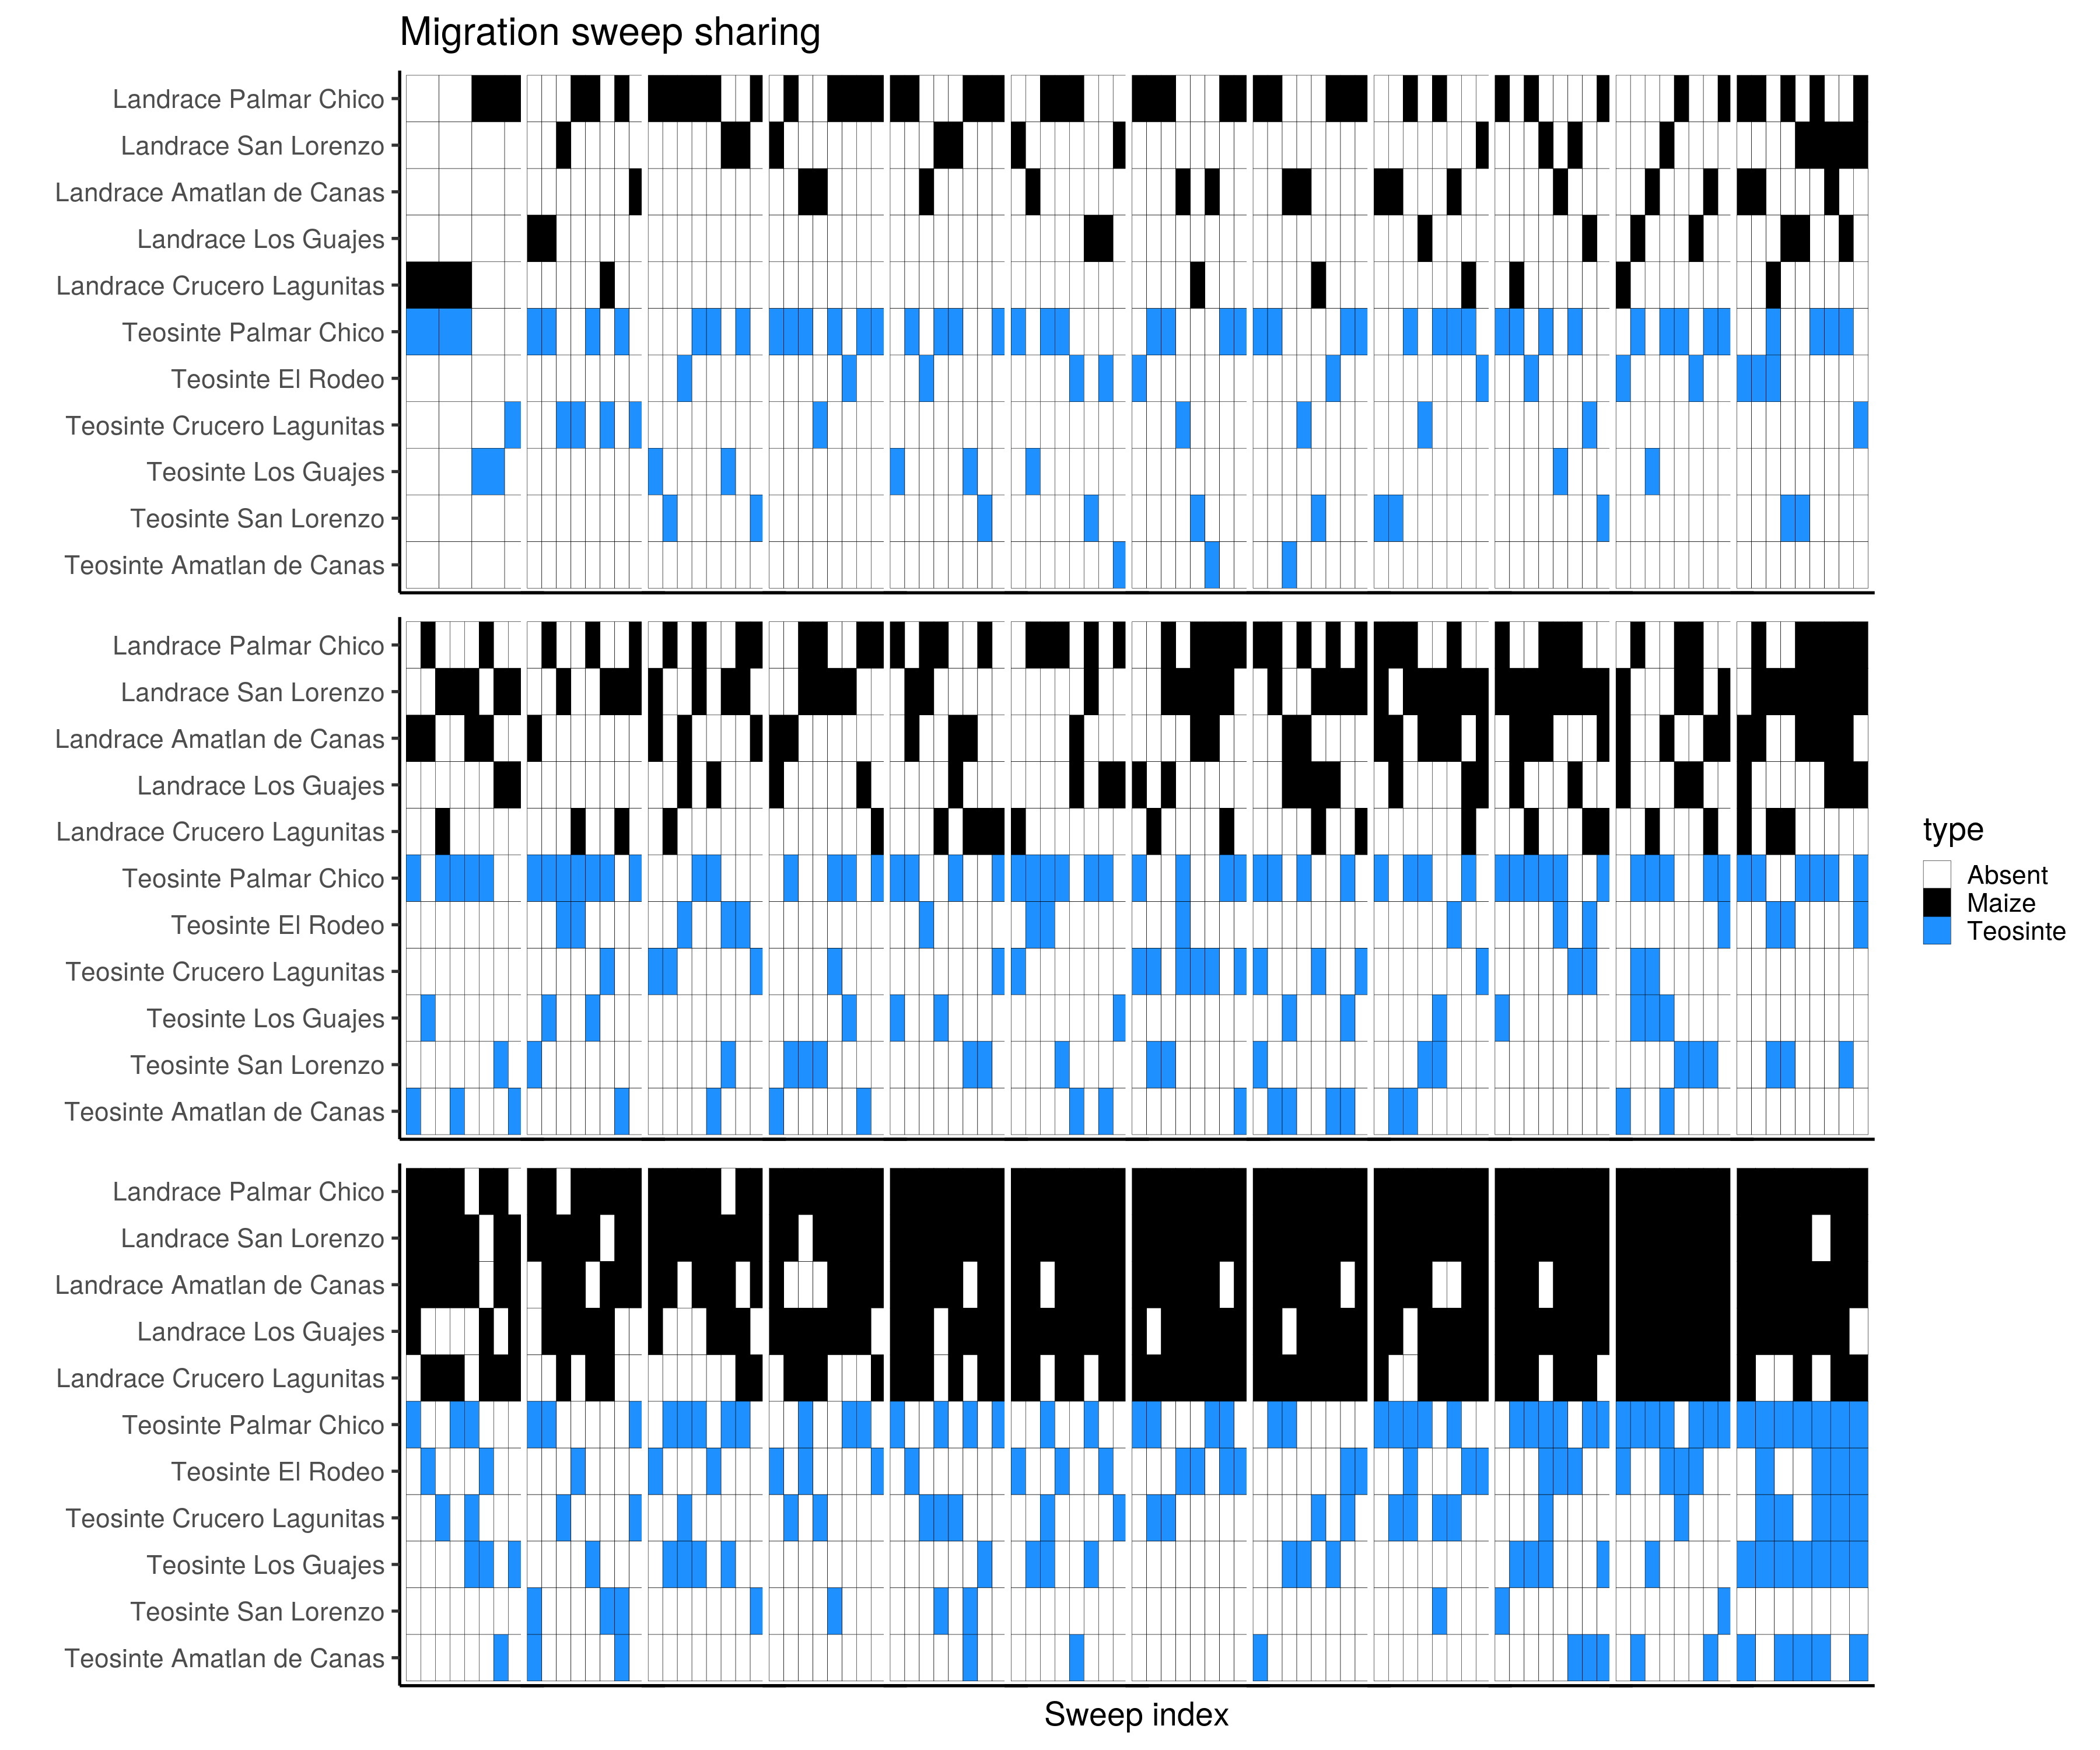

In [31]:

msweep_df <- 
top_models_df %>%  
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    arrange(pop_count) %>% 
    pull(populations) %>%
    str_replace_all("_|--", " ") %>% 
    str_replace_all("LR", "Landrace") %>% 
    str_replace_all("Teo", "Teosinte") %>%
    str_remove_all("RANDOM1 ") %>% 
    map_dfr(~{
        count_vec <- str_count(.x, FREQ_POPS)
        names(count_vec) <- FREQ_POPS
        count_vec
    }) %>% 
    mutate(
        sweep_id = 1:n(), 
        sweep_group = round(sweep_id / 9, 0)) %>%
    pivot_longer(-c(sweep_id, sweep_group), names_to = "pop", values_to = "sweep")

pop_order <- 
msweep_df %>%
    mutate(ssp = ifelse(grepl("Teosinte", pop), "Teo", "LR")) %>%
    group_by(ssp, pop) %>% 
    summarise(summ = sum(sweep)) %>% 
    arrange(summ) %>% 
    arrange(desc(ssp), summ) %>% 
    pull(pop)


plt <- 
msweep_df %>% 
    mutate(pop = factor(pop, levels = pop_order)) %>% 
    mutate(
        type = case_when( 
            grepl("Teosinte", pop) & sweep == 1 ~ "Teosinte",
            grepl("Teosinte", pop) & sweep == 0 ~ "Absent",
            grepl("Landrace", pop) & sweep == 1 ~ "Landrace",
            grepl("Landrace", pop) & sweep == 0 ~ "Absent"
        ) 
    ) %>% 
    #ggplot(aes(sweep_id, pop, fill = factor(sweep))) +
    ggplot(aes(sweep_id, pop, fill = type)) +
    geom_tile(color = "black") +
    facet_wrap(~sweep_group, scales = "free_x", nrow = 3) +
    xlab("Sweep index") +
    ylab("") +
    theme(
      strip.background = element_blank(),
      strip.text.x = element_blank(),
      axis.text.x = element_blank(),
      axis.ticks.x = element_blank(),
      panel.spacing.x = unit(-1, "lines"),  
    ) +
    scale_fill_manual(labels = c("Absent", "Maize", "Teosinte"), values = c("white", "black", "dodgerblue")) +
    ggtitle("Migration sweep sharing")

plt + ggsave("../figures/supplement_sweeps.pdf", width = 18, height = 15)


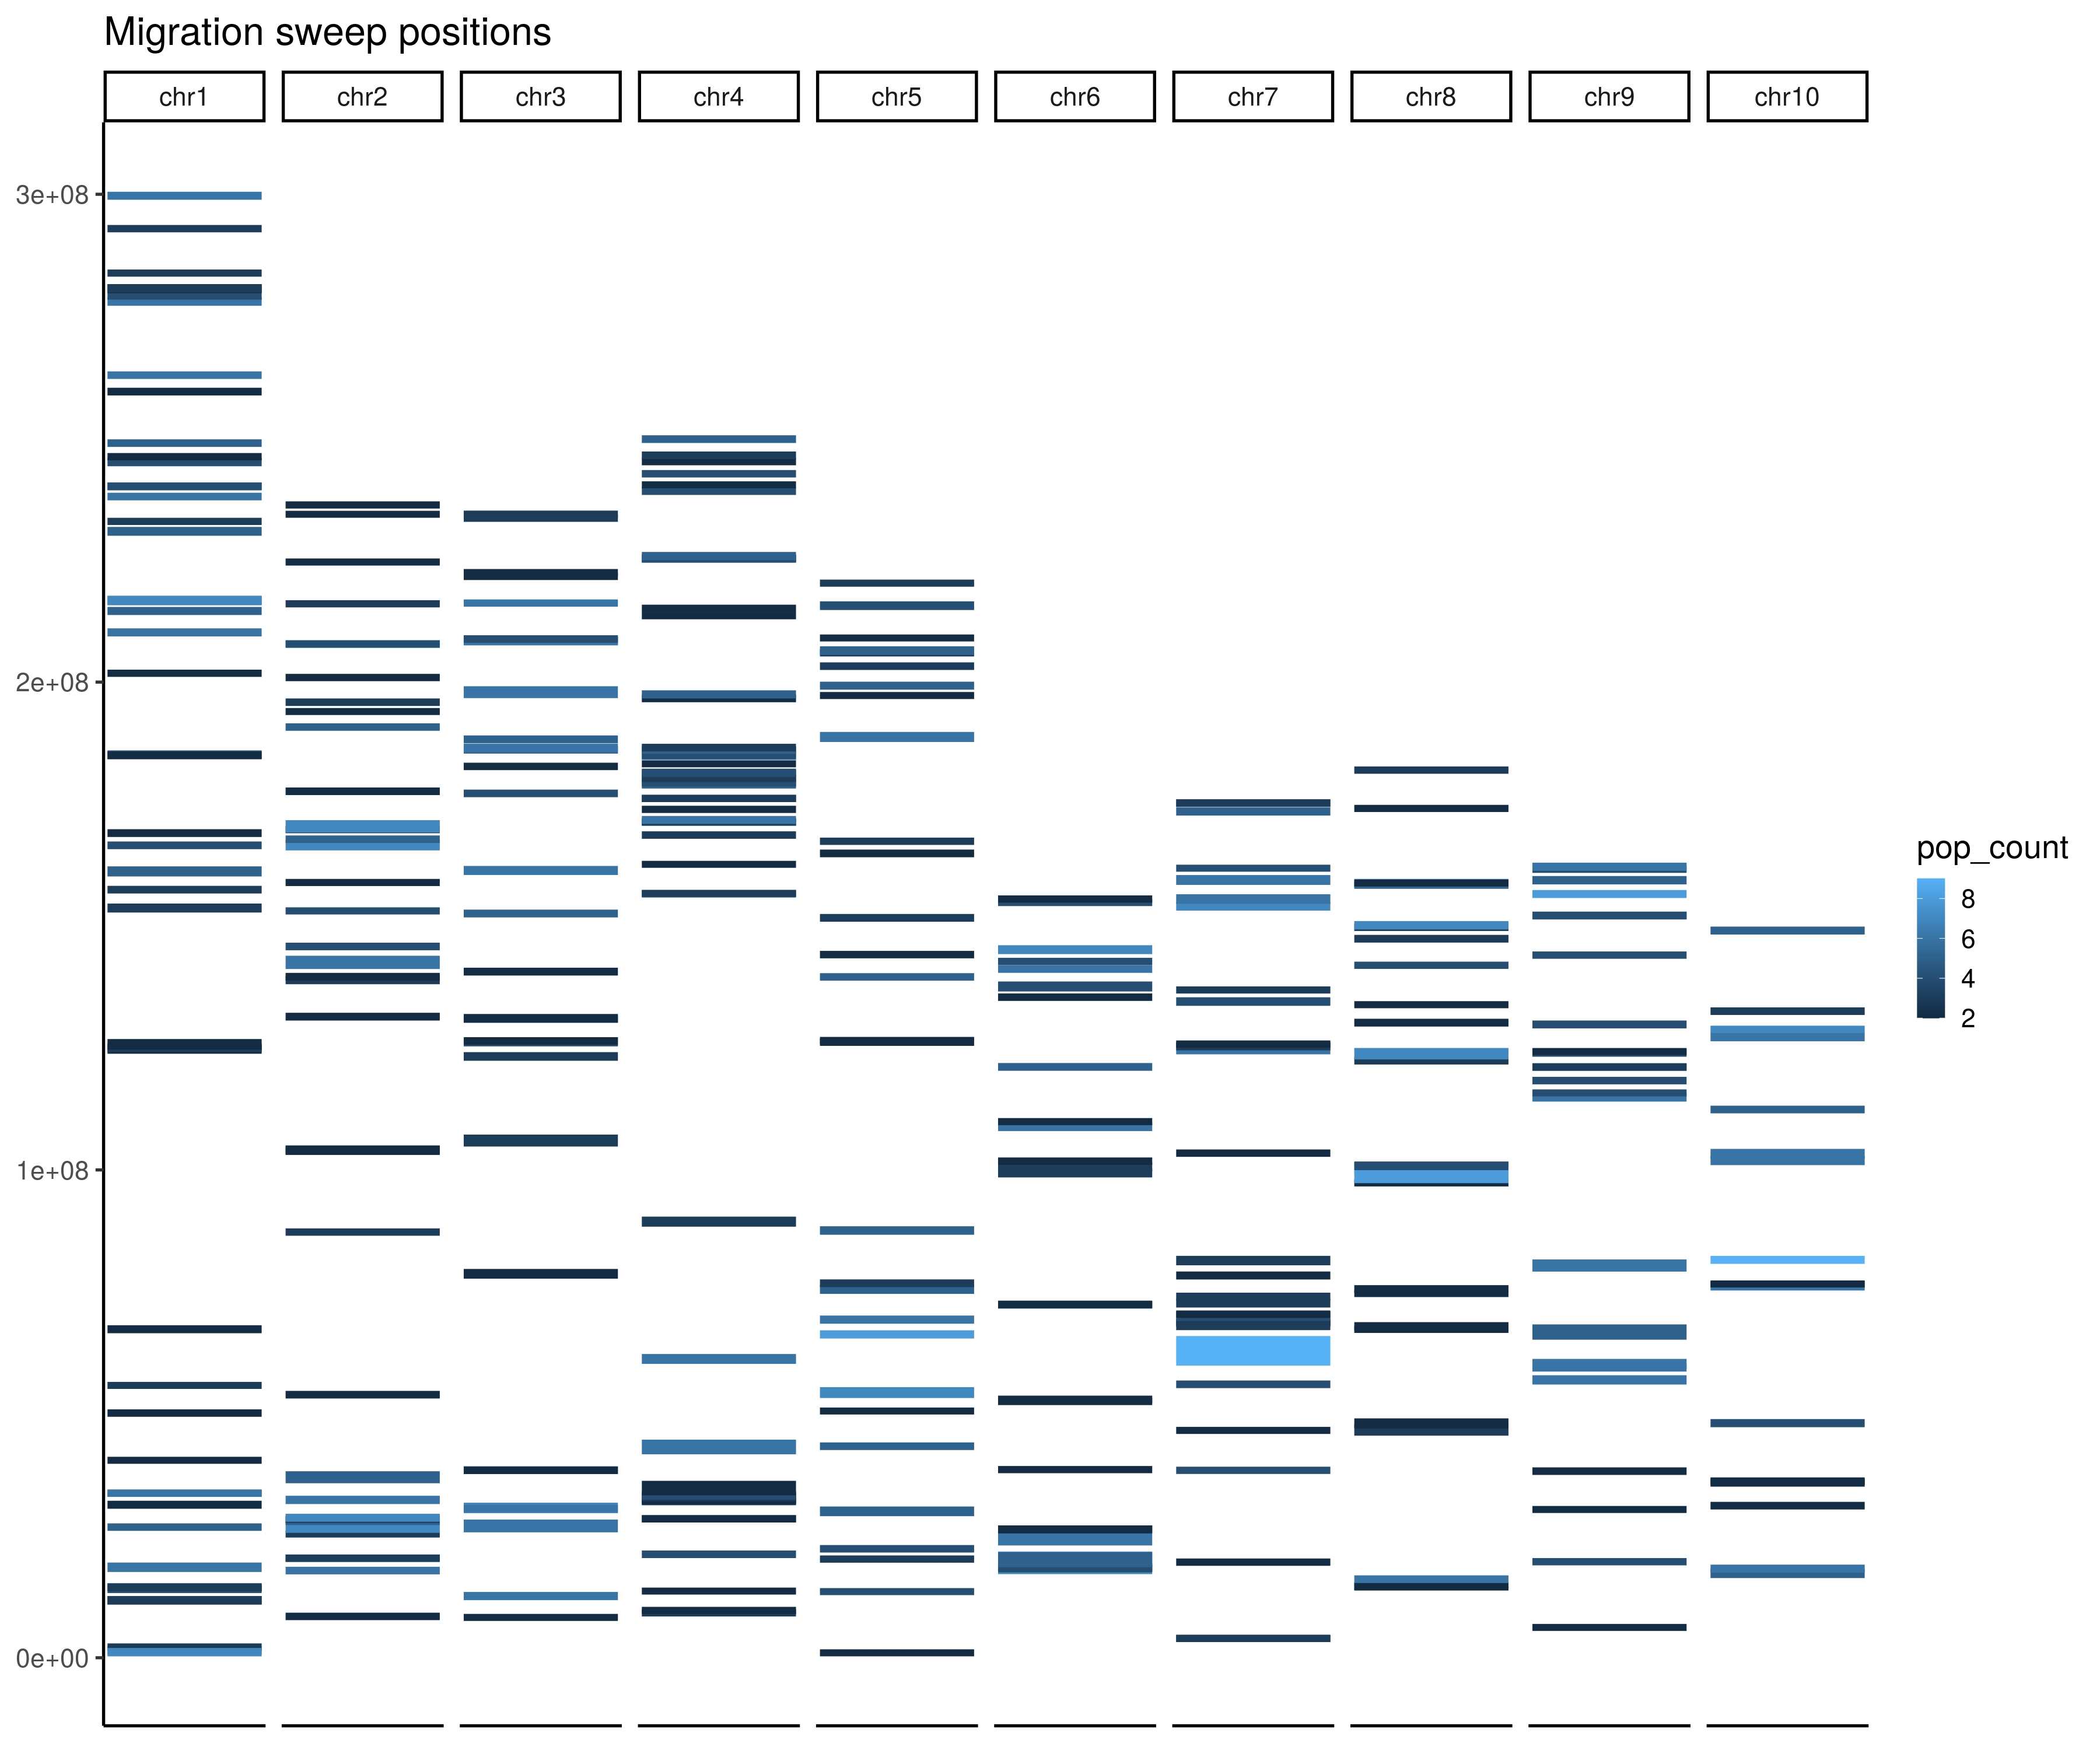

In [33]:
top_models_df %>%
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    mutate(chrom = str_extract(locus, "chr[0-9][0-9]*")) %>%
    mutate(chrom = factor(chrom, levels = paste0("chr", 1:10))) %>% 
    filter(model2 == "migration") %>% 
    filter(type == "both") %>% 
    ggplot() +
    geom_rect(aes(xmin = 0, xmax = 1, ymin = sweep_start_bp, ymax = sweep_end_bp, color = pop_count, fill = pop_count), lwd = 2) +
    facet_grid(~chrom) +
    theme(axis.text.x = element_blank(),
         axis.ticks.x = element_blank()) +
    ggtitle("Migration sweep positions") +
    ggsave("../figures/supplement_sweeps_locs.pdf", width = 14, height = 15)


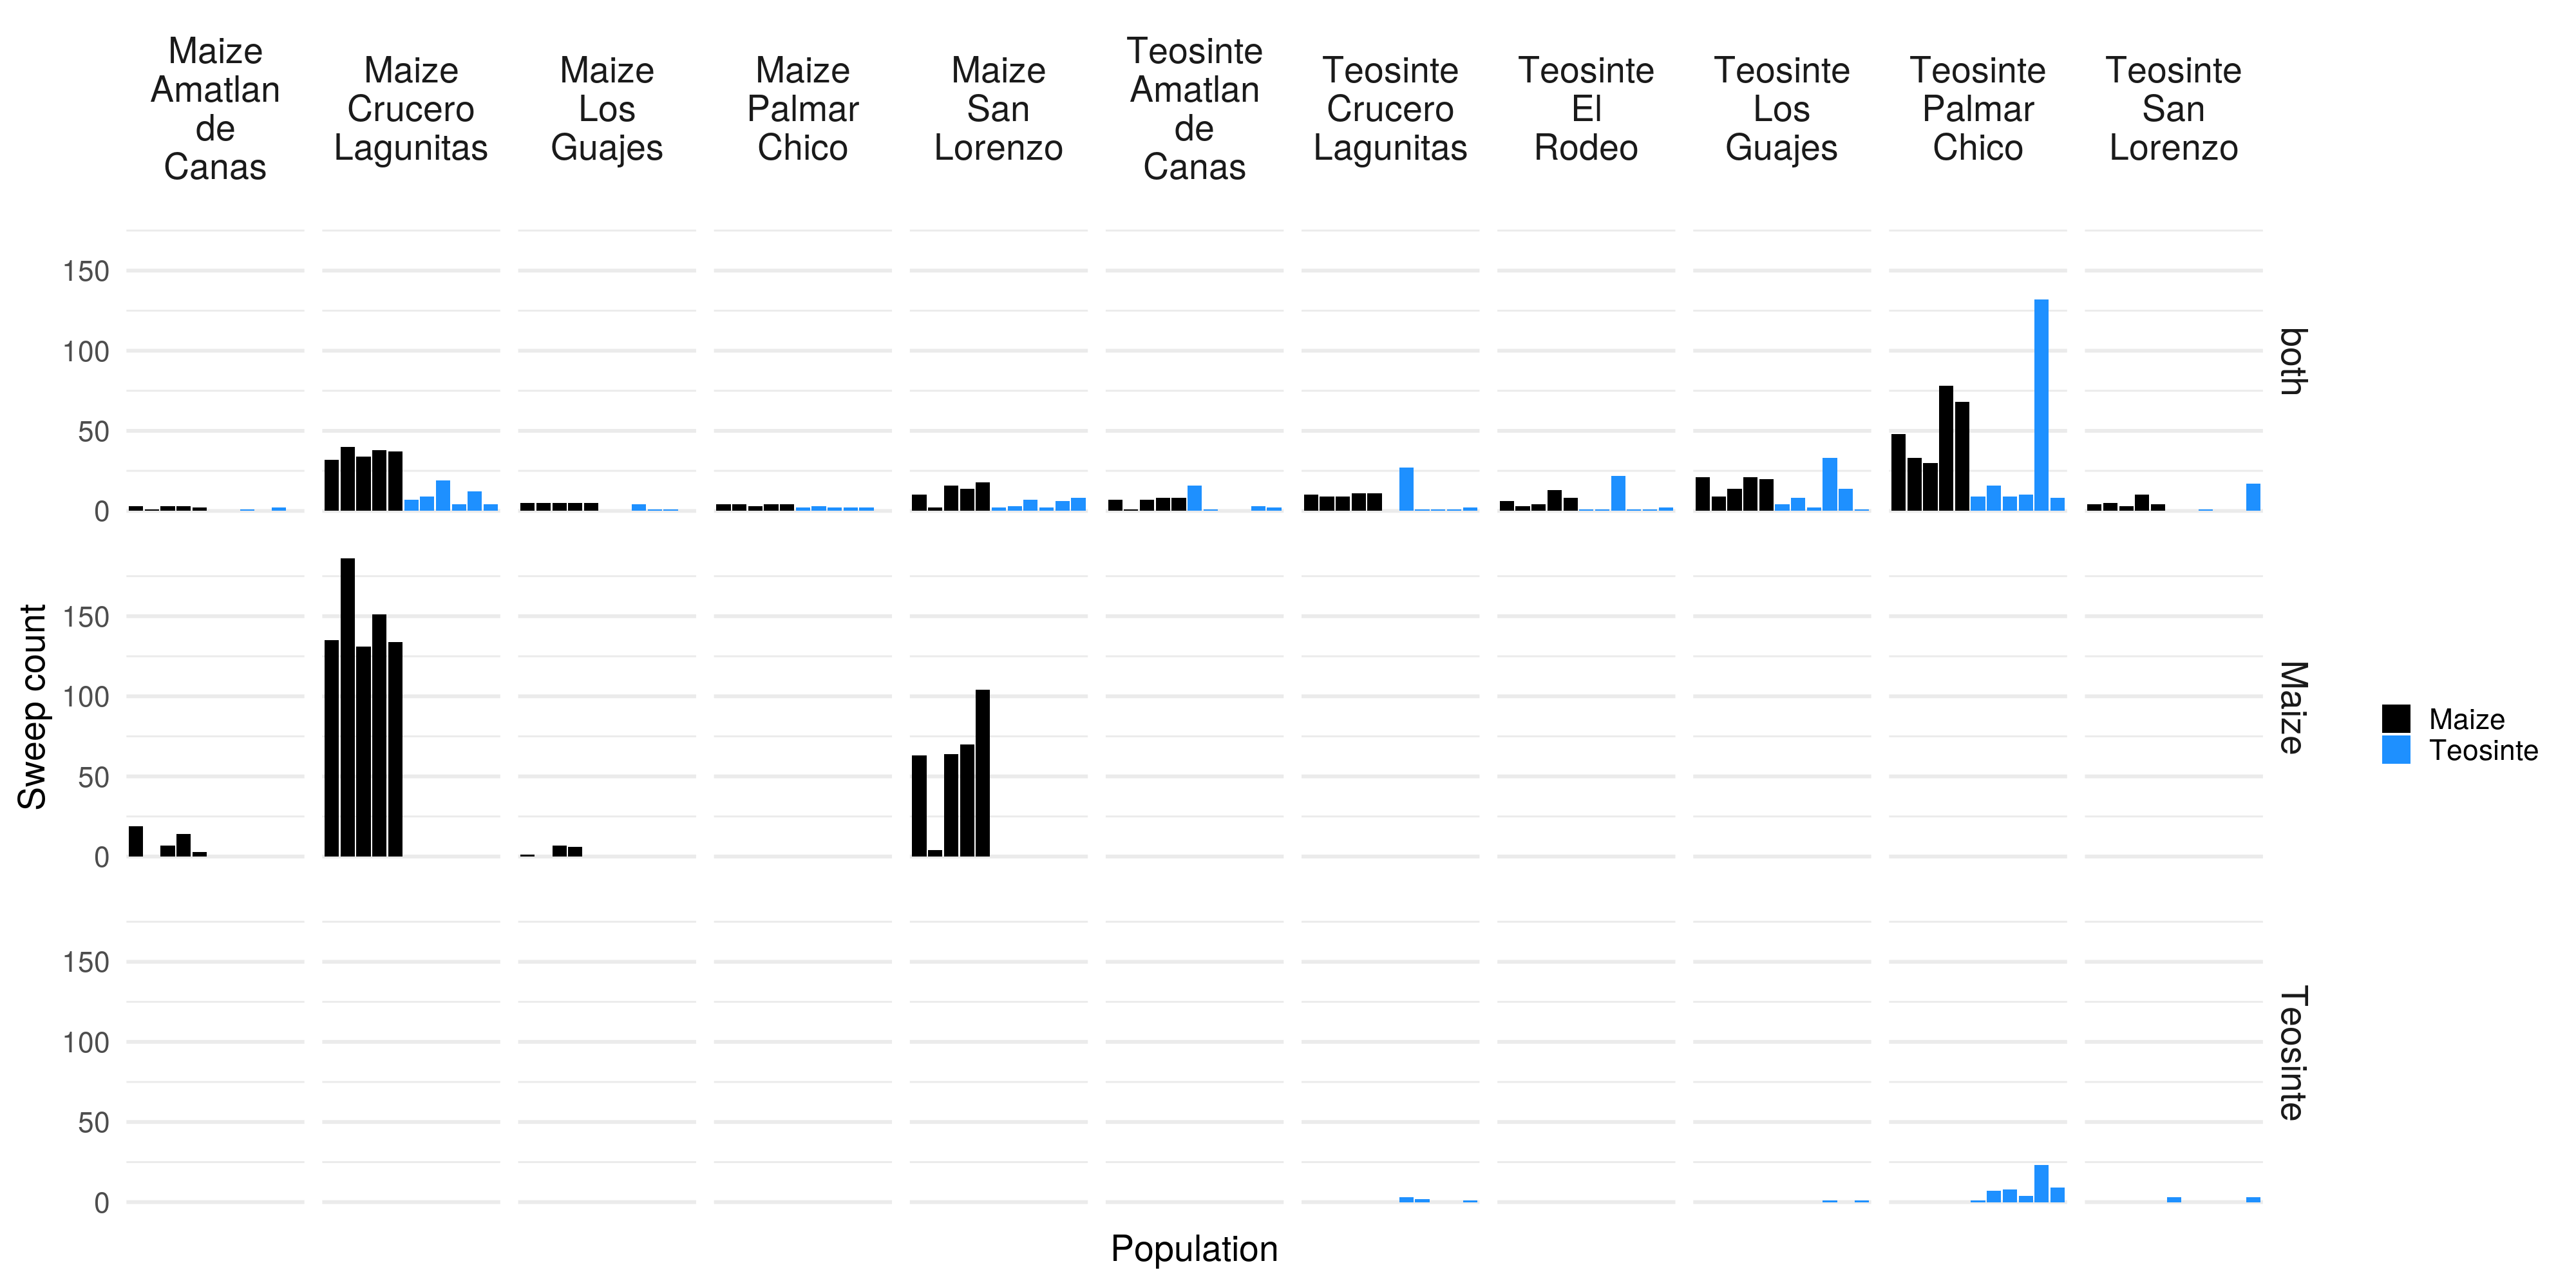

In [46]:
options(repr.plot.width = 20, repr.plot.height = 10, repr.plot.res = 200)

FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

latlong_df <- 
    tibble(
    population = c("Crucero Lagunitas", "Amatlan de Canas", "El Rodeo", "Los Guajes", "San Lorenzo", "Palmar Chico"),
    color = c("gold", "cornflowerblue", "darkorange", "mediumaquamarine", "purple", "violetred"),
    Latitude = c(16.98, 20.82, 16.35, 19.23, 19.94, 18.64),
    Longitude = c(-99.28, -104.41, -97.02, -100.49, -103.99, -100.35),
    altitude = c(590, 880, 982, 985, 982, 1008)
    )

id_vec <- 
str_split(top_models_df$populations, pattern = ";", simplify = T) %>% 
as.matrix(ncol = 1) %>% 
as.vector() %>% 
str_remove_all(" ") %>%
unique()

pops_vec <- 
id_vec %>% 
str_remove_all("v5--") %>%
str_replace_all("--", " ") %>% 
str_replace_all("_", " ")

sourcepop_df <- 
c("both", "Maize", "Teosinte") %>% 
map_df(function(TYPE){
    map_df(FREQ_POPS, function(source_pop){
        expand_grid(pop1 = id_vec) %>%
        filter(str_length(pop1) > 0) %>% 
        pmap_df(function(pop1){
            count <- 
            top_models_df %>% 
            filter(model2 == "migration", type == TYPE,
                   sources == which(FREQ_POPS == source_pop),
                   grepl(pop1, populations)
                  ) %>% 
            nrow()
            tibble(source_pop, pop1, count, type = TYPE)
        })
    })
}) %>% 
    mutate(
        pop1 = str_remove_all(pop1, "v5--"),
        pop1 = str_remove_all(pop1, "RANDOM1"),
        pop1 = str_replace_all(pop1, "--", " "),
        pop1 = str_replace_all(pop1, "_", " "),
        pop1 = str_replace_all(pop1, "  ", " "),
        pop1 = str_replace_all(pop1, "LR", "Maize"),
        pop1 = str_replace_all(pop1, "Teo", "Teosinte")
    ) %>% 
    mutate(ssp = ifelse(grepl("Maize", pop1), "Maize", "Teosinte"),
           source_ssp = ifelse(grepl("Maize", source_pop), "Maize", "Teosinte")) #%>% 
    #filter(source_pop != pop1)

sourcepop_df %>%
    mutate(source_pop = str_replace_all(source_pop, " ", "\n"),
           source_pop = str_replace_all(source_pop, "Landrace", "Maize")
           ) %>% 
    ggplot(aes(pop1, count, fill = ssp)) +
    geom_bar(stat = "identity") +
    facet_grid(type ~ source_pop) +
    theme_minimal(20) +
    theme(axis.text.x = element_blank(), 
         strip.text = element_text(size = 20),
         panel.grid.major.x = element_blank(),
         panel.grid.minor = element_line(size = 0.5), 
         panel.grid.major = element_line(size = 1)
        ) +
    xlab("Population") +
    ylab("Sweep count") +
    scale_fill_manual(values = c("Maize" = "black", "Teosinte" = "dodgerblue")) +
    guides(fill=guide_legend(title="")) +
    ggsave("../figures/supplement_sources.pdf", width = 20, height = 10)



# Just exploratory analyses from here down

object has no named columns; assuming order is lon then lat



[,1]     [,2]     [,3]      [,4]      [,5]    
Landrace Amatlan de Canas        NA 687467.0 446301.36 489208.21 106835.4
Landrace Crucero Lagunitas 687467.0       NA 280029.78 215922.31 595620.5
Landrace Los Guajes        446301.4 280029.8        NA  66952.05 375522.6
Landrace Palmar Chico      489208.2 215922.3  66952.05        NA 408745.3
Landrace San Lorenzo       106835.4 595620.5 375522.60 408745.31       NA
Teosinte Amatlan de Canas       0.0 687467.0 446301.36 489208.21 106835.4
Teosinte Crucero Lagunitas 687467.0      0.0 280029.78 215922.31 595620.5
Teosinte El Rodeo          923433.1 250957.5 486754.30 435064.14 837597.7
Teosinte Los Guajes        446301.4 280029.8      0.00  66952.05 375522.6
Teosinte Palmar Chico      489208.2 215922.3  66952.05      0.00 408745.3
Teosinte San Lorenzo       106835.4 595620.5 375522.60 408745.31      0.0
                           [,6]     [,7]     [,8]     [,9]      [,10]    
Landrace Amatlan de Canas       0.0 687467.0 923433.1 446301.36 489208.21
Landrace Crucero Lagunitas 687467.0      0.0 250957.5 280029.78 215922.31
Landrace Los Guajes        446301.4 280029.8 486754.3      0.00  66952.05
Landrace Palmar Chico      489208.2 215922.3 435064.1  66952.05      0.00
Landrace San Lorenzo       106835.4 595620.5 837597.7 375522.60 408745.31
Teosinte Amatlan de Canas        NA 687467.0 923433.1 446301.36 489208.21
Teosinte Crucero Lagunitas 687467.0       NA 250957.5 280029.78 215922.31
Teosinte El Rodeo          923433.1 250957.5       NA 486754.30 435064.14
Teosinte Los Guajes        446301.4 280029.8 486754.3        NA  66952.05
Teosinte Palmar Chico      489208.2 215922.3 435064.1  66952.05        NA
Teosinte San Lorenzo       106835.4 595620.5 837597.7 375522.60 408745.31
                           [,11]   
Landrace Amatlan de Canas  106835.4
Landrace Crucero Lagunitas 595620.5
Landrace Los Guajes        375522.6
Landrace Palmar Chico      408745.3
Landrace San Lorenzo            0.0
Teosinte Amatlan de Canas  106835.4
Teosinte Crucero Lagunitas 595620.5
Teosinte El Rodeo          837597.7
Teosinte Los Guajes        375522.6
Teosinte Palmar Chico      408745.3
Teosinte San Lorenzo             NA

1        2        3        4        5        6         7         8        
1        NA 12.12436 11.78983 12.28821 10.95445 13.564660 13.601471 13.490738
2  12.12436       NA 11.91638 12.49000 13.45362 10.630146 10.954451 10.246951
3  11.78983 11.91638       NA 11.22497 11.61895 13.747727 14.000000 13.527749
4  12.28821 12.49000 11.22497       NA 11.00000 14.730920 14.352700 14.456832
5  10.95445 13.45362 11.61895 11.00000       NA 15.033296 14.662878 14.899664
6  13.56466 10.63015 13.74773 14.73092 15.03330        NA  5.744563  5.291503
7  13.60147 10.95445 14.00000 14.35270 14.66288  5.744563        NA  6.403124
8  13.49074 10.24695 13.52775 14.45683 14.89966  5.291503  6.403124        NA
9  13.30413 10.29563 13.26650 14.14214 14.79865  5.744563  6.480741  6.082763
10 13.89244 11.13553 13.63818 14.14214 14.31782  7.549834  7.745967  7.937254
11 13.78405 10.81665 13.52775 14.59452 14.96663  4.898979  6.244998  5.477226
   9         10        11       
1  13.304135 13.892444 13.784049
2  10.295630 11.135529 10.816654
3  13.266499 13.638182 13.527749
4  14.142136 14.142136 14.594520
5  14.798649 14.317821 14.966630
6   5.744563  7.549834  4.898979
7   6.480741  7.745967  6.244998
8   6.082763  7.937254  5.477226
9         NA  7.615773  6.244998
10  7.615773        NA  8.426150
11  6.244998  8.426150        NA

$z.stat
[1] 224162546

$p
[1] 0.299

$alternative
[1] "two.sided"

[,1]     [,2]     [,3]      [,4]      [,5]    
Landrace Amatlan de Canas        NA 687467.0 446301.36 489208.21 106835.4
Landrace Crucero Lagunitas 687467.0       NA 280029.78 215922.31 595620.5
Landrace Los Guajes        446301.4 280029.8        NA  66952.05 375522.6
Landrace Palmar Chico      489208.2 215922.3  66952.05        NA 408745.3
Landrace San Lorenzo       106835.4 595620.5 375522.60 408745.31       NA
Teosinte Amatlan de Canas       0.0 687467.0 446301.36 489208.21 106835.4
Teosinte Crucero Lagunitas 687467.0      0.0 280029.78 215922.31 595620.5
Teosinte El Rodeo          923433.1 250957.5 486754.30 435064.14 837597.7
Teosinte Los Guajes        446301.4 280029.8      0.00  66952.05 375522.6
Teosinte Palmar Chico      489208.2 215922.3  66952.05      0.00 408745.3
Teosinte San Lorenzo       106835.4 595620.5 375522.60 408745.31      0.0
                           [,6]     [,7]     [,8]     [,9]      [,10]    
Landrace Amatlan de Canas       0.0 687467.0 923433.1 446301.36 489208.21
Landrace Crucero Lagunitas 687467.0      0.0 250957.5 280029.78 215922.31
Landrace Los Guajes        446301.4 280029.8 486754.3      0.00  66952.05
Landrace Palmar Chico      489208.2 215922.3 435064.1  66952.05      0.00
Landrace San Lorenzo       106835.4 595620.5 837597.7 375522.60 408745.31
Teosinte Amatlan de Canas        NA 687467.0 923433.1 446301.36 489208.21
Teosinte Crucero Lagunitas 687467.0       NA 250957.5 280029.78 215922.31
Teosinte El Rodeo          923433.1 250957.5       NA 486754.30 435064.14
Teosinte Los Guajes        446301.4 280029.8 486754.3        NA  66952.05
Teosinte Palmar Chico      489208.2 215922.3 435064.1  66952.05        NA
Teosinte San Lorenzo       106835.4 595620.5 837597.7 375522.60 408745.31
                           [,11]   
Landrace Amatlan de Canas  106835.4
Landrace Crucero Lagunitas 595620.5
Landrace Los Guajes        375522.6
Landrace Palmar Chico      408745.3
Landrace San Lorenzo            0.0
Teosinte Amatlan de Canas  106835.4
Teosinte Crucero Lagunitas 595620.5
Teosinte El Rodeo          837597.7
Teosinte Los Guajes        375522.6
Teosinte Palmar Chico      408745.3
Teosinte San Lorenzo             NA

1         2         3         4         5         6         7        
1         NA  9.327379  8.602325  8.831761  8.062258 10.099505 10.000000
2   9.327379        NA  9.219544  9.539392 10.198039  7.937254  8.185353
3   8.602325  9.219544        NA  8.831761  9.000000 10.392305 10.583005
4   8.831761  9.539392  8.831761        NA  7.810250 10.770330 10.392305
5   8.062258 10.198039  9.000000  7.810250        NA 11.090537 10.630146
6  10.099505  7.937254 10.392305 10.770330 11.090537        NA  4.242641
7  10.000000  8.185353 10.583005 10.392305 10.630146  4.242641        NA
8  10.099505  7.810250 10.392305 10.583005 11.000000  4.472136  5.099020
9  10.049876  7.615773 10.148892 10.440307 11.045361  3.872983  4.795832
10 10.392305  8.062258 10.198039 10.583005 10.535654  5.656854  5.656854
11 10.295630  8.185353 10.099505 10.583005 10.908712  4.242641  5.099020
   8         9         10        11       
1  10.099505 10.049876 10.392305 10.295630
2   7.810250  7.615773  8.062258  8.185353
3  10.392305 10.148892 10.198039 10.099505
4  10.583005 10.440307 10.583005 10.583005
5  11.000000 11.045361 10.535654 10.908712
6   4.472136  3.872983  5.656854  4.242641
7   5.099020  4.795832  5.656854  5.099020
8         NA  4.795832  5.830952  4.690416
9   4.795832        NA  5.567764  4.582576
10  5.830952  5.567764        NA  6.480741
11  4.690416  4.582576  6.480741        NA

$z.stat
[1] 168228842

$p
[1] 0.339

$alternative
[1] "two.sided"

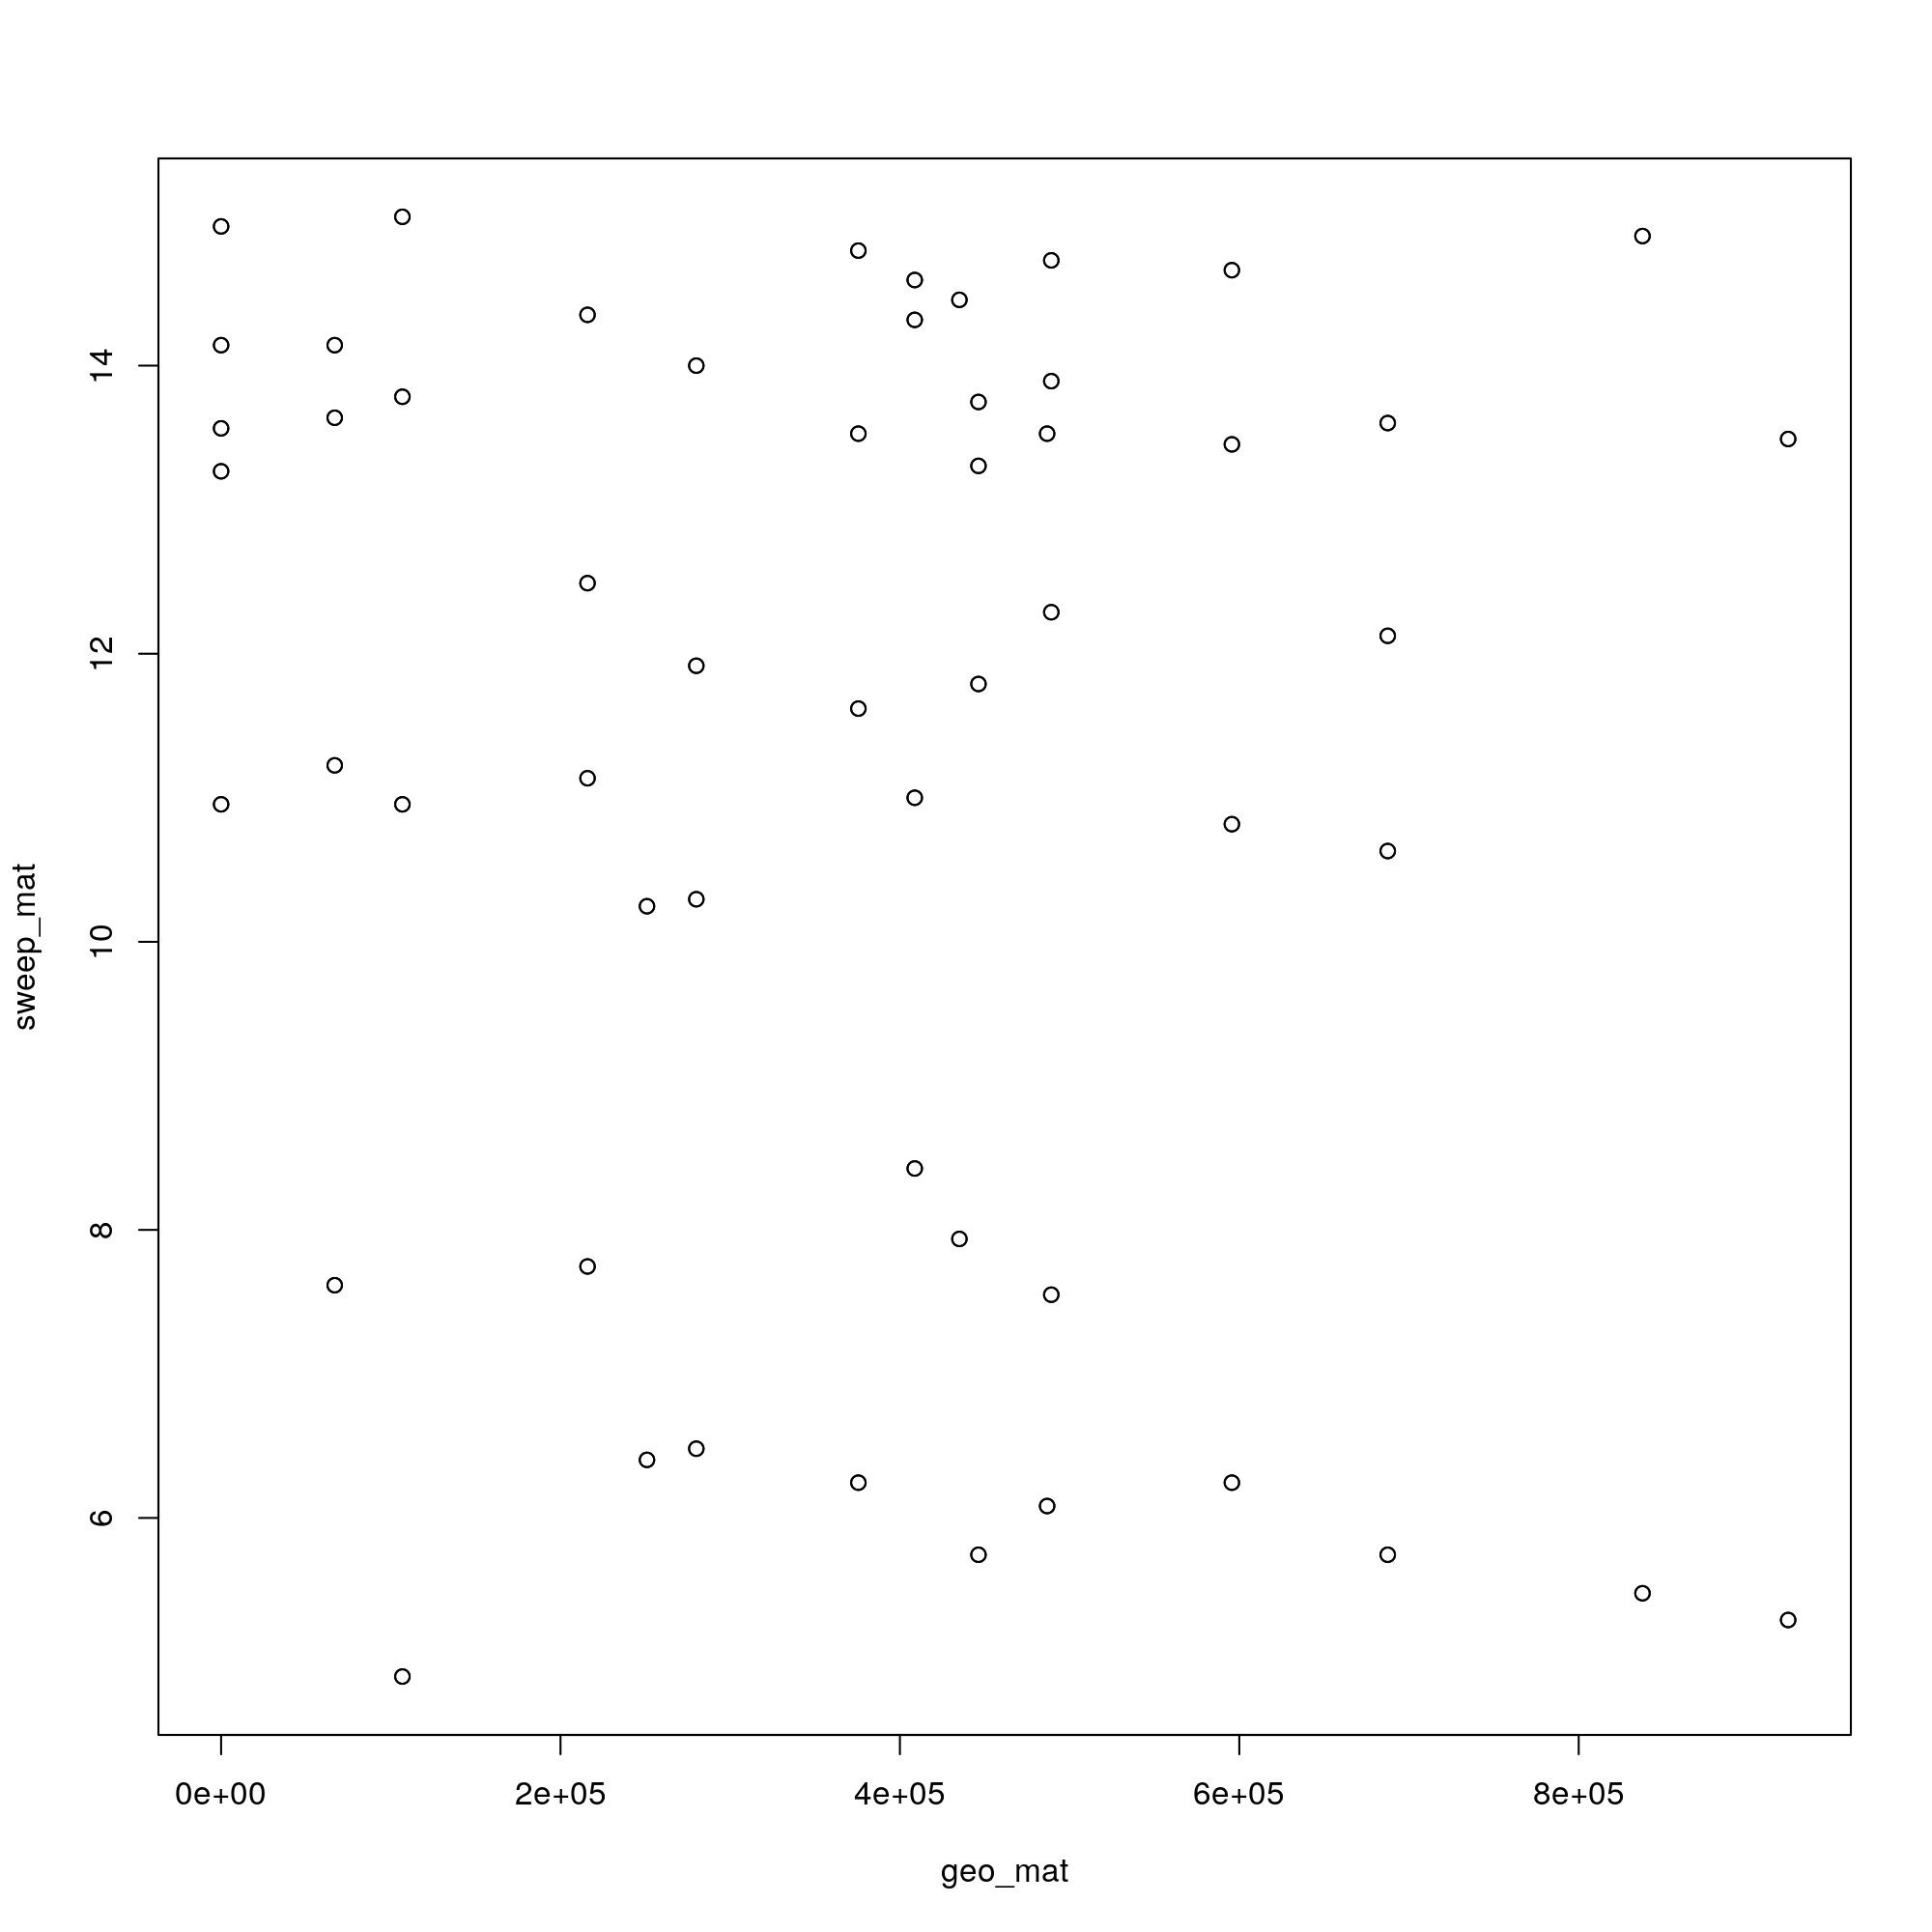

In [35]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

#geography and sharing

pop_ids <- c(
'v5--LR--Amatlan_de_Canas',
'v5--LR--Crucero_Lagunitas',
'v5--LR--Los_Guajes',
'v5--LR--RANDOM1_Palmar_Chico',
'v5--LR--San_Lorenzo',
'v5--Teo--Amatlan_de_Canas',
'v5--Teo--Crucero_Lagunitas',
'v5--Teo--El_Rodeo',
'v5--Teo--Los_Guajes',
'v5--Teo--RANDOM1_Palmar_Chico',
'v5--Teo--San_Lorenzo'
)

FREQ_POPS = c(
    "Landrace Amatlan de Canas",
    "Landrace Crucero Lagunitas",
    "Landrace Los Guajes",
    "Landrace Palmar Chico",
    "Landrace San Lorenzo",
    "Teosinte Amatlan de Canas",
    "Teosinte Crucero Lagunitas",
    "Teosinte El Rodeo",
    "Teosinte Los Guajes",
    "Teosinte Palmar Chico",
    "Teosinte San Lorenzo"
)

latlong_df <- 
    tibble(
    population = c("Landrace Crucero Lagunitas", "Landrace Amatlan de Canas", "Landrace El Rodeo", "Landrace Los Guajes", "Landrace San Lorenzo", "Landrace Palmar Chico", 
                  "Teosinte Crucero Lagunitas", "Teosinte Amatlan de Canas", "Teosinte El Rodeo", "Teosinte Los Guajes", "Teosinte San Lorenzo", "Teosinte Palmar Chico"),
    color = c("gold", "cornflowerblue", "darkorange", "mediumaquamarine", "purple", "violetred", "gold", "cornflowerblue", "darkorange", "mediumaquamarine", "purple", "violetred"),
    Latitude = c(16.98, 20.82, 16.35, 19.23, 19.94, 18.64, 16.98, 20.82, 16.35, 19.23, 19.94, 18.64),
    Longitude = c(-99.28, -104.41, -97.02, -100.49, -103.99, -100.35, -99.28, -104.41, -97.02, -100.49, -103.99, -100.35),
    altitude = c(590, 880, 982, 985, 982, 1008, 590, 880, 982, 985, 982, 1008)
    ) %>% 
filter(population != "Landrace El Rodeo") %>% 
    arrange(population)

#matrix of geo distances between pops
geo_mat <- geodist::geodist(cbind(latlong_df$Longitude, latlong_df$Latitude), measure = "geodesic")
rownames(geo_mat) <- latlong_df$population
    
#nested maps, count pops together, bind columns

makesweepmat <- function(df, pop_ids){
    share_aln <- 
    map_dfc(1:nrow(df), function(c){
    tibble(as.numeric(map_lgl(pop_ids, ~grepl(.x, top_models_df$populations[c])))) %>% 
    set_colnames(paste0("s", c))
}) %>% 
    as.matrix()
    #rownames(share_aln) <- FREQ_POPS
    as.matrix(dist(share_aln))
}

#distance matrix of sweep sharing by population
sweep_mat <- makesweepmat(filter(top_models_df, model2 == "migration", type == "Maize"), pop_ids)
#geographic distance versus sweep sharing distance
diag(geo_mat) <- diag(sweep_mat) <- NA
plot(geo_mat, sweep_mat)
geo_mat; sweep_mat
mantel.test(geo_mat, sweep_mat)

#again for neutral sweeps
sweep_mat <- makesweepmat(filter(top_models_df, model2 == "neutral", type == "both"), pop_ids)
rownames(geo_mat) <- latlong_df$population
diag(geo_mat) <- diag(sweep_mat) <- NA
#geographic distance versus sweep sharing distance
geo_mat; sweep_mat
mantel.test(geo_mat, sweep_mat)


object has no named columns; assuming order is lon then lat



$z.stat
[1] 14354724

$p
[1] 0.571

$alternative
[1] "two.sided"

object has no named columns; assuming order is lon then lat



[,1]     [,2]     [,3]      [,4]      [,5]    
Landrace Amatlan de Canas       0.0 687467.0 446301.36 489208.21 106835.4
Landrace Crucero Lagunitas 687467.0      0.0 280029.78 215922.31 595620.5
Landrace Los Guajes        446301.4 280029.8      0.00  66952.05 375522.6
Landrace Palmar Chico      489208.2 215922.3  66952.05      0.00 408745.3
Landrace San Lorenzo       106835.4 595620.5 375522.60 408745.31      0.0

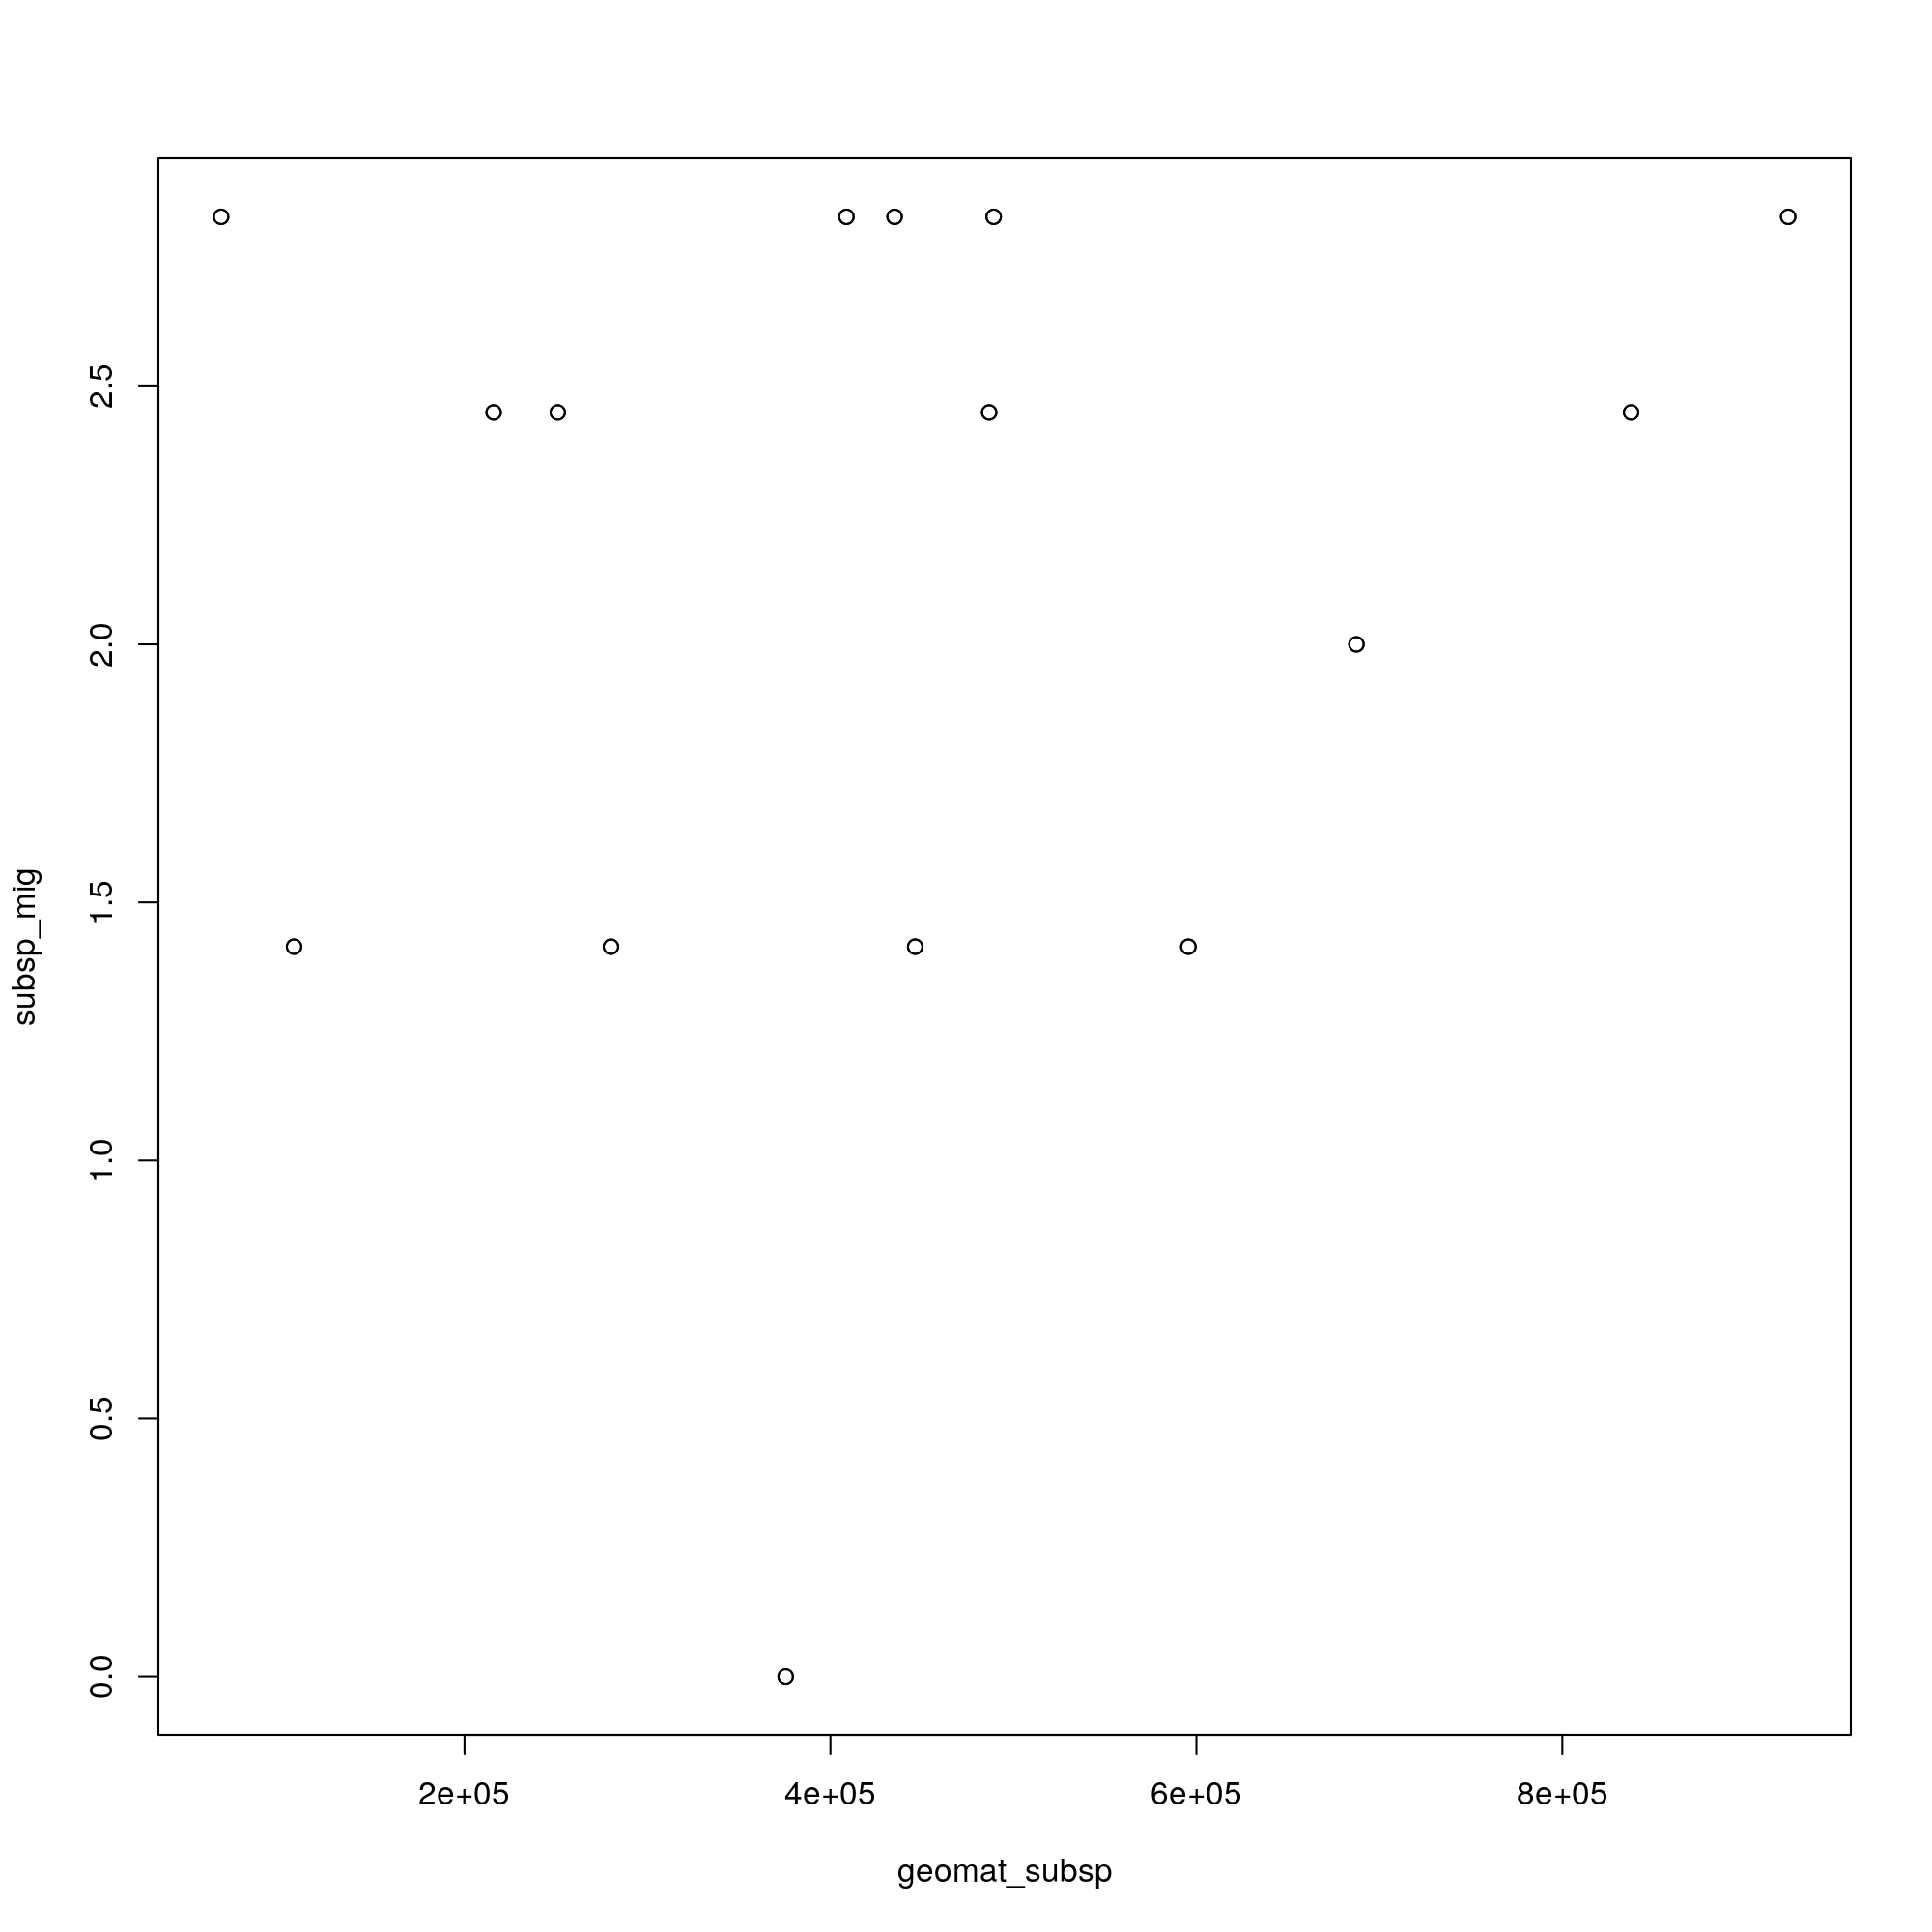

$z.stat
[1] 44436698

$p
[1] 0.063

$alternative
[1] "two.sided"

1        2        3        4        5       
1       NA 12.12436 11.78983 12.28821 10.95445
2 12.12436       NA 11.91638 12.49000 13.45362
3 11.78983 11.91638       NA 11.22497 11.61895
4 12.28821 12.49000 11.22497       NA 11.00000
5 10.95445 13.45362 11.61895 11.00000       NA

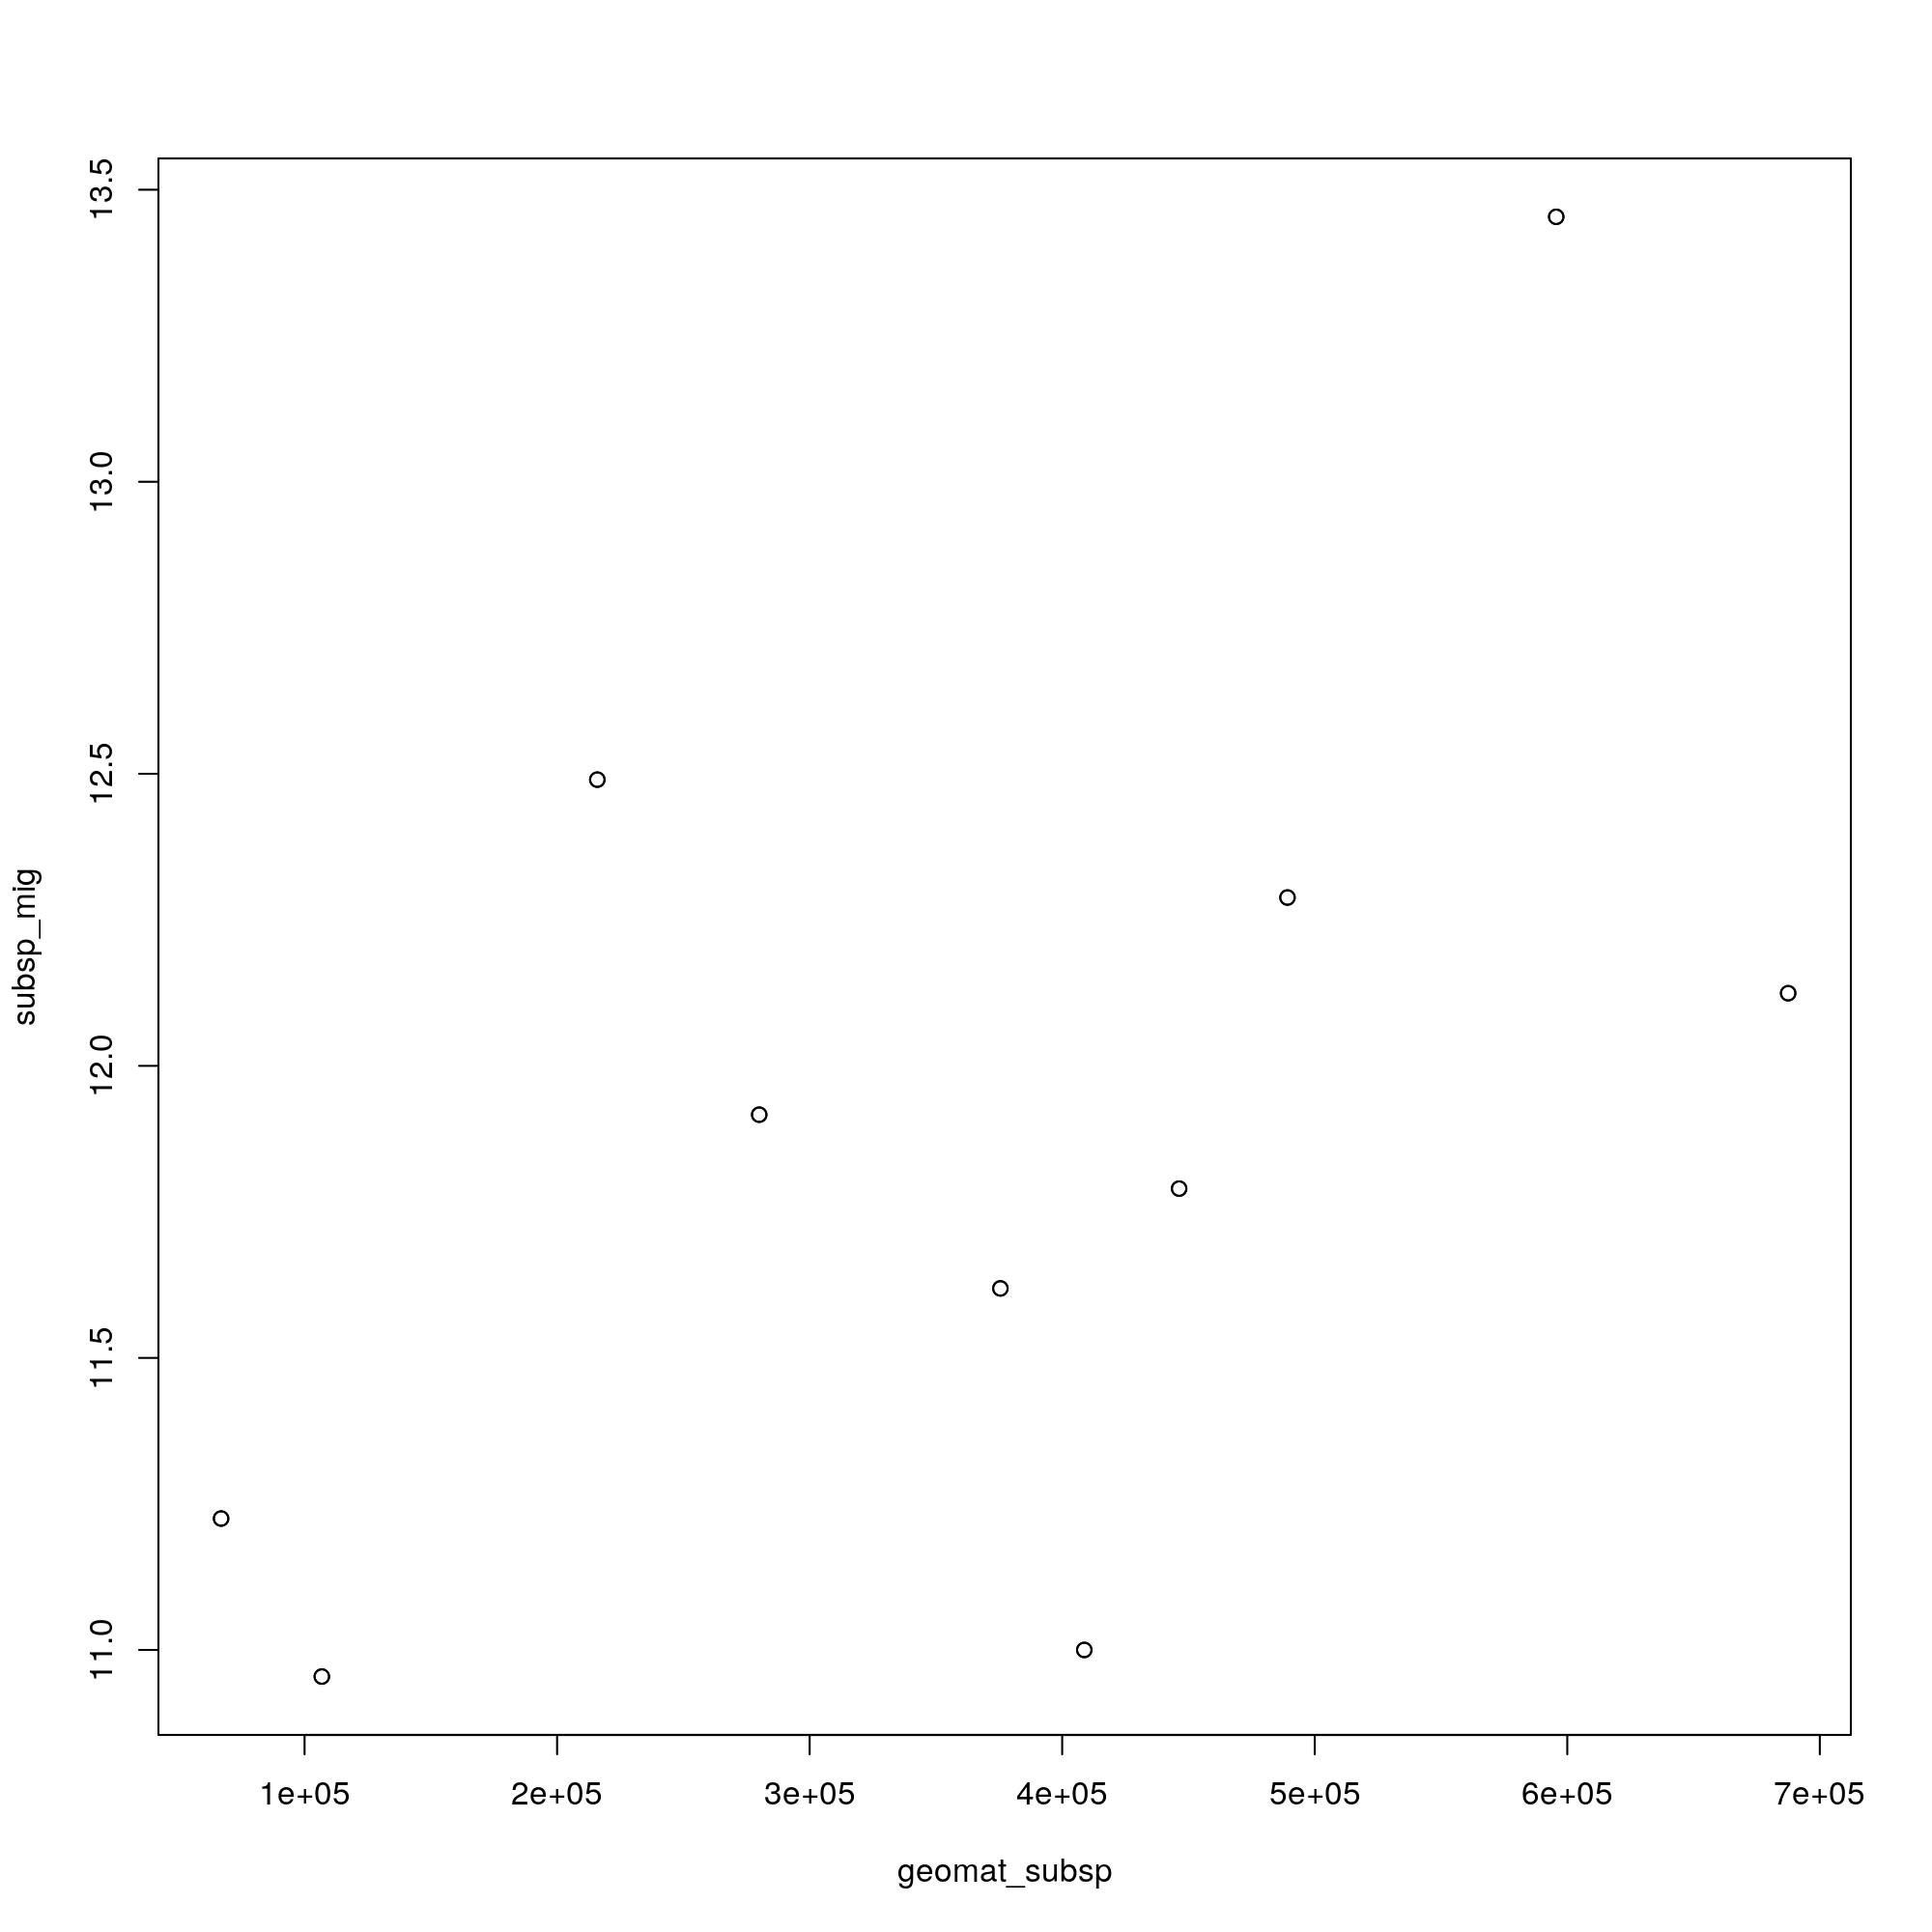

In [36]:
#matrix of geo distances between pops
latlong_subsp <- filter(latlong_df, grepl("Teosinte", population))
geomat_subsp <- geodist::geodist(cbind(latlong_subsp$Longitude, latlong_subsp$Latitude), measure = "geodesic")
rownames(geomat_subsp) <- latlong_subsp$population

subsp_mig <- makesweepmat(filter(top_models_df, type == "Teosinte", model2 == "migration"), 
             pop_ids = c('v5--Teo--Amatlan_de_Canas','v5--Teo--Crucero_Lagunitas',
                         'v5--Teo--El_Rodeo','v5--Teo--Los_Guajes',
                         'v5--Teo--RANDOM1_Palmar_Chico','v5--Teo--San_Lorenzo'))
diag(geomat_subsp) <- diag(subsp_mig) <- NA
plot(geomat_subsp, subsp_mig)
mantel.test(geomat_subsp, subsp_mig)


latlong_subsp <- filter(latlong_df, grepl("Landrace", population))
geomat_subsp <- geodist::geodist(cbind(latlong_subsp$Longitude, latlong_subsp$Latitude), measure = "geodesic")
rownames(geomat_subsp) <- latlong_subsp$population
geomat_subsp
subsp_mig <- makesweepmat(filter(top_models_df, type == "Maize", model2 == "migration"), 
             pop_ids = c('v5--LR--Amatlan_de_Canas','v5--LR--Crucero_Lagunitas',
                         'v5--LR--Los_Guajes',
                         'v5--LR--RANDOM1_Palmar_Chico','v5--LR--San_Lorenzo'))
diag(geomat_subsp) <- diag(subsp_mig) <- NA
plot(geomat_subsp, subsp_mig)
mantel.test(geomat_subsp, subsp_mig)
subsp_mig

In [37]:
source("../color_df.R")

color_df
tree_plotter <- function(tree, dge = 110){

    tree$tip.label <- str_remove_all(tree$tip.label, "v5--")
    tree_string <- drop.tip(tree, tip = c("Teo--Palmar_Chico", "Teo--random2_Palmar_Chico", "LR--Palmar_Chico", "LR--random2_Palmar_Chico"))

    #png(filename = "../figures/raw_tree.png", res = 300, width = 5, height = 5, units = "in")
    #pdf("../figures/raw_tree.pdf", width = 5, height = 5)

    par(mar = c(0,0,2,0))
    plot.phylo(tree_string, type = "unrooted", show.tip.label = FALSE, 
               rotate.tree = dge, edge.width = 2, no.margin = TRUE)
    tip_str <- str_replace(tree_string$tip.label, "--", "_")
    tip_str <- str_replace(tip_str, "RANDOM", "random")
    
    tip_pch <- ifelse(grepl("Teo", x = tip_str), 21, 24)
    tiplabels(pch = tip_pch, bg = color_df$color[match(tip_str, color_df$pop)], cex = 3.5)
    #tiplabels(text = tip_str)
    #box()
    
    #text(0.08,0.0, "Maize", cex = 1.5)
    #text(0.08,0.1, "Teosinte", cex = 1.5)

    par(new=TRUE)
    plot.phylo(tree_string, type = "unrooted", show.tip.label = FALSE, 
               rotate.tree = dge, edge.width = 2.5, no.margin = TRUE)

    legend_df <- color_df %>% 
        mutate(pop = str_replace(pop, pattern = "(LR|Teo)_(.)", "\\2") %>% str_replace("random(1|2)_", "")) %>% 
        distinct() %>% 
        filter(pop != "random")
    #legend('right', cex = 1, legend_df$pop, pch = 21, pt.bg = legend_df$color, ncol = 1)
    #dev.off()

    #treeplot <- image_ggplot(image_read("../figures/raw_tree.pdf"), interpolate = TRUE) + theme(plot.margin = margin(0, 0, 0, 0, "cm"))

}


pop                      color           
1  LR_Los_Guajes            mediumaquamarine
2  Teo_Los_Guajes           mediumaquamarine
3  LR_Crucero_Lagunitas     gold            
4  Teo_Crucero_Lagunitas    gold            
5  LR_El_Rodeo              darkorange      
6  Teo_El_Rodeo             darkorange      
7  LR_Amatlan_de_Canas      cornflowerblue  
8  Teo_Amatlan_de_Canas     cornflowerblue  
9  LR_San_Lorenzo           purple          
10 Teo_San_Lorenzo          purple          
11 LR_Palmar_Chico          violetred       
12 Teo_Palmar_Chico         violetred       
13 LR_random1_Palmar_Chico  violetred       
14 Teo_random1_Palmar_Chico violetred       
15 LR_random2_Palmar_Chico  violetred       
16 Teo_random2_Palmar_Chico violetred       
17 LR_random                grey            
18 Teo_random               grey

`summarise()` has grouped output by 'Landraces_count'. You can override using the `.groups` argument.



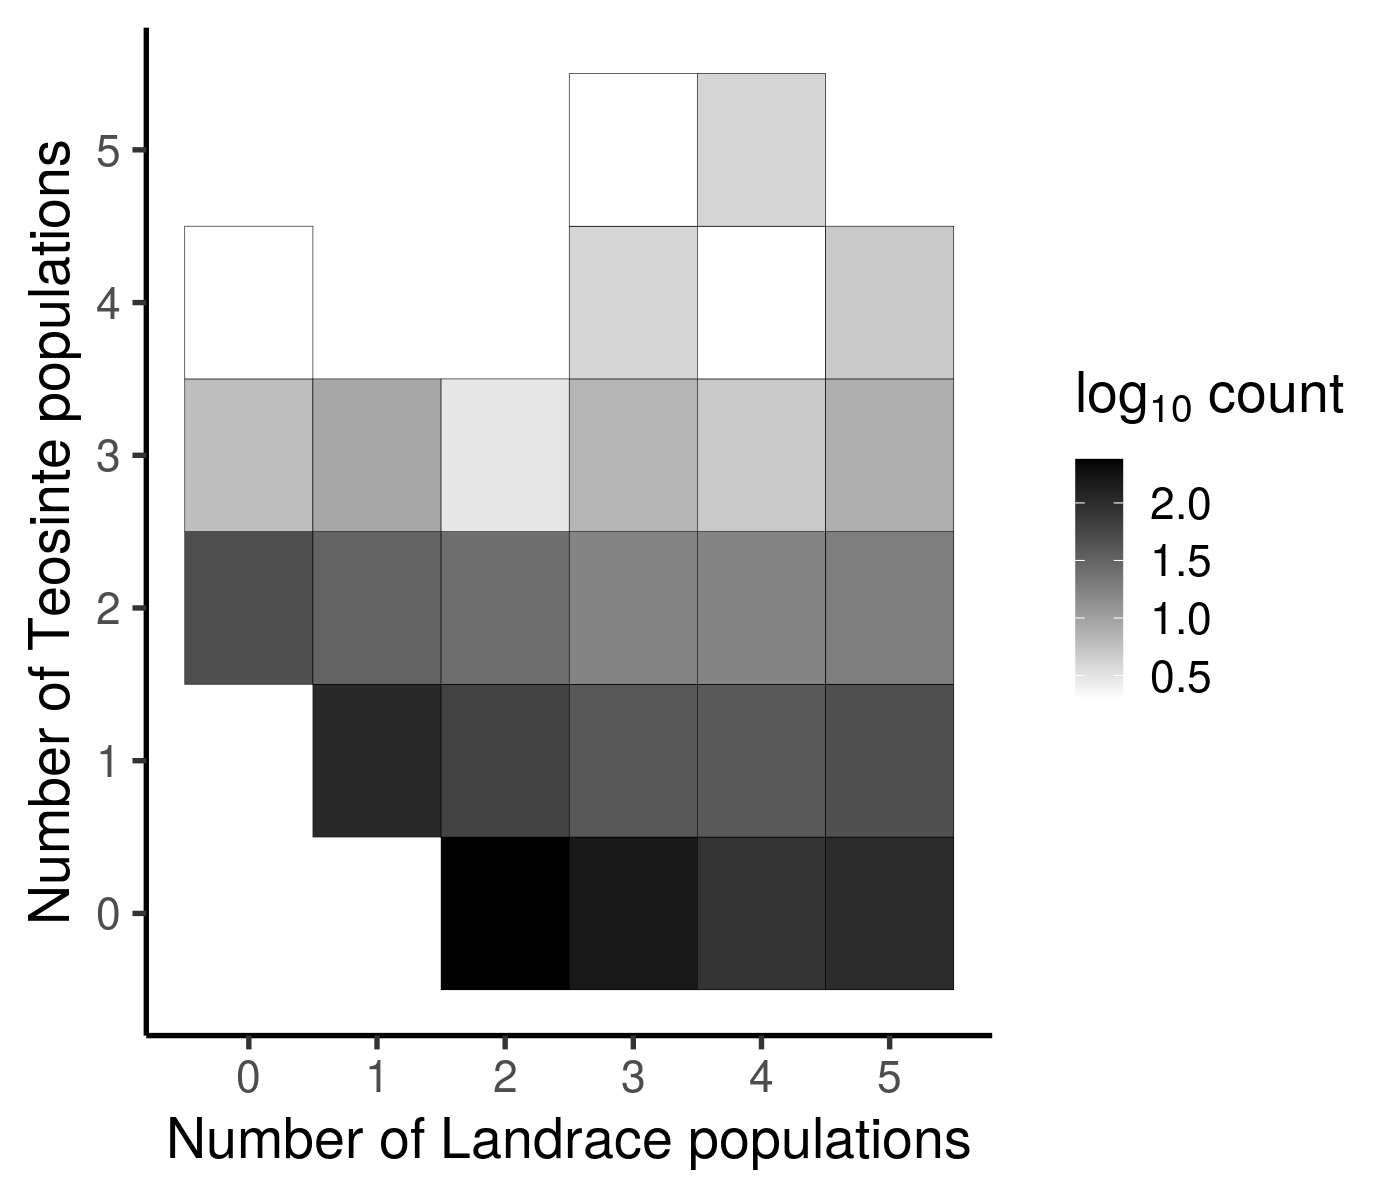

In [38]:
options(repr.plot.width = 7, repr.plot.height = 6 , repr.plot.res = 200)

shareplot <- top_models_df %>%
    filter(model2 != "neutral") %>% 
    mutate(
        pop_count = str_count(populations, ",") + 1,
        Landraces_count = str_count(populations, "LR"),
        Teosinte_count =  str_count(populations, "Teo")        
        ) %>% 
    filter(Landraces_count != 0 | Teosinte_count != 0) %>%
    group_by(Landraces_count, Teosinte_count) %>% 
    summarise(type_count = n()) %>% 
    ggplot(aes(Landraces_count, Teosinte_count, fill = log10(type_count))) +
    geom_tile(color = "black") +
    scale_fill_gradient(low = "white", high = "black") +
    scale_y_continuous(breaks = 0:18) +
    scale_x_continuous(breaks = 0:18) +
    xlab("Number of Landrace populations") +
    ylab("Number of Teosinte populations") +
    labs(fill = expression(paste(log[10], " count")))
    
shareplot

pop1                     pop2                        
1 v5--LR--Amatlan_de_Canas v5--LR--Crucero_Lagunitas   
2 v5--LR--Amatlan_de_Canas v5--LR--Los_Guajes          
3 v5--LR--Amatlan_de_Canas v5--LR--random1_Palmar_Chico
4 v5--LR--Amatlan_de_Canas v5--LR--San_Lorenzo         
5 v5--LR--Amatlan_de_Canas v5--Teo--Amatlan_de_Canas   
6 v5--LR--Amatlan_de_Canas v5--Teo--Crucero_Lagunitas

pop                          count_pop1 count_pop2
1 v5--LR--Amatlan_de_Canas      936        936      
2 v5--LR--Crucero_Lagunitas     570        570      
3 v5--LR--Los_Guajes            835        835      
4 v5--LR--random1_Palmar_Chico    0          0      
5 v5--LR--San_Lorenzo          1132       1132      
6 v5--Teo--Amatlan_de_Canas      94         94

pop1 pop2 share_count type

type     total_sweeps
1 both     1734        
2 Maize    1008        
3 Teosinte   95

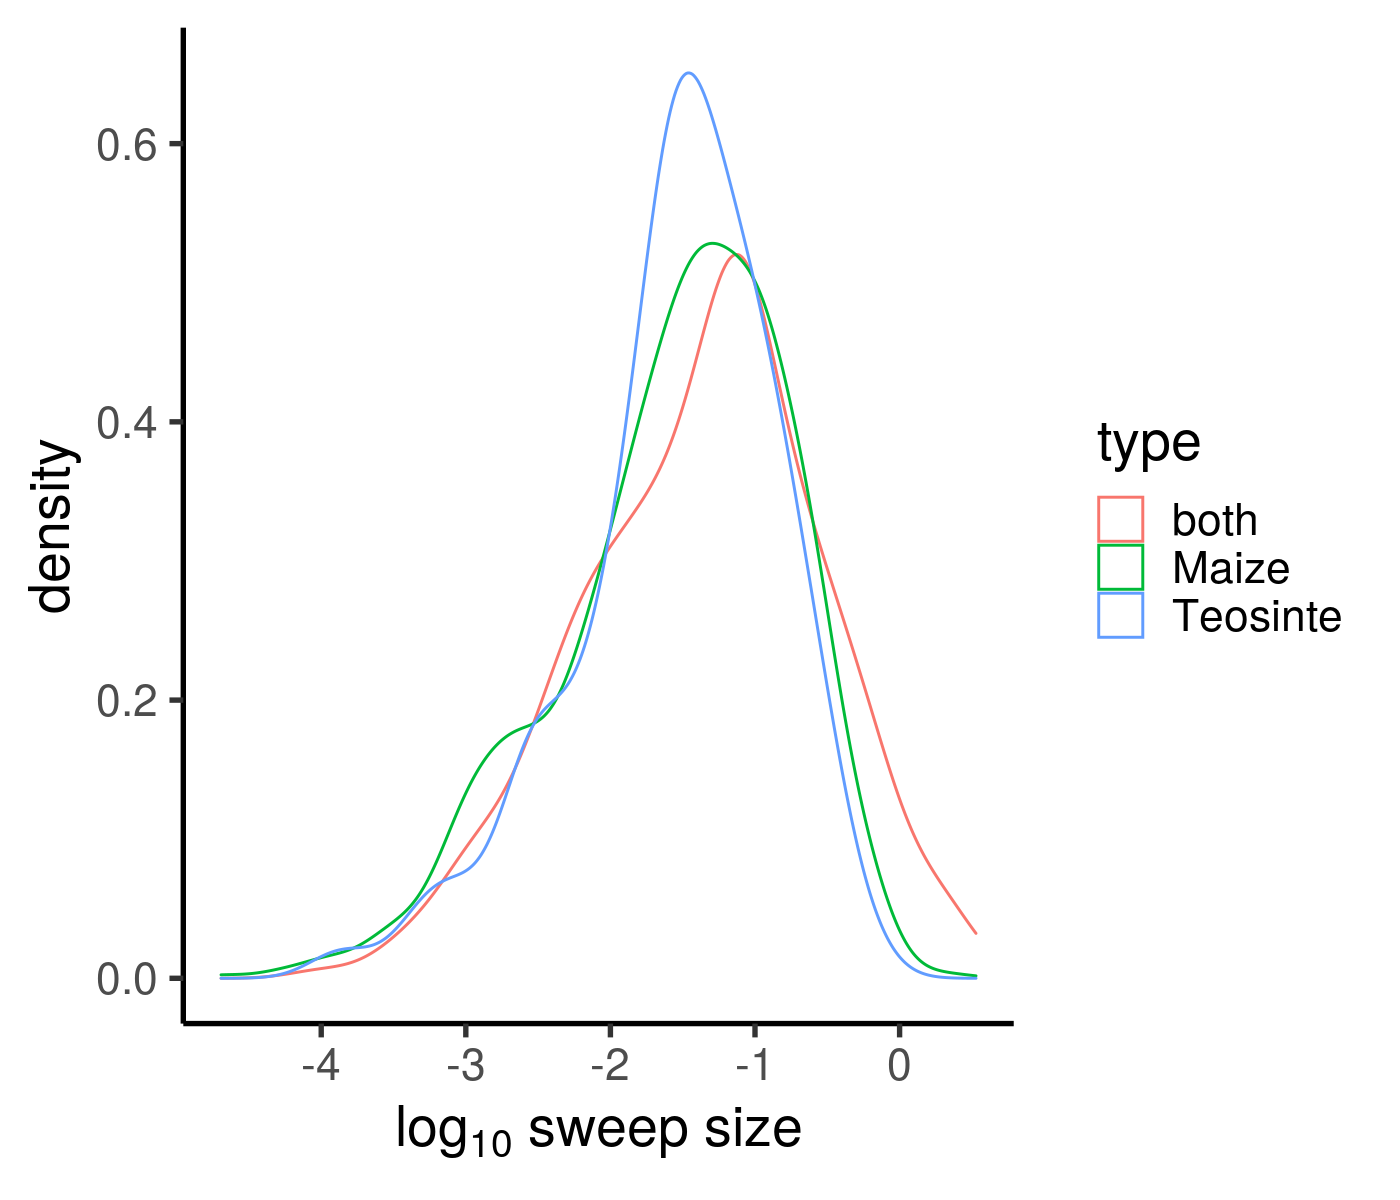

pop                          count_pop1 count_pop2
1 v5--LR--Amatlan_de_Canas      936        936      
2 v5--LR--Crucero_Lagunitas     570        570      
3 v5--LR--Los_Guajes            835        835      
4 v5--LR--random1_Palmar_Chico    0          0      
5 v5--LR--San_Lorenzo          1132       1132      
6 v5--Teo--Amatlan_de_Canas      94         94

pop1 pop2 share_count type

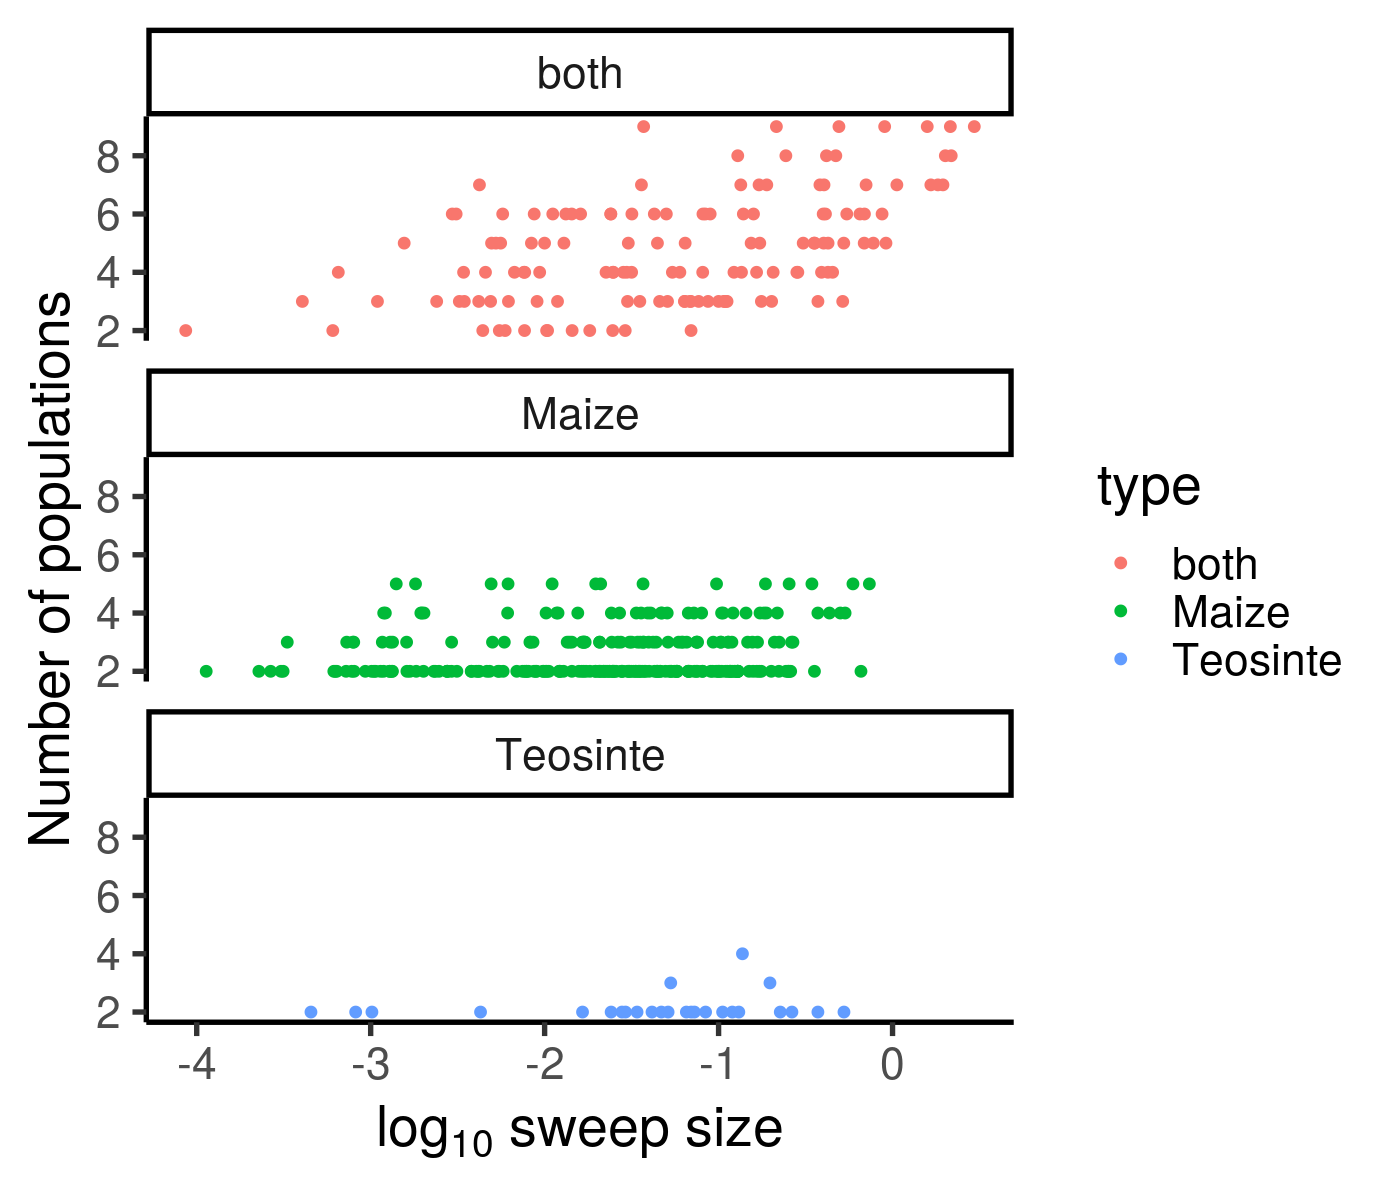

In [39]:
all_pops <- c(
    "v5--LR--Amatlan_de_Canas", 
    "v5--LR--Crucero_Lagunitas", 
    "v5--LR--Los_Guajes", 
    "v5--LR--random1_Palmar_Chico", 
    "v5--LR--San_Lorenzo", 
    "v5--Teo--Amatlan_de_Canas", 
    "v5--Teo--Crucero_Lagunitas", 
    "v5--Teo--El_Rodeo", 
    "v5--Teo--Los_Guajes", 
    "v5--Teo--random1_Palmar_Chico", 
    "v5--Teo--San_Lorenzo"
)

pop_pairs <- 
combn(all_pops, 2) %>% 
    t() %>% 
    data.frame() %>% 
    set_colnames(c("pop1", "pop2")) %>% 
    as_tibble() %>% 
    mutate(pop1 = str_replace_all(pop1, "random1", "RANDOM1"),
           pop2 = str_replace_all(pop2, "random2", "RANDOM2"))
head(pop_pairs)



pair_df <- 

c("both", "Teosinte", "Maize") %>% 
map_df(~{
    pop_pairs %>%
        rowwise() %>% 
        pmap_df(function(pop1, pop2){

                share_count <- filter(top_models_df, grepl(pop1, populations), 
                                      grepl(pop2, populations), type == .x) %>% 
                nrow()
                if(share_count > 0){
                    tibble(pop1, pop2, share_count, type = .x)
                } else{
                    tibble()
                }
                
        })

    }) %>% 
    arrange(desc(share_count))


pop_count_df <- 
    all_pops %>% 
    map_df(~ {
        pcount <- filter(top_models_df, grepl(.x, populations)) %>% 
            nrow()
        tibble(pop = .x, count_pop1 = pcount, count_pop2 = pcount)
    })

head(pop_count_df)

pair_df %>% 
    filter(type == "Teosinte", grepl("LR", pop1), grepl("LR", pop2))


sweep_counts_df <- top_models_df %>% 
    group_by(type) %>% 
    summarise(total_sweeps = n()) %>%
    ungroup() %>% 
    mutate(total_sweeps = ifelse(type == "both", sum(.$total_sweeps), total_sweeps))
sweep_counts_df


top_models_df %>% 
    filter(pop_count > 1) %>% 
    ggplot(aes(log10(sweepsize_cM), colour = type)) +
    geom_density() +
    xlab(expression(paste(log[10], " sweep size")))


top_models_df %>% 
    filter(pop_count > 1, model2 %in% c("migration, independent", "standing")) %>% 
    ggplot(aes(log10(sweepsize_cM), pop_count, colour = type)) +
    geom_point() +
    facet_wrap(~type, ncol = 1) +
    xlab(expression(paste(log[10], " sweep size"))) +
    ylab("Number of populations")


pair_df <- 

c("both", "Teosinte", "Maize") %>% 
map_df(~{
    pop_pairs %>%
        rowwise() %>% 
        pmap_df(function(pop1, pop2){

                share_count <- filter(top_models_df, grepl(pop1, populations), 
                                      grepl(pop2, populations), type == .x) %>% 
                nrow()
                if(share_count > 0){
                    tibble(pop1, pop2, share_count, type = .x)
                } else{
                    tibble()
                }
                
        })

    }) %>% 
    arrange(desc(share_count))


pop_count_df <- 
    all_pops %>% 
    map_df(~ {
        pcount <- filter(top_models_df, grepl(.x, populations)) %>% 
            nrow()
        tibble(pop = .x, count_pop1 = pcount, count_pop2 = pcount)
    })

head(pop_count_df)

pair_df %>% 
    filter(type == "Teosinte", grepl("LR", pop1), grepl("LR", pop2))

